## 사전설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dacon/lgaimers-3

/content/drive/MyDrive/dacon/lgaimers-3


In [ ]:
# !pip install -U transformers -q

In [ ]:
import gc
import random
import time
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter
from itertools import chain

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler, Normalizer, StandardScaler
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# from transformers import get_cosine_schedule_with_warmup

In [ ]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
class CFG:
  TRAIN_WINDOW_SIZE = 126
  PREDICT_SIZE = 21
  EPOCHS = 10
  LEARNING_RATE = 1e-4
  BATCH_SIZE = 256
  SEED = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG.SEED) # Seed 고정

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# This is for Informer
class params:
  features = 'MS'
  target = 'OT'
  freq = 'd'
  checkpoints = './model/'
  seq_len = 126
  label_len = 63
  pred_len = 21
  enc_in = 2
  dec_in = 2
  c_out = 1
  d_model = 512
  n_heads = 8
  e_layers = 2
  d_layers = 1
  s_layers = (3, 2, 1)
  d_ff = 2048
  factor = 5
  padding = 0
  distil = True
  dropout = 0.05
  attn = 'prob'
  embed = 'timeF'
  activation = 'gelu'
  output_attention = False
  do_predict = False
  mix = True
  cols = None
  num_workers = 0
  itr = 2
  train_epochs = 6
  batch_size = 512
  patience = 3
  learning_rate = 0.0001
  des = 'test'
  loss = 'mse'
  lradj = 'type1'
  use_amp = False
  inverse = False
  use_gpu = False
  gpu = 0
  use_multi_gpu = False
  devices = (0,1,2,3)

# My Code

## Data Analysis

In [ ]:
train_data = pd.read_csv('./open/train.csv').drop(columns=['ID', '제품'])

In [ ]:
train_data.head()

,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

## Data Preprocess

In [ ]:
categorical_data = train_data.iloc[:,:4]
time_series_data = train_data.iloc[:,4:]

In [ ]:
le = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    le.fit(categorical_data[col])
    categorical_data[col] = le.transform(categorical_data[col])

In [ ]:
min_values = time_series_data.min(axis=1)
max_values = time_series_data.max(axis=1)

ranges = max_values - min_values
ranges[ranges == 0] = 1

time_series_data = (time_series_data.subtract(min_values, axis=0)).div(ranges, axis=0)

scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
window_size = 400
target_size = 21
categories = np.empty(shape=(1,4))
input_sequences = np.empty(shape=(1,window_size))
targets = np.empty(shape=(1,target_size))

In [ ]:
for i in range(len(time_series_data.columns) - window_size - target_size + 1):
  categories = np.vstack((categories, categorical_data.values))
  input_sequences = np.vstack((input_sequences, time_series_data.iloc[:, i:i + window_size].values))
  targets = np.vstack((targets, time_series_data.iloc[:,i + window_size:i + window_size + target_size].values))

  if i == 0:
    categories = categories[1:,:]
    input_sequences = input_sequences[1:,:]
    targets = targets[1:,:]

## Baseline process

In [ ]:
train_data = pd.read_csv('./open/train.csv').drop(columns=['제품'])
cat_size = 5

In [ ]:
# train_data = pd.read_csv('./open/train_data_encoder.csv').drop(columns=['제품'])
# cat_size = 5

In [ ]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[cat_size:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
# Label Encoding
big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

In [ ]:
# One Hot Encoding
# train_data_copy = train_data.iloc[:,cat_size:]

In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# one_hot_encoder = OneHotEncoder()
# categorical_columns = ['대분류', '중분류', '소분류', '브랜드']

# one_hot_encoder.fit(train_data[categorical_columns])
# one_hot_df = pd.DataFrame(one_hot_encoder.transform(train_data[categorical_columns]).toarray())

In [ ]:
# train_data_copy = pd.concat((one_hot_df, train_data_copy), axis=1)

In [ ]:
# def make_train_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
#     '''
#     학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
#     data : 일별 판매량
#     train_size : 학습에 활용할 기간
#     predict_size : 추론할 기간
#     '''
#     num_rows = len(data)
#     window_size = train_size + predict_size

#     input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :cat_size]) + 1))
#     target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))

#     for i in tqdm(range(num_rows)):
#         encode_info = np.array(data.iloc[i, :cat_size])
#         sales_data = np.array(data.iloc[i, cat_size:])

#         for j in range(len(sales_data) - window_size + 1):
#             window = sales_data[j : j + window_size]
#             temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
#             input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
#             target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]

#     return input_data, target_data

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    STEP_SIZE = 2

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :cat_size]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            # input_data[i * adjusted_size + j] = temp_data
            # target_data[i * adjusted_size + j] = window[train_size:]
            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, target_data

In [ ]:
def make_predict_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, 1:cat_size]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, 1:cat_size])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [ ]:
train_input, train_target = make_train_data(train_data, cat_size)
test_input = make_predict_data(train_data, cat_size)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input.shape, train_target.shape, test_input.shape)

(1525440, 252, 6) (1525440, 21) (15890, 252, 5)


In [ ]:
# from sklearn.model_selection import train_test_split
#
# X_train, X_valid, y_train, y_valid = train_test_split(train_input, train_target, test_size=0.2, random_state=CFG.SEED)

In [ ]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
# train_dataset = CustomDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

# val_dataset = CustomDataset(X_valid, y_valid)
# val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

## Informer Process

### Tools **

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0:
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    >
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]):
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

In [ ]:
def adjust_learning_rate(optimizer, epoch, args):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    if args.lradj=='type1':
        lr_adjust = {epoch: args.learning_rate * (0.5 ** ((epoch-1) // 1))}
    elif args.lradj=='type2':
        lr_adjust = {
            2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
            10: 5e-7, 15: 1e-7, 20: 5e-8
        }
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path+'/'+'checkpoint.pth')
        self.val_loss_min = val_loss

class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

class StandardScaler():
    def __init__(self):
        self.mean = 0.
        self.std = 1.

    def fit(self, data):
        self.mean = data.mean(0)
        self.std = data.std(0)

    def transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        return (data - mean) / std

    def inverse_transform(self, data):
        mean = torch.from_numpy(self.mean).type_as(data).to(data.device) if torch.is_tensor(data) else self.mean
        std = torch.from_numpy(self.std).type_as(data).to(data.device) if torch.is_tensor(data) else self.std
        if data.shape[-1] != mean.shape[-1]:
            mean = mean[-1:]
            std = std[-1:]
        return (data * std) + mean

### Main

In [ ]:
train_data = pd.read_csv('./open/train.csv').drop(columns=['ID', '제품'])
submit = pd.read_csv('./open/sample_submission.csv')

In [ ]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[4:]
# 각 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
# Label Encoding
big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

In [ ]:
def make_train_data(data, train_size=params.seq_len, label_size=params.label_len, predict_size=params.pred_len):
    STEP_SIZE = 7

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    x = np.empty((num_rows * adjusted_size, train_size, 5))
    x_mark = np.empty((num_rows * adjusted_size, train_size, 3))
    y = np.empty((num_rows * adjusted_size, label_size + predict_size, 5))
    y_mark = np.empty((num_rows * adjusted_size, label_size + predict_size, 3))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=data.columns[4:]
    )
    date_stamps = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            window_dates = date_stamps[:window_size]
            temp_data_for_x = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data_for_y = np.column_stack((np.tile(encode_info, (label_size + predict_size, 1)), window[train_size-label_size:train_size + predict_size]))
            temp_data_for_xmark = window_dates[:train_size]
            temp_data_for_ymark = window_dates[train_size-label_size:train_size + predict_size]

            x[i * adjusted_size + j // STEP_SIZE] = temp_data_for_x
            y[i * adjusted_size + j // STEP_SIZE] = temp_data_for_y
            x_mark[i * adjusted_size + j // STEP_SIZE] = temp_data_for_xmark
            y_mark[i * adjusted_size + j // STEP_SIZE] = temp_data_for_ymark

    return x, y, x_mark, y_mark

In [ ]:
# 띄엄띄엄 넣기

def make_train_data(data, train_size=params.seq_len, label_size=params.label_len, predict_size=params.pred_len):
    STEP_SIZE = 7

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    x = np.empty((num_rows * adjusted_size, train_size, 5))
    x_mark = np.empty((num_rows * adjusted_size, train_size, 3))
    y = np.empty((num_rows * adjusted_size, label_size + predict_size, 5))
    y_mark = np.empty((num_rows * adjusted_size, label_size + predict_size, 3))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=data.columns[4:]
    )
    date_stamps = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, 4:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            window_dates = date_stamps[j:j+window_size]
            temp_data_for_x = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data_for_y = np.column_stack((np.tile(encode_info, (label_size + predict_size, 1)), window[train_size-label_size:train_size + predict_size]))
            temp_data_for_xmark = window_dates[:train_size]
            temp_data_for_ymark = window_dates[train_size-label_size:train_size + predict_size]

            x[(j // STEP_SIZE) * num_rows + i] = temp_data_for_x
            y[(j // STEP_SIZE) * num_rows + i] = temp_data_for_y
            x_mark[(j // STEP_SIZE) * num_rows + i] = temp_data_for_xmark
            y_mark[(j // STEP_SIZE) * num_rows + i] = temp_data_for_ymark

    return x, y, x_mark, y_mark

In [ ]:
def make_predict_data(data, pred_dates, train_size=params.seq_len, label_size=params.label_len, predict_size=params.pred_len):
    num_rows = len(data)

    x = np.empty((num_rows, train_size, 5))
    y = np.empty((num_rows, label_size, 5))
    x_mark = np.empty((num_rows, train_size, 3))
    y_mark = np.empty((num_rows, label_size + predict_size, 3))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=np.hstack((data.columns[-train_size:],pred_dates))
    )
    date_stamps = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :4])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size:]
        temp_data_for_x = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        temp_data_for_y = np.column_stack((np.tile(encode_info, (label_size, 1)), window[-label_size:]))
        temp_data_for_xmark = date_stamps[:train_size]
        temp_data_for_ymark = date_stamps[train_size-label_size:train_size + predict_size]
        x[i] = temp_data_for_x
        y[i] = temp_data_for_y
        x_mark[i] = temp_data_for_xmark
        y_mark[i] = temp_data_for_ymark

    return x, y, x_mark, y_mark

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, cat_size=4, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    STEP_SIZE = 7

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :cat_size]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            # input_data[i * adjusted_size + j] = temp_data
            # target_data[i * adjusted_size + j] = window[train_size:]
            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, target_data

In [ ]:
def make_predict_data(data, cat_size=4, train_size=CFG.TRAIN_WINDOW_SIZE):
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, 1:cat_size]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, 1:cat_size])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [ ]:
X_train, y_train, X_train_mark, y_train_mark = make_train_data(train_data)
X_test, y_test, X_test_mark, y_test_mark = make_predict_data(train_data, submit.columns[1:])

In [ ]:
print(X_train.shape, y_train.shape, X_train_mark.shape, y_train_mark.shape)
print(X_test.shape, y_test.shape, X_test_mark.shape, y_test_mark.shape)

(889840, 63, 5) (889840, 35, 5) (889840, 63, 3) (889840, 35, 3)
(15890, 63, 5) (15890, 28, 5) (15890, 63, 3) (15890, 35, 3)


In [ ]:
# Train / Validation Split
data_len = len(X_train)
X_val = X_train[-int(data_len*0.25):]
y_val = y_train[-int(data_len*0.25):]
X_val_mark = X_train_mark[-int(data_len*0.25):]
y_val_mark = y_train_mark[-int(data_len*0.25):]
X_train = X_train[:-int(data_len*0.25)]
y_train = y_train[:-int(data_len*0.25)]
X_train_mark = X_train_mark[:-int(data_len*0.25)]
y_train_mark = y_train_mark[:-int(data_len*0.25)]

In [ ]:
class InformerDataset(Dataset):
    def __init__(self, X, y, X_mark, y_mark):
        self.X = X
        self.y = y
        self.X_mark = X_mark
        self.y_mark = y_mark

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]).float(), torch.Tensor(self.y[index]).float(), torch.Tensor(self.X_mark[index]).float(), torch.Tensor(self.y_mark[index]).float()

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = InformerDataset(X_train, y_train, X_train_mark, y_train_mark)
train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size, shuffle=True, num_workers=0, drop_last=True)

val_dataset = InformerDataset(X_val, y_val, X_val_mark, y_val_mark)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size, shuffle=False, num_workers=0, drop_last=False)

In [ ]:
test_dataset = InformerDataset(X_test, y_test, X_test_mark, y_test_mark)
test_dataloader = DataLoader(test_dataset, batch_size=params.batch_size, shuffle=False, num_workers=0, drop_last=False)

### Data with Sales and Brand Keyword **

In [ ]:
train_data = pd.read_csv('./open/new_train_round.csv').drop(columns=['ID','제품'])

In [ ]:
train_data_keyword_cnt = pd.read_csv('./open/brand_keyword_cnt_preprocess.csv')

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')

In [ ]:
class CustomScaler:
    def __init__(self):
        self.robust_scaler = RobustScaler()
        self.minmax_scaler = MinMaxScaler()

    def fit(self ,X):
        X = self.robust_scaler.fit_transform(X.T)
        _ = self.minmax_scaler.fit(X)

    def transform(self, X):
        X = self.robust_scaler.transform(X.T)
        X = self.minmax_scaler.transform(X).T
        return X

    def fit_transform(self, X):
        self.fit(X)
        X = self.transform(X)
        return X

    def inverse_transform(self, X):
        X = self.minmax_scaler.inverse_transform(X.T)
        X = self.robust_scaler.inverse_transform(X).T
        return X

In [ ]:
sc_main = CustomScaler()

train_data.iloc[:, 5:] = sc_main.fit_transform(train_data.iloc[:,5:].values)

sc_brand = CustomScaler()

train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values)

In [ ]:
label_encoder = LabelEncoder()
categorical_columns = ['가격', '대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [ ]:
all_dates = pd.DataFrame(
        columns=['date'],
        data=train_data.columns[5:]
  )

date_stamps = time_features(all_dates, timeenc=1, freq='d')

In [ ]:
def make_train_data(data, train_size=params.seq_len, label_size=params.label_len, predict_size=params.pred_len):
    STEP_SIZE = 7
    brand_labels = label_encoder.classes_

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    x = np.empty((num_rows * adjusted_size, train_size, 7))
    x_mark = np.empty((num_rows * adjusted_size, train_size, 3))
    y = np.empty((num_rows * adjusted_size, label_size + predict_size, 7))
    y_mark = np.empty((num_rows * adjusted_size, label_size + predict_size, 3))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j:j+window_size]
            window_dates = date_stamps[j:j+window_size]
            keyword_window=keyword_data[j:j+window_size]
            keyword_temp_x = keyword_window[:train_size]
            keyword_temp_y = keyword_window[train_size-label_size:train_size + predict_size]

            temp_data_for_x = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data_for_x = np.column_stack((temp_data_for_x, keyword_temp_x))
            temp_data_for_y = np.column_stack((np.tile(encode_info, (label_size + predict_size, 1)), window[train_size-label_size:train_size + predict_size]))
            temp_data_for_y = np.column_stack((temp_data_for_y, keyword_temp_y))
            temp_data_for_xmark = window_dates[:train_size]
            temp_data_for_ymark = window_dates[train_size-label_size:train_size + predict_size]

            x[(j // STEP_SIZE) * num_rows + i] = temp_data_for_x
            y[(j // STEP_SIZE) * num_rows + i] = temp_data_for_y
            x_mark[(j // STEP_SIZE) * num_rows + i] = temp_data_for_xmark
            y_mark[(j // STEP_SIZE) * num_rows + i] = temp_data_for_ymark

    return x, y, x_mark, y_mark

In [ ]:
def make_predict_data(data, pred_dates, train_size=params.seq_len, label_size=params.label_len, predict_size=params.pred_len):
    num_rows = len(data)
    brand_labels = label_encoder.classes_

    x = np.empty((num_rows, train_size, 7))
    y = np.empty((num_rows, label_size, 7))
    x_mark = np.empty((num_rows, train_size, 3))
    y_mark = np.empty((num_rows, label_size + predict_size, 3))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=np.hstack((data.columns[-train_size:],pred_dates))
    )
    date_stamps_pred = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, -train_size:])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data = np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)

        keyword_window = keyword_data[-train_size:]
        window = sales_data[-train_size:]

        temp_data_for_x = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        temp_data_for_x = np.column_stack((temp_data_for_x, keyword_window[:train_size]))
        temp_data_for_y = np.column_stack((np.tile(encode_info, (label_size, 1)), window[-label_size:]))
        temp_data_for_y = np.column_stack((temp_data_for_y, keyword_window[-label_size:]))

        temp_data_for_xmark = date_stamps_pred[:train_size]
        temp_data_for_ymark = date_stamps_pred[train_size-label_size:train_size + predict_size]

        x[i] = temp_data_for_x
        y[i] = temp_data_for_y
        x_mark[i] = temp_data_for_xmark
        y_mark[i] = temp_data_for_ymark

    return x, y, x_mark, y_mark

In [ ]:
X_train, y_train, X_train_mark, y_train_mark = make_train_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
X_test, y_test, X_test_mark, y_test_mark = make_predict_data(train_data, submit.columns[1:])

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(X_train.shape, y_train.shape, X_train_mark.shape, y_train_mark.shape)
print(X_test.shape, y_test.shape, X_test_mark.shape, y_test_mark.shape)

(715050, 126, 7) (715050, 84, 7) (715050, 126, 3) (715050, 84, 3)
(15890, 126, 7) (15890, 63, 7) (15890, 126, 3) (15890, 84, 3)


In [ ]:
# Stratified Train Val Split (By 대분류)
skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(X_train, y=X_train[:,0,1])):
    if i == fold:
        X_val = X_train[val_idxs]
        y_val = y_train[val_idxs]
        X_val_mark = X_train_mark[val_idxs]
        y_val_mark = y_train_mark[val_idxs]

        X_train = X_train[train_idxs]
        y_train = y_train[train_idxs]
        X_train_mark = X_train_mark[train_idxs]
        y_train_mark = y_train_mark[train_idxs]
        break

In [ ]:
class InformerDataset(Dataset):
    def __init__(self, X, y, X_mark, y_mark):
        self.X = X
        self.y = y
        self.X_mark = X_mark
        self.y_mark = y_mark

    def __getitem__(self, index):
        return torch.Tensor(self.X[index]).float(), torch.Tensor(self.y[index]).float(), torch.Tensor(self.X_mark[index]).float(), torch.Tensor(self.y_mark[index]).float()

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = InformerDataset(X_train, y_train, X_train_mark, y_train_mark)
train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size//2, shuffle=True, num_workers=0, drop_last=True)

val_dataset = InformerDataset(X_val, y_val, X_val_mark, y_val_mark)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size//2, shuffle=False, num_workers=0, drop_last=False)

In [ ]:
test_dataset = InformerDataset(X_test, y_test, X_test_mark, y_test_mark)
test_dataloader = DataLoader(test_dataset, batch_size=params.batch_size//16, shuffle=False, num_workers=0, drop_last=False)

## Category with sales process

In [ ]:
train_data = pd.read_csv('./open/train.csv').drop(columns=['ID','제품'])
cat_size = 4

In [ ]:
train_data = pd.read_csv('./open/train_with_sales.csv').drop(columns=['제품'])
cat_size = 6

In [ ]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[cat_size:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
# Label Encoding
big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

In [ ]:
# Price Scaling
train_data['가격단위'] = train_data['가격단위'] // 100

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    STEP_SIZE = 7

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :cat_size]) + 1))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            # input_data[i * adjusted_size + j] = temp_data
            # target_data[i * adjusted_size + j] = window[train_size:]
            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, target_data

In [ ]:
def make_predict_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :cat_size]) + 1))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [ ]:
train_input, train_target = make_train_data(train_data, cat_size)
test_input = make_predict_data(train_data, cat_size)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input.shape, train_target.shape, test_input.shape)

(715050, 126, 5) (715050, 21) (15890, 126, 5)


In [ ]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [ ]:
# Stratified Train Val Split (By 대분류)
skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(train_input, y=train_input[:,0,1])):
    if i == fold:
        val_input = train_input[val_idxs]
        val_target = train_target[val_idxs]

        train_input = train_input[train_idxs]
        train_target = train_target[train_idxs]
        break

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

## Category with sales process + mark data

In [ ]:
train_data = pd.read_csv('./open/train_with_sales.csv').drop(columns=['제품'])
cat_size = 6

In [ ]:
# 숫자형 변수들의 min-max scaling을 수행하는 코드입니다.
numeric_cols = train_data.columns[cat_size:]
# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)
# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 1로 대체
ranges = max_values - min_values
ranges[ranges == 0] = 1
# min-max scaling 수행
train_data[numeric_cols] = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)
# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()

In [ ]:
# Label Encoding
big_cats = []
for row in train_data['대분류'].str.split('-'):
  big_cats.append(int(row[-1])-1)

middle_cats = []
for row in train_data['중분류'].str.split('-'):
  middle_cats.append(int(row[-1])-1)

small_cats = []
for row in train_data['소분류'].str.split('-'):
  small_cats.append(int(row[-1])-1)

brands = []
for row in train_data['브랜드'].str.split('-'):
  brands.append(int(row[-1])-1)

train_data['대분류'] = big_cats
train_data['중분류'] = middle_cats
train_data['소분류'] = small_cats
train_data['브랜드'] = brands

In [ ]:
# Price Scaling
train_data['가격단위'] = train_data['가격단위'] // 100

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    STEP_SIZE = 7

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :cat_size]) + 1))
    input_mark = np.empty((num_rows * adjusted_size, train_size, 3))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=data.columns[cat_size:]
    )
    date_stamps = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            window_dates = date_stamps[j:j+train_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            input_mark[(j // STEP_SIZE) * num_rows + i] = window_dates
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, input_mark, target_data

In [ ]:
def make_predict_data(data, cat_size, train_size=CFG.TRAIN_WINDOW_SIZE):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, 1:cat_size]) + 1))
    input_mark = np.empty((num_rows, train_size, 3))

    all_dates = pd.DataFrame(
        columns=['date'],
        data=data.columns[cat_size:]
    )
    date_stamps = time_features(all_dates, timeenc=1, freq='d')

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, 1:cat_size])
        sales_data = np.array(data.iloc[i, -train_size:])

        window = sales_data[-train_size : ]
        window_dates = date_stamps[-train_size:]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
        input_mark[i] = window_dates

    return input_data, input_mark

In [ ]:
train_input, train_mark, train_target = make_train_data(train_data, cat_size)
test_input, test_mark = make_predict_data(train_data, cat_size)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input.shape, train_mark.shape, train_target.shape, test_input.shape, test_mark.shape)

(619710, 168, 7) (619710, 168, 3) (619710, 21) (15890, 168, 6) (15890, 168, 3)


In [ ]:
# Train / Validation Split
data_len = len(train_input)
val_input = train_input[-int(data_len*0.2):]
val_mark = train_mark[-int(data_len*0.2):]
val_target = train_target[-int(data_len*0.2):]
train_input = train_input[:-int(data_len*0.2)]
train_mark = train_mark[:-int(data_len*0.2)]
train_target = train_target[:-int(data_len*0.2)]

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, X_mark, Y):
        self.X = X
        self.X_mark = X_mark
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_mark, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_mark, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

## Modeling

### Tabnet

In [ ]:
X = train_data.iloc[:,4:-1]
y = train_data.iloc[:,-1]

In [ ]:
X

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-03-25,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.111111,0.333333,0.222222,0.00000,0.00000,0.222222
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
15886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.024390,0.000000,0.016260,0.03252,0.00813,0.008130
15887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000
15888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from pytorch_tabnet.tab_model import TabNetRegressor

regressor = TabNetRegressor()

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
regressor.fit(
    X_train=X_train.values,
    y_train=y_train.values.reshape((-1,1)),
    eval_set=[(X_test.values, y_test.values.reshape((-1,1)))],
    max_epochs=500,  # Adjust the number of epochs as needed
    patience=10,    # Early stopping patience
    batch_size=CFG.BATCH_SIZE, # Adjust the batch size as needed
)

epoch 0  | loss: 2.54298 | val_0_mse: 0.0864  |  0:00:00s
epoch 1  | loss: 0.79375 | val_0_mse: 0.15829 |  0:00:01s
epoch 2  | loss: 0.51068 | val_0_mse: 0.09387 |  0:00:01s
epoch 3  | loss: 0.2092  | val_0_mse: 0.05129 |  0:00:01s
epoch 4  | loss: 0.15292 | val_0_mse: 0.04636 |  0:00:02s
epoch 5  | loss: 0.11973 | val_0_mse: 0.0427  |  0:00:02s
epoch 6  | loss: 0.09108 | val_0_mse: 0.03833 |  0:00:03s
epoch 7  | loss: 0.06781 | val_0_mse: 0.03761 |  0:00:03s
epoch 8  | loss: 0.05464 | val_0_mse: 0.03714 |  0:00:04s
epoch 9  | loss: 0.04803 | val_0_mse: 0.0363  |  0:00:04s
epoch 10 | loss: 0.04002 | val_0_mse: 0.03554 |  0:00:05s
epoch 11 | loss: 0.03612 | val_0_mse: 0.03515 |  0:00:05s
epoch 12 | loss: 0.03242 | val_0_mse: 0.0349  |  0:00:06s
epoch 13 | loss: 0.02993 | val_0_mse: 0.03466 |  0:00:06s
epoch 14 | loss: 0.02909 | val_0_mse: 0.03447 |  0:00:07s
epoch 15 | loss: 0.02816 | val_0_mse: 0.03416 |  0:00:07s
epoch 16 | loss: 0.0272  | val_0_mse: 0.03382 |  0:00:08s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.columns[1:]

Index(['2023-04-05', '2023-04-06', '2023-04-07', '2023-04-08', '2023-04-09',
       '2023-04-10', '2023-04-11', '2023-04-12', '2023-04-13', '2023-04-14',
       '2023-04-15', '2023-04-16', '2023-04-17', '2023-04-18', '2023-04-19',
       '2023-04-20', '2023-04-21', '2023-04-22', '2023-04-23', '2023-04-24',
       '2023-04-25'],
      dtype='object')

In [ ]:
X_test = train_data.iloc[:,5:]

In [ ]:
for cols in submit.columns[1:]:
  pred = regressor.predict(X_test.values)
  X_test[cols] = pred
  X_test = X_test.iloc[:,1:]

In [ ]:
pred = X_test.iloc[:,-21:]

In [ ]:
for idx in range(len(pred)):
    pred.iloc[idx, :] = pred.iloc[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

In [ ]:
submit.iloc[:,1:] = np.round(pred.values, 0).astype(int)

In [ ]:
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,0,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0
2,2,1,2,2,2,2,2,2,2,2,...,3,3,3,3,3,3,3,3,3,3
3,3,3,3,3,3,4,4,4,4,4,...,5,5,5,5,5,5,5,5,6,5
4,4,2,2,2,2,2,2,2,2,2,...,3,2,2,2,3,3,2,3,2,2


In [ ]:
submit.to_csv('./open/tabnet_submission.csv', index=False)

## Time Series Transformer

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]  # Adjust the positional encoding to match sequence length
        return self.dropout(x)

class TokenEmbedding(nn.Module):
  def __init__(self, c_in, d_model):
      super(TokenEmbedding, self).__init__()
      padding = 1 if torch.__version__>='1.5.0' else 2
      self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                  kernel_size=3, padding=padding, padding_mode='circular')
      for m in self.modules():
          if isinstance(m, nn.Conv1d):
              nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

  def forward(self, x):
      x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
      return x

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_categories, num_time_steps, num_features, num_heads, hidden_size, num_layers, num_output_days):
        super(TimeSeriesTransformer, self).__init__()

        big_num, mid_num, sml_num, brd_num = 5, 11, 53, 3799

        self.cat_embedding1 = nn.Embedding(big_num, hidden_size)
        self.cat_embedding2 = nn.Embedding(mid_num, hidden_size)
        self.cat_embedding3 = nn.Embedding(sml_num, hidden_size)
        self.cat_embedding4 = nn.Embedding(brd_num, hidden_size)

        self.time_embedding = TokenEmbedding(1, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

        # encoder_layer = TransformerEncoderLayerBN(hidden_size, num_heads, num_time_steps, dim_feedforward=hidden_size, dropout=0.1, activation='relu')
        # self.transformer_encoder = TransformerEncoderBN(encoder_layer, num_layers)

        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=0.3, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(num_time_steps, num_output_days)

        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        category_input1, category_input2, category_input3, category_input4 = x[:, :, 0], x[:, :, 1], x[:, :, 2], x[:, :, 3]
        time_series_input = x[:, :, -1:]

        category_embedded1 = self.cat_embedding1(category_input1.long())
        category_embedded2 = self.cat_embedding2(category_input2.long())
        category_embedded3 = self.cat_embedding3(category_input3.long())
        category_embedded4 = self.cat_embedding4(category_input4.long())

        time_embedded = self.time_embedding(time_series_input)

        x = category_embedded1 + category_embedded2 + category_embedded3 + category_embedded4 + time_embedded
        x = self.positional_encoding(x)

        x = self.transformer_encoder(x)

        x = self.dropout(self.fc1(x).squeeze(-1))
        x = self.fc2(x)

        return x

In [ ]:
# num_categories = len(label_encoder.classes_)
# num_categories = train_data['브랜드'].unique()[-1] + 1
num_categories = 4
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_features = 5
num_heads = 4
hidden_size = 512
num_layers = 4
num_output_days = CFG.PREDICT_SIZE

path = f'model/tst_trainwindow{CFG.TRAIN_WINDOW_SIZE}_predictwindow{CFG.PREDICT_SIZE}_heads{num_heads}_hidden{hidden_size}_layers{num_layers}_bn_relu_with_transformer_gelu.pt'

In [ ]:
model = TimeSeriesTransformer(
    num_categories,
    num_time_steps,
    num_features,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days
)

model = model.to(device)

In [ ]:
model.load_state_dict(torch.load('model/tst_model_no_relu_126.pt'))

<All keys matched successfully>

In [ ]:
num_epochs = CFG.EPOCHS

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)

total_steps = len(train_loader) * num_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=total_steps)

In [ ]:
best_loss = np.inf

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    gc.collect()
    torch.cuda.empty_cache()

    train_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    ids = []
    big_cats = []
    pred = []
    target = []

    for batch_input, batch_target in tqdm(train_loader):
        ids.extend(batch_input[:,0,0].numpy())
        big_cats.extend(batch_input[:,0,1].numpy())
        target.extend(batch_target.numpy())

        batch_input = batch_input[:,:,1:]

        optimizer.zero_grad()
        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)
        outputs = model(batch_input)
        loss = criterion(outputs, batch_target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        pred.extend(outputs.detach().cpu().numpy())

    ids = np.array(ids)
    big_cats = np.array(big_cats)
    pred = np.array(pred)
    target = np.array(target)

    print('Train Accuracy Process')

    gc.collect()
    torch.cuda.empty_cache()

    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    ids = []
    big_cats = []
    pred = []
    target = []

    with torch.no_grad():
      for batch_input, batch_target in tqdm(val_loader):
        ids.extend(batch_input[:,0,0].numpy())
        big_cats.extend(batch_input[:,0,1].numpy())
        target.extend(batch_target.numpy())

        batch_input = batch_input[:,:,1:]

        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        loss = criterion(outputs, batch_target)
        val_loss += loss.item()

        pred.extend(outputs.cpu().numpy())

    ids = np.array(ids)
    big_cats = np.array(big_cats)
    pred = np.array(pred)
    target = np.array(target)

    print('Val Accuracy Process')
    acc_process(ids, big_cats, pred, target, valid=True)

    if best_loss >= val_loss/len(val_loader):
        print(f'Save Model: {best_loss:.4f} -> {val_loss/len(val_loader):.4f}')
        best_loss = val_loss/len(val_loader)
        torch.save(model.state_dict(), path)


In [ ]:
model.load_state_dict(torch.load(path))

In [ ]:
torch.save(model.state_dict(), f'model/tst_model_relu_{CFG.TRAIN_WINDOW_SIZE}_bn.pt')

In [ ]:
indexs_bigcat={}
for bigcat in train_data['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_data.loc[train_data['대분류']==bigcat].index)

def PSFA(pred, target):
    PSFA = 1
    for cat in range(5):
        ids = indexs_bigcat[cat]
        for day in range(CFG.PREDICT_SIZE):
            total_sell = np.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values)
            diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (21 * 5)


    return PSFA

In [ ]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
pred = inference(model, test_loader, device)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')

In [ ]:
pred_copy = pred.copy()

In [ ]:
for i in range(pred.shape[0]):
    min_val = abs(pred[i].min())
    pred_copy[i] += min_val

In [ ]:
submit.iloc[:,1:] = pred_copy
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,2,1,2,1,1,...,1,1,2,1,1,2,1,2,2,2
3,3,1,1,0,1,2,0,1,0,2,...,1,1,1,2,1,2,2,2,3,2
4,4,2,3,3,2,3,3,3,3,3,...,3,4,4,4,3,3,2,3,4,4


In [ ]:
submit

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,1,1,0,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,2,1,1,1,1,2,1,2,1,1,...,1,1,2,1,1,2,1,2,2,2
3,3,1,1,0,1,2,0,1,0,2,...,1,1,1,2,1,2,2,2,3,2
4,4,2,3,3,2,3,3,3,3,3,...,3,4,4,4,3,3,2,3,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,24,23,20,22,23,22,25,24,23,...,22,24,25,24,22,22,21,21,23,26
15886,15886,21,21,21,18,22,23,23,24,22,...,22,24,24,22,20,22,19,19,25,26
15887,15887,2,3,2,3,3,3,4,3,3,...,3,3,4,4,3,3,3,3,4,3
15888,15888,2,2,2,2,2,2,2,2,2,...,2,2,3,2,2,2,2,2,2,2


In [ ]:
PSFA(submit.iloc[:,1:].values, my_best.iloc[:,1:].values)

0.7832010098790738

In [ ]:
my_best

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,0,1,1,1,...,1,1,1,1,0,1,0,0,1,1
2,2,1,1,0,1,1,0,1,1,1,...,1,1,2,1,1,1,1,1,2,1
3,3,2,2,1,2,2,0,2,2,3,...,2,1,3,3,2,3,2,2,3,2
4,4,0,0,0,1,1,0,1,0,1,...,1,0,2,1,1,1,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,18,17,15,17,19,17,20,19,19,...,17,19,22,20,17,17,16,17,21,19
15886,15886,16,16,15,15,17,16,18,18,18,...,17,17,20,18,16,16,14,15,20,18
15887,15887,3,3,2,3,3,2,3,3,3,...,3,3,3,3,3,3,2,3,3,3
15888,15888,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [ ]:
submit.shape

(15890, 22)

In [ ]:
my_best = pd.read_csv('./submit/tst_126_no_relu_min_val_add.csv')

In [ ]:
(my_best == submit).sum().sum() / (15890 * 22)

0.5210538360318095

In [ ]:
# 각 행의 평균 계산
row_means = submit.iloc[:, 1:].mean(axis=1).astype(int)

# 각 열에 해당 행의 평균을 더해주기
submit.iloc[:, 1:] = submit.iloc[:, 1:].add(row_means, axis=0)

In [ ]:
submit.describe()

In [ ]:
submit.to_csv(f'./submit/tst_{CFG.TRAIN_WINDOW_SIZE}_relu_bn_min_mean_add.csv', index=False)

## Time Series Transformer - with sales + date



In [ ]:
import copy

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))


class TransformerEncoderBN(nn.Module):
    r"""TransformerEncoder is a stack of N encoder layers

    Args:
        encoder_layer: an instance of the TransformerEncoderLayer() class (required).
        num_layers: the number of sub-encoder-layers in the encoder (required).
        norm: the layer normalization component (optional).

    Examples::
        >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        >>> src = torch.rand(10, 32, 512)
        >>> out = transformer_encoder(src)
    """
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoderBN, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerEncoderLayerBN(nn.Module):
    def __init__(self, d_model, nhead, num_time_steps, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayerBN, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.BatchNorm1d(num_time_steps)
        self.norm2 = nn.BatchNorm1d(num_time_steps)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayerBN, self).__setstate__(state)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]  # Adjust the positional encoding to match sequence length
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_time_steps, num_heads, hidden_size, num_layers, num_output_days):
        super(TimeSeriesTransformer, self).__init__()

        sales_num, big_num, mid_num, sml_num, brd_num = 7839, 5, 11, 53, 3799

        self.cat_embedding1 = nn.Embedding(sales_num, hidden_size)
        self.cat_embedding2 = nn.Embedding(big_num, hidden_size)
        self.cat_embedding3 = nn.Embedding(mid_num, hidden_size)
        self.cat_embedding4 = nn.Embedding(sml_num, hidden_size)
        self.cat_embedding5 = nn.Embedding(brd_num, hidden_size)

        self.date_embedding = TimeFeatureEmbedding(hidden_size, embed_type='timeF', freq='d')

        self.time_embedding = TokenEmbedding(1, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

        encoder_layer = TransformerEncoderLayerBN(hidden_size, num_heads, num_time_steps, dim_feedforward=hidden_size, dropout=0.15, activation='relu')
        self.transformer_encoder = TransformerEncoderBN(encoder_layer, num_layers)

        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(num_time_steps, num_output_days)

        self.dropout = nn.Dropout(p=0.45)
        self.relu = nn.ReLU()

    def forward(self, x, x_mark):
        category_input1, category_input2, category_input3, category_input4, category_input5 = x[:, :, 0], x[:, :, 1], x[:, :, 2], x[:, :, 3], x[:, :, 4]
        time_series_input = x[:, :, -1:]

        category_embedded1 = self.cat_embedding1(category_input1.long())
        category_embedded2 = self.cat_embedding2(category_input2.long())
        category_embedded3 = self.cat_embedding3(category_input3.long())
        category_embedded4 = self.cat_embedding4(category_input4.long())
        category_embedded5 = self.cat_embedding5(category_input5.long())

        category_embedded = category_embedded1 + category_embedded2 + category_embedded3 + category_embedded4 + category_embedded5

        date_embedded = self.date_embedding(x_mark)

        time_embedded = self.time_embedding(time_series_input)

        x = category_embedded + time_embedded + date_embedded
        x = self.positional_encoding(x)

        x = self.transformer_encoder(x)

        x = self.dropout(self.fc1(x).squeeze(-1))
        x = self.relu(self.fc2(x))

        return x

In [ ]:
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_heads = 4
hidden_size = 512
num_layers = 4
num_output_days = CFG.PREDICT_SIZE

path = f'model/tst_trainwindow{CFG.TRAIN_WINDOW_SIZE}_predictwindow{CFG.PREDICT_SIZE}_heads{num_heads}_hidden{hidden_size}_layers{num_layers}_bn_relu_with_date_embed+sales_rmse_loss'

In [ ]:
model = TimeSeriesTransformer(
    num_time_steps,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days
)

model = model.to(device)

In [ ]:
num_epochs = CFG.EPOCHS

optimizer = optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)

total_steps = len(train_loader) * num_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=5, num_training_steps=total_steps)

In [ ]:
## Choose One Loss Function

# criterion = nn.MSELoss()

# criterion = nn.L1Loss() # 수렴이 굉장이 느림

def RMSELoss(pred, target):
    return torch.sqrt(F.mse_loss(pred, target))

def PSFA_Loss(pred, target, big_cats, device=device):
    indexs_bigcat={}
    for bigcat in train_data['대분류'].unique():
        indexs_bigcat[bigcat] = list(torch.where(big_cats==bigcat)[0])

    PSFA = torch.zeros(1, requires_grad=True).to(device)
    for cat in range(5):
        ids = indexs_bigcat[cat]
        for day in range(CFG.PREDICT_SIZE):
            total_sell = torch.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = torch.maximum(target_values, pred_values)
            diffs = torch.where(denominator!=0, torch.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = torch.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not torch.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA += torch.sum(diffs * sell_weights) / (21 * 5)

    return PSFA

In [ ]:
def PSFA(pred, target, big_cats):
    indexs_bigcat={}
    for bigcat in train_data['대분류'].unique():
        indexs_bigcat[bigcat] = list(np.where(big_cats==bigcat)[0])

    PSFA = 1
    for cat in range(5):
        ids = indexs_bigcat[cat]
        for day in range(CFG.PREDICT_SIZE):
            total_sell = np.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values)
            diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (21 * 5)

    return PSFA

In [ ]:
def acc_process(ids, big_cats, pred, target, valid=True):
  if valid:
    mode = 'Val'
    loss = val_loss
    loader = val_loader
  else:
    mode = 'Train'
    loss = train_loss
    loader = train_loader

  for i, idx in enumerate(tqdm(ids)):
    pred[i, :] = pred[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    target[i, :] = target[i, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

  pred = np.round(pred, 0).astype(int)
  target = np.round(target, 0).astype(int)

  pred_copy_min = pred.copy()
  pred_copy_min_mean = pred.copy()

  for i in range(pred.shape[0]):
      min_val = pred[i].min()
      mean_val = np.mean(pred[i]).astype(int)
      pred_copy_min[i] += min_val
      pred_copy_min_mean[i] += min_val + mean_val

  acc_basic = PSFA(pred, target, big_cats)
  acc_min = PSFA(pred_copy_min, target, big_cats)
  acc_mean_min = PSFA(pred_copy_min_mean, target, big_cats)

  print(f'{mode} Acc Basic: {acc_basic:.4f} ; Acc Min Add: {acc_min:.4f} ; Acc Min Mean Add: {acc_mean_min:.4f} ; Loss: {loss/len(loader):.4f}')

  if valid:
      return acc_basic

In [ ]:
model.load_state_dict(torch.load('model/tst_trainwindow168_predictwindow21_heads4_hidden512_layers4_bn_relu_with_transformer(gelu).pt'))

<All keys matched successfully>

In [ ]:
val_loss = 0.0
model.eval()
print('Val Mode', end=" ")

ids = []
big_cats = []
pred = []
target = []

with torch.no_grad():
  for batch_input, batch_input_mark, batch_target in tqdm(val_loader):
    ids.extend(batch_input[:,0,0].numpy())
    big_cats.extend(batch_input[:,0,2].numpy())
    target.extend(batch_target.numpy())

    batch_input = batch_input[:,:,1:]

    batch_input = batch_input.to(device)
    batch_input_mark = batch_input_mark.to(device)
    batch_target = batch_target.to(device)

    outputs = model(batch_input, batch_input_mark)
    # loss = criterion(outputs, batch_target)
    loss = RMSELoss(outputs, batch_target)
    # loss = PSFA_Loss(outputs, batch_target, batch_input[:,0,2], device)
    val_loss += loss.item()

    pred.extend(outputs.cpu().numpy())

ids = np.array(ids)
big_cats = np.array(big_cats)
pred = np.array(pred)
target = np.array(target)

print('Val Accuracy Process')
acc_process(ids, big_cats, pred, target, valid=True)

Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.1420 ; Acc Min Add: 0.1423 ; Acc Min Mean Add: 0.1788 ; Loss: 0.6935


0.14196071894928855

In [ ]:
best_loss = np.inf
best_acc = 0

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    gc.collect()
    torch.cuda.empty_cache()

    train_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    for batch_input, batch_input_mark, batch_target in tqdm(train_loader):

        batch_input = batch_input[:,:,1:]

        optimizer.zero_grad()
        batch_input = batch_input.to(device)
        batch_input_mark = batch_input_mark.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input, batch_input_mark)
        # loss = criterion(outputs, batch_target)
        loss = RMSELoss(outputs, batch_target)
        # loss = PSFA_Loss(outputs, batch_target, batch_input[:,0,2], device)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    print(f'Train Loss: {train_loss/len(train_loader):.4f}')

    gc.collect()
    torch.cuda.empty_cache()

    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    ids = []
    big_cats = []
    pred = []
    target = []

    with torch.no_grad():
      for batch_input, batch_input_mark, batch_target in tqdm(val_loader):
        ids.extend(batch_input[:,0,0].numpy())
        big_cats.extend(batch_input[:,0,2].numpy())
        target.extend(batch_target.numpy())

        batch_input = batch_input[:,:,1:]

        batch_input = batch_input.to(device)
        batch_input_mark = batch_input_mark.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input, batch_input_mark)
        # loss = criterion(outputs, batch_target)
        loss = RMSELoss(outputs, batch_target)
        # loss = PSFA_Loss(outputs, batch_target, batch_input[:,0,2], device)
        val_loss += loss.item()

        pred.extend(outputs.cpu().numpy())

    ids = np.array(ids)
    big_cats = np.array(big_cats)
    pred = np.array(pred)
    target = np.array(target)

    print('Val Accuracy Process')
    val_acc = acc_process(ids, big_cats, pred, target, valid=True)

    if best_acc < val_acc:
        print(f'Save Model: {best_acc:.4f} -> {val_acc:.4f}')
        best_acc = val_acc
        torch.save(model.state_dict(), path+'_acc.pt')

    if best_loss >= val_loss/len(val_loader):
        print(f'Save Model: {best_loss:.4f} -> {val_loss/len(val_loader):.4f}')
        best_loss = val_loss/len(val_loader)
        torch.save(model.state_dict(), path+'_loss.pt')


Epoch [1/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1431
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.5069 ; Acc Min Add: 0.5058 ; Acc Min Mean Add: 0.4283 ; Loss: 0.1320
Save Model: 0.0000 -> 0.5069
Save Model: inf -> 0.1320
Epoch [2/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1352
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.4820 ; Acc Min Add: 0.4771 ; Acc Min Mean Add: 0.4011 ; Loss: 0.1281
Save Model: 0.1320 -> 0.1281
Epoch [3/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1341
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.5029 ; Acc Min Add: 0.4594 ; Acc Min Mean Add: 0.3721 ; Loss: 0.1297
Epoch [4/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1332
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.4825 ; Acc Min Add: 0.4461 ; Acc Min Mean Add: 0.3640 ; Loss: 0.1311
Epoch [5/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1324
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.5282 ; Acc Min Add: 0.4962 ; Acc Min Mean Add: 0.4128 ; Loss: 0.1315
Save Model: 0.5069 -> 0.5282
Epoch [6/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1315
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.5176 ; Acc Min Add: 0.4887 ; Acc Min Mean Add: 0.4078 ; Loss: 0.1270
Save Model: 0.1281 -> 0.1270
Epoch [7/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1305
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.5041 ; Acc Min Add: 0.4790 ; Acc Min Mean Add: 0.4000 ; Loss: 0.1244
Save Model: 0.1270 -> 0.1244
Epoch [8/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1298
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.4860 ; Acc Min Add: 0.4604 ; Acc Min Mean Add: 0.3826 ; Loss: 0.1248
Epoch [9/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1292
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.4883 ; Acc Min Add: 0.4664 ; Acc Min Mean Add: 0.3885 ; Loss: 0.1234
Save Model: 0.1244 -> 0.1234
Epoch [10/10]
Train Mode 

  0%|          | 0/3874 [00:00<?, ?it/s]

Train Loss: 0.1289
Val Mode 

  0%|          | 0/969 [00:00<?, ?it/s]

Val Accuracy Process


  0%|          | 0/123942 [00:00<?, ?it/s]

Val Acc Basic: 0.4872 ; Acc Min Add: 0.4652 ; Acc Min Mean Add: 0.3868 ; Loss: 0.1240


In [ ]:
model.load_state_dict(torch.load(path+'_acc.pt'))

<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), f'model/tst_model_relu_{CFG.TRAIN_WINDOW_SIZE}_bn.pt')

In [ ]:
test_dataset = CustomDataset(test_input, test_mark, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X, X_mark in tqdm(iter(test_loader)):
            X = X.to(device)
            X_mark = X_mark.to(device)

            output = model(X, X_mark)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
pred = inference(model, test_loader, device)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.iloc[:,1:] = pred
submit

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.describe()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
count,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,7944.500000,6.675897,6.017244,5.310321,4.911580,5.398804,6.147892,5.892574,5.080931,4.020705,...,4.816111,6.543172,6.980743,6.748458,5.589176,4.662618,4.474890,5.778855,7.037256,7.215041
std,4587.192224,65.259899,53.953485,43.500511,39.527321,43.169815,48.811601,47.245215,40.870481,32.535634,...,37.040301,49.525460,52.888422,50.949075,42.633536,35.590835,33.972482,43.120043,51.541096,52.730956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3972.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7944.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11916.750000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,15889.000000,3703.000000,2840.000000,2024.000000,1755.000000,1874.000000,2124.000000,2075.000000,1781.000000,1379.000000,...,1506.000000,1974.000000,2045.000000,1965.000000,1646.000000,1419.000000,1411.000000,1885.000000,2252.000000,2296.000000


In [ ]:
submit.to_csv(f'./submit/tst_{CFG.TRAIN_WINDOW_SIZE}_relu_bn_best_acc.csv', index=False)

## Informer

In [ ]:
%cd /content/drive/MyDrive/lg_aimers

/content/drive/MyDrive/lg_aimers


In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [ ]:
%cd /content/Informer2020

/content/Informer2020


In [ ]:
!ls

data		 exp	  main_informer.py  README.md	      utils
Dockerfile	 img	  Makefile	    requirements.txt
environment.yml  LICENSE  models	    scripts


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from datetime import timedelta
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from tqdm import tqdm

# model을 import
from models.model import Informer

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
pred_len = 21
coder_size=5

seq_len = pred_len*16 #인풋 크기
label_len = pred_len*2 #디코더에서 참고할 크기
pred_len = pred_len #예측할 크기
enc_in = coder_size #인코더 인풋 크기
dec_in = coder_size #디코더 인풋 크기
c_out = 1 #출력 크기


model = Informer(enc_in, dec_in, c_out, seq_len, label_len, pred_len, device = device).to(device)

In [ ]:
batch_x = torch.randn(1, seq_len, coder_size)  # +1 for time_series_input
batch_y=torch.randn(1, 63, coder_size)  # +1 for time_series_input
batch_x_mark=torch.randn(1, seq_len, coder_size)  # +1 for time_series_input
batch_y_mark=torch.randn(1, 63, coder_size)  # +1 for time_series_input

In [ ]:
# 0과 1 사이로 스케일링
batch_x = torch.sigmoid(batch_x)
batch_y = torch.sigmoid(batch_y)
batch_x_mark = torch.sigmoid(batch_x_mark)
batch_y_mark = torch.sigmoid(batch_y_mark)

In [ ]:
print(batch_x.size(),batch_y.size(),batch_x_mark.size(),batch_y_mark.size())

torch.Size([1, 336, 5]) torch.Size([1, 63, 5]) torch.Size([1, 336, 5]) torch.Size([1, 63, 5])


In [ ]:

# 한번의 batch를 실행하는 코드
def _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark):
    batch_x = batch_x.float().to(device)
    batch_y = batch_y.float()
    batch_x_mark = batch_x_mark.float().to(device)
    batch_y_mark = batch_y_mark.float().to(device)
    dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
    dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float().to(device)
    batch_y = batch_y[:,-pred_len:,0:].to(device)
    outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)

    return outputs, batch_y

In [ ]:
pred, true = _process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark)

In [ ]:
batch_y

In [ ]:
print(pred.size(),true.size())

torch.Size([1, 21, 1]) torch.Size([1, 21, 5])


## Informer - v2 **

### Model Class

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])

        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    def __init__(self, cat_size, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.cat_embedding = nn.Embedding(cat_size, d_model)
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        cat_input, time_input = x[:,:,:5], x[:,:,-2:]
        x = self.cat_embedding(cat_input.long()).sum(dim=2) + self.value_embedding(time_input) + self.position_embedding(time_input) + self.temporal_embedding(x_mark)

        return self.dropout(x)

In [ ]:
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask

In [ ]:
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q)

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1./math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.transpose(2,1).contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads,
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        self.mix = mix

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        if self.mix:
            out = out.transpose(2,1).contiguous()
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=padding,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1,2)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        # x = x + self.dropout(self.attention(
        #     x, x, x,
        #     attn_mask = attn_mask
        # ))
        new_x, attn = self.attention(
            x, x, x,
            attn_mask = attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm2(x+y), attn

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class EncoderStack(nn.Module):
    def __init__(self, encoders, inp_lens):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList(encoders)
        self.inp_lens = inp_lens

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        x_stack = []; attns = []
        for i_len, encoder in zip(self.inp_lens, self.encoders):
            inp_len = x.shape[1]//(2**i_len)
            x_s, attn = encoder(x[:, -inp_len:, :])
            x_stack.append(x_s); attns.append(attn)
        x_stack = torch.cat(x_stack, -2)

        return x_stack, attns

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm3(x+y)

class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [ ]:
class Informer(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512,
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu',
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(train_data['브랜드'].max()+1, enc_in, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(train_data['브랜드'].max()+1, dec_in, d_model, embed, freq, dropout)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention),
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False),
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False),
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        self.projection = nn.Linear(d_model, c_out, bias=True)

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)

        # dec_out = self.end_conv1(dec_out)
        # dec_out = self.end_conv2(dec_out.transpose(2,1)).transpose(1,2)
        if self.output_attention:
            return dec_out[:,-self.pred_len:,:], attns
        else:
            return dec_out[:,-self.pred_len:,:] # [B, L, D]

### Model Init

In [ ]:
model = Informer(
    params.enc_in,
    params.dec_in,
    params.c_out,
    params.seq_len,
    params.label_len,
    params.pred_len,
    params.factor,
    params.d_model,
    params.n_heads,
    params.e_layers,
    params.d_layers,
    params.d_ff,
    params.dropout,
    params.attn,
    params.embed,
    params.freq,
    params.activation,
    params.output_attention,
    params.distil,
    params.mix
).float().to(device)

In [ ]:
criterion = nn.MSELoss()
huberloss = nn.HuberLoss()
optimizer = optim.AdamW(model.parameters(), lr=params.learning_rate)

total_steps = len(train_dataloader) * params.train_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [ ]:
time_now = time.time()

setting = 'Informer_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}'.format(params.features,
                params.seq_len, params.label_len, params.pred_len,
                params.d_model, params.n_heads, params.e_layers, params.d_layers, params.d_ff, params.attn, params.factor,
                params.embed, params.distil)

path = os.path.join(params.checkpoints, setting)
if not os.path.exists(path):
    os.makedirs(path)

train_steps = len(train_dataloader)
early_stopping = EarlyStopping(patience=params.patience, verbose=True)

if params.use_amp:
    scaler = torch.cuda.amp.GradScaler()

### Train Functions

In [ ]:
def PSFA_valid(pred, target):
    PSFA = 1
    for day in range(CFG.PREDICT_SIZE):
        total_sell = np.sum(target[:, day]) # day별 총 판매량
        pred_values = pred[:, day] # day별 예측 판매량
        target_values = target[:, day] # day별 실제 판매량

        # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
        denominator = np.maximum(target_values, pred_values)
        diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
        else:
            sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

        if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
            PSFA -= np.sum(diffs * sell_weights) / 21

    return PSFA

In [ ]:
def process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark, pred_size, label_size, device):
  batch_x = batch_x.to(device)
  batch_y = batch_y

  batch_x_mark = batch_x_mark.to(device)
  batch_y_mark = batch_y_mark.to(device)

  dec_inp = torch.zeros([batch_y.shape[0], pred_size, batch_y.shape[-1]]).float()
  dec_inp = torch.cat([batch_y[:,:label_size,:], dec_inp], dim=1).float().to(device)

  outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
  batch_y = batch_y[:,-pred_size:,-2].unsqueeze(-1).to(device)

  return outputs, batch_y

In [ ]:
def train_model(model, train_dataloader, optimizer=optimizer, scheduler=None, device=device, iteration_print=200):
    train_loss = 0.0
    huber_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
        loss = criterion(pred, true)
        huber = huberloss(pred, true)
        train_loss += loss.item()
        huber_loss += huber.item()

        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f} ; Huber Loss : {huber.item():.4f}')

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

    avg_train_loss = train_loss/len(train_dataloader)
    avg_huber_loss = huber_loss/len(train_dataloader)
    print(f'Train MSE Loss: {avg_train_loss:.4f} ; Huber Loss: {avg_huber_loss:.4f}')

    return avg_train_loss

def validate_model(model, val_dataloader, device=device):
    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    preds = []
    targets = []

    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(val_dataloader)):
        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)

        loss = criterion(pred, true)
        val_loss += loss.item()

        pred = pred.squeeze(-1)
        true = true.squeeze(-1)

        preds.extend(pred.detach().cpu().numpy())
        targets.extend(true.detach().cpu().numpy())

    preds, targets = np.array(preds), np.array(targets)
    preds_min = preds.copy()

    for i in range(preds.shape[0]):
        min_val = preds[i].min()
        if min_val < 0:
            preds_min[i] += abs(min_val)

    val_psfa = PSFA_valid(preds, targets)
    val_min_psfa = PSFA_valid(preds_min, targets)

    avg_val_loss = val_loss/len(val_dataloader)
    # print(f'Val PSFA: {val_psfa:.4f} ; Loss: {avg_val_loss:.4f}')
    print(f'Val PSFA: {val_psfa:.4f} ; Min PSFA: {val_min_psfa:.4f} ; Loss: {avg_val_loss:.4f}')

    val_psfa = max(val_psfa, val_min_psfa)

    return val_psfa, avg_val_loss

In [ ]:
def save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, path=path):
    if best_acc <= avg_val_acc:
        print(f'Save Model: {best_acc:.4f} -> {avg_val_acc:.4f}')
        best_acc = avg_val_acc
        torch.save(model.state_dict(), os.path.join(path,'val_acc.pth'))

    if best_loss >= avg_val_loss:
        print(f'Save Model: {best_loss:.4f} -> {avg_val_loss:.4f}')
        best_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(path,'val_loss.pth'))

    return best_acc, best_loss

### Train

In [ ]:
model.load_state_dict(torch.load(os.path.join(path,'val_acc.pth')))

<All keys matched successfully>

In [ ]:
val_acc, val_loss = validate_model(model, val_dataloader, device=device)

Val Mode 

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.5648 ; Min PSFA: 0.5654 ; Loss: 0.0198


In [ ]:
best_acc, best_loss = 0.0, np.inf

for epoch in range(params.train_epochs):
    train_loss = train_model(model, train_dataloader, optimizer=optimizer, scheduler=None, device=device, iteration_print=200)
    val_acc, val_loss = validate_model(model, val_dataloader, device=device)
    adjust_learning_rate(optimizer, epoch+1, params)

    best_acc, best_loss = save_best_model(val_acc, val_loss, best_acc, best_loss, path=path)

Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0156 ; Huber Loss : 0.0078
Iteration 400 MSE Loss : 0.0150 ; Huber Loss : 0.0075
Iteration 600 MSE Loss : 0.0159 ; Huber Loss : 0.0079
Iteration 800 MSE Loss : 0.0154 ; Huber Loss : 0.0077
Iteration 1000 MSE Loss : 0.0160 ; Huber Loss : 0.0080
Iteration 1200 MSE Loss : 0.0164 ; Huber Loss : 0.0082
Iteration 1400 MSE Loss : 0.0151 ; Huber Loss : 0.0075
Iteration 1600 MSE Loss : 0.0144 ; Huber Loss : 0.0072
Iteration 1800 MSE Loss : 0.0135 ; Huber Loss : 0.0067
Iteration 2000 MSE Loss : 0.0125 ; Huber Loss : 0.0062
Iteration 2200 MSE Loss : 0.0194 ; Huber Loss : 0.0097
Iteration 2400 MSE Loss : 0.0177 ; Huber Loss : 0.0088
Iteration 2600 MSE Loss : 0.0166 ; Huber Loss : 0.0083
Iteration 2800 MSE Loss : 0.0142 ; Huber Loss : 0.0071
Iteration 3000 MSE Loss : 0.0168 ; Huber Loss : 0.0084
Train MSE Loss: 0.0156 ; Huber Loss: 0.0078
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5486 ; Loss: 0.0198
Updating learning rate to 0.0001
Save Model: 0.0205 -> 0.0198
Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0145 ; Huber Loss : 0.0073
Iteration 400 MSE Loss : 0.0124 ; Huber Loss : 0.0062
Iteration 600 MSE Loss : 0.0170 ; Huber Loss : 0.0085
Iteration 800 MSE Loss : 0.0148 ; Huber Loss : 0.0074
Iteration 1000 MSE Loss : 0.0169 ; Huber Loss : 0.0085
Iteration 1200 MSE Loss : 0.0134 ; Huber Loss : 0.0067
Iteration 1400 MSE Loss : 0.0186 ; Huber Loss : 0.0093
Iteration 1600 MSE Loss : 0.0135 ; Huber Loss : 0.0067
Iteration 1800 MSE Loss : 0.0162 ; Huber Loss : 0.0081
Iteration 2000 MSE Loss : 0.0136 ; Huber Loss : 0.0068
Iteration 2200 MSE Loss : 0.0152 ; Huber Loss : 0.0076
Iteration 2400 MSE Loss : 0.0159 ; Huber Loss : 0.0079
Iteration 2600 MSE Loss : 0.0116 ; Huber Loss : 0.0058
Iteration 2800 MSE Loss : 0.0116 ; Huber Loss : 0.0058
Iteration 3000 MSE Loss : 0.0167 ; Huber Loss : 0.0084
Train MSE Loss: 0.0151 ; Huber Loss: 0.0076
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5486 ; Loss: 0.0200
Updating learning rate to 5e-05
Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0137 ; Huber Loss : 0.0069
Iteration 400 MSE Loss : 0.0141 ; Huber Loss : 0.0071
Iteration 600 MSE Loss : 0.0147 ; Huber Loss : 0.0074
Iteration 800 MSE Loss : 0.0154 ; Huber Loss : 0.0077
Iteration 1000 MSE Loss : 0.0141 ; Huber Loss : 0.0071
Iteration 1200 MSE Loss : 0.0133 ; Huber Loss : 0.0066
Iteration 1400 MSE Loss : 0.0161 ; Huber Loss : 0.0081
Iteration 1600 MSE Loss : 0.0155 ; Huber Loss : 0.0077
Iteration 1800 MSE Loss : 0.0130 ; Huber Loss : 0.0065
Iteration 2000 MSE Loss : 0.0179 ; Huber Loss : 0.0090
Iteration 2200 MSE Loss : 0.0120 ; Huber Loss : 0.0060
Iteration 2400 MSE Loss : 0.0170 ; Huber Loss : 0.0085
Iteration 2600 MSE Loss : 0.0132 ; Huber Loss : 0.0066
Iteration 2800 MSE Loss : 0.0123 ; Huber Loss : 0.0061
Iteration 3000 MSE Loss : 0.0167 ; Huber Loss : 0.0083
Train MSE Loss: 0.0144 ; Huber Loss: 0.0072
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5643 ; Loss: 0.0198
Updating learning rate to 2.5e-05
Save Model: 0.5487 -> 0.5643
Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0129 ; Huber Loss : 0.0065
Iteration 400 MSE Loss : 0.0164 ; Huber Loss : 0.0082
Iteration 600 MSE Loss : 0.0133 ; Huber Loss : 0.0067
Iteration 800 MSE Loss : 0.0135 ; Huber Loss : 0.0068
Iteration 1000 MSE Loss : 0.0115 ; Huber Loss : 0.0057
Iteration 1200 MSE Loss : 0.0125 ; Huber Loss : 0.0062
Iteration 1400 MSE Loss : 0.0154 ; Huber Loss : 0.0077
Iteration 1600 MSE Loss : 0.0178 ; Huber Loss : 0.0089
Iteration 1800 MSE Loss : 0.0116 ; Huber Loss : 0.0058
Iteration 2000 MSE Loss : 0.0131 ; Huber Loss : 0.0065
Iteration 2200 MSE Loss : 0.0135 ; Huber Loss : 0.0067
Iteration 2400 MSE Loss : 0.0123 ; Huber Loss : 0.0062
Iteration 2600 MSE Loss : 0.0144 ; Huber Loss : 0.0072
Iteration 2800 MSE Loss : 0.0104 ; Huber Loss : 0.0052
Iteration 3000 MSE Loss : 0.0140 ; Huber Loss : 0.0070
Train MSE Loss: 0.0139 ; Huber Loss: 0.0069
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5487 ; Loss: 0.0201
Updating learning rate to 1.25e-05
Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0123 ; Huber Loss : 0.0061
Iteration 400 MSE Loss : 0.0114 ; Huber Loss : 0.0057
Iteration 600 MSE Loss : 0.0142 ; Huber Loss : 0.0071
Iteration 800 MSE Loss : 0.0117 ; Huber Loss : 0.0059
Iteration 1000 MSE Loss : 0.0133 ; Huber Loss : 0.0066
Iteration 1200 MSE Loss : 0.0109 ; Huber Loss : 0.0055
Iteration 1400 MSE Loss : 0.0131 ; Huber Loss : 0.0066
Iteration 1600 MSE Loss : 0.0128 ; Huber Loss : 0.0064
Iteration 1800 MSE Loss : 0.0156 ; Huber Loss : 0.0078
Iteration 2000 MSE Loss : 0.0124 ; Huber Loss : 0.0062
Iteration 2200 MSE Loss : 0.0110 ; Huber Loss : 0.0055
Iteration 2400 MSE Loss : 0.0104 ; Huber Loss : 0.0052
Iteration 2600 MSE Loss : 0.0144 ; Huber Loss : 0.0072
Iteration 2800 MSE Loss : 0.0133 ; Huber Loss : 0.0067
Iteration 3000 MSE Loss : 0.0110 ; Huber Loss : 0.0055
Train MSE Loss: 0.0135 ; Huber Loss: 0.0067
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5638 ; Loss: 0.0201
Updating learning rate to 6.25e-06
Train Mode 

  0%|          | 0/3128 [00:00<?, ?it/s]

Iteration 200 MSE Loss : 0.0130 ; Huber Loss : 0.0065
Iteration 400 MSE Loss : 0.0156 ; Huber Loss : 0.0078
Iteration 600 MSE Loss : 0.0150 ; Huber Loss : 0.0075
Iteration 800 MSE Loss : 0.0144 ; Huber Loss : 0.0072
Iteration 1000 MSE Loss : 0.0099 ; Huber Loss : 0.0050
Iteration 1200 MSE Loss : 0.0110 ; Huber Loss : 0.0055
Iteration 1400 MSE Loss : 0.0114 ; Huber Loss : 0.0057
Iteration 1600 MSE Loss : 0.0105 ; Huber Loss : 0.0052
Iteration 1800 MSE Loss : 0.0106 ; Huber Loss : 0.0053
Iteration 2000 MSE Loss : 0.0135 ; Huber Loss : 0.0068
Iteration 2200 MSE Loss : 0.0119 ; Huber Loss : 0.0059
Iteration 2400 MSE Loss : 0.0129 ; Huber Loss : 0.0065
Iteration 2600 MSE Loss : 0.0139 ; Huber Loss : 0.0070
Iteration 2800 MSE Loss : 0.0144 ; Huber Loss : 0.0072
Iteration 3000 MSE Loss : 0.0119 ; Huber Loss : 0.0060
Train MSE Loss: 0.0132 ; Huber Loss: 0.0066
Val Mode 

  0%|          | 0/783 [00:00<?, ?it/s]

Val PSFA: 0.5548 ; Loss: 0.0202
Updating learning rate to 3.125e-06


### Prediction

In [ ]:
model.eval()

preds = []

for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_dataloader):
    pred, true = process_one_batch(
        batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
    preds.append(pred.detach().cpu().numpy())

pred_total = preds[0]
for i in range(len(preds)-1):
  pred_total = np.vstack((pred_total,preds[i+1]))

# pred_total = pred_total.reshape((-1,params.pred_len))

In [ ]:
pred_total = pred_total.reshape((-1,params.pred_len))

In [ ]:
pred_total = pred_total[:,:,-1]

In [ ]:
# 추론 결과를 inverse scaling
pred_total = sc_main.inverse_transform(pred_total)

# 결과 후처리
pred_total = np.round(pred_total, 0).astype(int)

In [ ]:
sc_main.minmax_scaler.inverse_transform(pred_total.T).T

array([[ 0.04536315, -0.01899951, -0.05920086, ...,  0.407189  ,
         0.32170367, -0.04633692],
       [-0.28665385, -0.3511797 , -0.36817923, ..., -0.3807452 ,
        -0.39921895, -0.39755002],
       [-0.32578337, -0.32097682, -0.33115512, ..., -0.18271126,
        -0.22593892, -0.22052844],
       ...,
       [-0.19564965, -0.19408947, -0.19310836, ..., -0.14060444,
        -0.15782379, -0.16973206],
       [ 0.01142066, -0.02921109, -0.09338541, ..., -0.1014217 ,
        -0.11439985, -0.13097407],
       [-0.00535028, -0.00497393, -0.00445258, ..., -0.00124603,
        -0.00289301, -0.00269393]], dtype=float32)

In [ ]:
sc_main.inverse_transform(pred_total)

array([[ 0.04536315, -0.01899951, -0.05920086, ...,  0.407189  ,
         0.32170367, -0.04633692],
       [ 0.4266923 ,  0.29764062,  0.26364154, ...,  0.2385096 ,
         0.2015621 ,  0.20489997],
       [ 0.02264988,  0.03706956,  0.00653464, ...,  0.4518662 ,
         0.32218325,  0.33841467],
       ...,
       [ 0.02175176,  0.02955264,  0.03445816, ...,  0.29697782,
         0.21088105,  0.15133965],
       [ 1.0456827 ,  0.88315564,  0.62645835, ...,  0.5943132 ,
         0.5424006 ,  0.47610372],
       [-0.00535028, -0.00497393, -0.00445258, ..., -0.00124603,
        -0.00289301, -0.00269393]], dtype=float32)

In [ ]:
submit.iloc[:,1:] = pred_total
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.to_csv('./submit/informer_168_84_21.csv', index=False)

### Informer 변형

#### Model Class

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='h'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 4; hour_size = 24
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)

    def forward(self, x):
        x = x.long()

        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])

        return hour_x + weekday_x + day_x + month_x + minute_x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='h', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.category_embedding = TokenEmbedding(c_in=c_in - 1, d_model=d_model)
        self.value_embedding = TokenEmbedding(c_in=1, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        cat_x, time_x = x[:,:,:-1], x[:,:,-1:]
        x = self.category_embedding(cat_x) + self.value_embedding(time_x) + self.position_embedding(time_x) + self.temporal_embedding(x_mark)
        return self.dropout(x)

In [ ]:
class TriangularCausalMask():
    def __init__(self, B, L, device="cpu"):
        mask_shape = [B, 1, L, L]
        with torch.no_grad():
            self._mask = torch.triu(torch.ones(mask_shape, dtype=torch.bool), diagonal=1).to(device)

    @property
    def mask(self):
        return self._mask

class ProbMask():
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)

    @property
    def mask(self):
        return self._mask

In [ ]:
class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def forward(self, queries, keys, values, attn_mask):
        B, L, H, E = queries.shape
        _, S, _, D = values.shape
        scale = self.scale or 1./math.sqrt(E)

        scores = torch.einsum("blhe,bshe->bhls", queries, keys)
        if self.mask_flag:
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device)

            scores.masked_fill_(attn_mask.mask, -np.inf)

        A = self.dropout(torch.softmax(scale * scores, dim=-1))
        V = torch.einsum("bhls,bshd->blhd", A, values)

        if self.output_attention:
            return (V.contiguous(), A)
        else:
            return (V.contiguous(), None)

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q)
        # Q [B, H, L, D]
        B, H, L_K, E = K.shape
        _, _, L_Q, _ = Q.shape

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E)
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :]
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)

        # find the Top_k query with sparisty measurement
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K)
        M_top = M.topk(n_top, sorted=False)[1]

        # use the reduced Q to calculate Q_K
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q)
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k

        return Q_K, M_top

    def _get_initial_context(self, V, L_Q):
        B, H, L_V, D = V.shape
        if not self.mask_flag:
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2)
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone()
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only
            contex = V.cumsum(dim=-2)
        return contex

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask):
        B, H, L_V, D = V.shape

        if self.mask_flag:
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device)
            scores.masked_fill_(attn_mask.mask, -np.inf)

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device)
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn
            return (context_in, attns)
        else:
            return (context_in, None)

    def forward(self, queries, keys, values, attn_mask):
        B, L_Q, H, D = queries.shape
        _, L_K, _, _ = keys.shape

        queries = queries.transpose(2,1)
        keys = keys.transpose(2,1)
        values = values.transpose(2,1)

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k)
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q)

        U_part = U_part if U_part<L_K else L_K
        u = u if u<L_Q else L_Q

        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)

        # add scale factor
        scale = self.scale or 1./math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale
        # get the context
        context = self._get_initial_context(values, L_Q)
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask)

        return context.transpose(2,1).contiguous(), attn


class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads,
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads)
        d_values = d_values or (d_model//n_heads)

        self.inner_attention = attention
        self.query_projection = nn.Linear(d_model, d_keys * n_heads)
        self.key_projection = nn.Linear(d_model, d_keys * n_heads)
        self.value_projection = nn.Linear(d_model, d_values * n_heads)
        self.out_projection = nn.Linear(d_values * n_heads, d_model)
        self.n_heads = n_heads
        self.mix = mix

    def forward(self, queries, keys, values, attn_mask):
        B, L, _ = queries.shape
        _, S, _ = keys.shape
        H = self.n_heads

        queries = self.query_projection(queries).view(B, L, H, -1)
        keys = self.key_projection(keys).view(B, S, H, -1)
        values = self.value_projection(values).view(B, S, H, -1)

        out, attn = self.inner_attention(
            queries,
            keys,
            values,
            attn_mask
        )
        if self.mix:
            out = out.transpose(2,1).contiguous()
        out = out.view(B, L, -1)

        return self.out_projection(out), attn

In [ ]:
class ConvLayer(nn.Module):
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.downConv = nn.Conv1d(in_channels=c_in,
                                  out_channels=c_in,
                                  kernel_size=3,
                                  padding=padding,
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in)
        self.activation = nn.ELU()
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.downConv(x.permute(0, 2, 1))
        x = self.norm(x)
        x = self.activation(x)
        x = self.maxPool(x)
        x = x.transpose(1,2)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.attention = attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        # x = x + self.dropout(self.attention(
        #     x, x, x,
        #     attn_mask = attn_mask
        # ))
        new_x, attn = self.attention(
            x, x, x,
            attn_mask = attn_mask
        )
        x = x + self.dropout(new_x)

        y = x = self.norm1(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm2(x+y), attn

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers)
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None
        self.norm = norm_layer

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        attns = []
        if self.conv_layers is not None:
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers):
                x, attn = attn_layer(x, attn_mask=attn_mask)
                x = conv_layer(x)
                attns.append(attn)
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask)
            attns.append(attn)
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask)
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x)

        return x, attns

class EncoderStack(nn.Module):
    def __init__(self, encoders, inp_lens):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList(encoders)
        self.inp_lens = inp_lens

    def forward(self, x, attn_mask=None):
        # x [B, L, D]
        x_stack = []; attns = []
        for i_len, encoder in zip(self.inp_lens, self.encoders):
            inp_len = x.shape[1]//(2**i_len)
            x_s, attn = encoder(x[:, -inp_len:, :])
            x_stack.append(x_s); attns.append(attn)
        x_stack = torch.cat(x_stack, -2)

        return x_stack, attns

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0])
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross,
            attn_mask=cross_mask
        )[0])

        y = x = self.norm2(x)
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1))))
        y = self.dropout(self.conv2(y).transpose(-1,1))

        return self.norm3(x+y)

class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer

    def forward(self, x, cross, x_mask=None, cross_mask=None):
        for layer in self.layers:
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask)

        if self.norm is not None:
            x = self.norm(x)

        return x

In [ ]:
class Informer(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, seq_len, label_len, out_len,
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512,
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu',
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention),
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False),
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False),
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        # self.projection = nn.Linear(d_model, c_out, bias=True)
        self.projection = nn.Sequential(
            nn.Linear(d_model, d_model//2, bias=True),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(d_model//2, c_out, bias=True)
        )
        self.relu = nn.ReLU() # 0 이상의 값들로 나오게 ReLU 추가

    def forward(self, x_enc, x_mark_enc, x_dec, x_mark_dec,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        enc_out = self.enc_embedding(x_enc, x_mark_enc)
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)

        dec_out = self.dec_embedding(x_dec, x_mark_dec)
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.relu(self.projection(dec_out))

        # dec_out = self.end_conv1(dec_out)
        # dec_out = self.end_conv2(dec_out.transpose(2,1)).transpose(1,2)
        if self.output_attention:
            return dec_out[:,-self.pred_len:,:], attns
        else:
            return dec_out[:,-self.pred_len:,:] # [B, L, D]

#### Training

In [ ]:
model = Informer(
    params.enc_in,
    params.dec_in,
    params.c_out,
    params.seq_len,
    params.label_len,
    params.pred_len,
    params.factor,
    params.d_model,
    params.n_heads,
    params.e_layers,
    params.d_layers,
    params.d_ff,
    params.dropout,
    params.attn,
    params.embed,
    params.freq,
    params.activation,
    params.output_attention,
    params.distil,
    params.mix
).float().to(device)

In [ ]:
def process_one_batch(batch_x, batch_y, batch_x_mark, batch_y_mark, pred_size, label_size, device):
  batch_x = batch_x.to(device)
  batch_y = batch_y

  batch_x_mark = batch_x_mark.to(device)
  batch_y_mark = batch_y_mark.to(device)

  dec_inp = torch.zeros([batch_y.shape[0], pred_size, batch_y.shape[-1]]).float()
  dec_inp = torch.cat([batch_y[:,:label_size,:], dec_inp], dim=1).float().to(device)

  outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
  batch_y = batch_y[:,-pred_size:,-1:].to(device)

  return outputs, batch_y

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

In [ ]:
time_now = time.time()

setting = 'Informer_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_v2'.format(params.features,
                params.seq_len, params.label_len, params.pred_len,
                params.d_model, params.n_heads, params.e_layers, params.d_layers, params.d_ff, params.attn, params.factor,
                params.embed, params.distil)

path = os.path.join(params.checkpoints, setting)
if not os.path.exists(path):
    os.makedirs(path)

train_steps = len(train_dataloader)
early_stopping = EarlyStopping(patience=10000000, verbose=True)

if params.use_amp:
    scaler = torch.cuda.amp.GradScaler()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/dacon/lgaimers-3/checkpoints/Informer_ftMS_sl63_ll28_pl7_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue/checkpoint.pth'))

<All keys matched successfully>

In [ ]:
for epoch in range(params.train_epochs):
    iter_count = 0
    train_loss = []

    gc.collect()
    torch.cuda.empty_cache()

    model.train()
    epoch_time = time.time()
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(train_dataloader)):
        iter_count += 1

        optimizer.zero_grad()
        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
        loss = criterion(pred, true)
        train_loss.append(loss.item())

        if (i+1) % 200==0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time()-time_now)/iter_count
            left_time = speed*((params.train_epochs - epoch)*train_steps - i)
            print('\tspeed: {:.4f}s/iter'.format(speed))
            iter_count = 0
            time_now = time.time()

        if params.use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
    train_loss = np.average(train_loss)

    gc.collect()
    torch.cuda.empty_cache()

    model.eval()
    val_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(val_dataloader)):
        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
        loss = criterion(pred.detach().cpu(), true.detach().cpu())
        val_loss.append(loss)
    val_loss = np.average(val_loss)

    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Val Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss, val_loss))

    early_stopping(val_loss, model, path)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    adjust_learning_rate(optimizer, epoch+1, params)

best_model_path = path+'/'+'checkpoint.pth'
model.load_state_dict(torch.load(best_model_path))

  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 1 | loss: 0.0344957
	speed: 0.6691s/iter
	iters: 400, epoch: 1 | loss: 0.0361206
	speed: 0.1239s/iter
	iters: 600, epoch: 1 | loss: 0.0330850
	speed: 0.1237s/iter
	iters: 800, epoch: 1 | loss: 0.0301173
	speed: 0.1229s/iter
	iters: 1000, epoch: 1 | loss: 0.0328501
	speed: 0.1234s/iter
	iters: 1200, epoch: 1 | loss: 0.0280103
	speed: 0.1235s/iter
	iters: 1400, epoch: 1 | loss: 0.0328251
	speed: 0.1228s/iter
	iters: 1600, epoch: 1 | loss: 0.0268085
	speed: 0.1233s/iter
	iters: 1800, epoch: 1 | loss: 0.0393460
	speed: 0.1237s/iter
	iters: 2000, epoch: 1 | loss: 0.0382868
	speed: 0.1234s/iter
	iters: 2200, epoch: 1 | loss: 0.0313319
	speed: 0.1232s/iter
	iters: 2400, epoch: 1 | loss: 0.0324069
	speed: 0.1230s/iter
	iters: 2600, epoch: 1 | loss: 0.0330344
	speed: 0.1232s/iter
Epoch: 1 cost time: 345.45624923706055


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 1, Steps: 695 | Train Loss: 0.0348560 Val Loss: 0.0236754
Validation loss decreased (inf --> 0.023675).  Saving model ...
Updating learning rate to 0.0001


  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 2 | loss: 0.0270386
	speed: 0.4298s/iter
	iters: 400, epoch: 2 | loss: 0.0307541
	speed: 0.1231s/iter
	iters: 600, epoch: 2 | loss: 0.0230892
	speed: 0.1225s/iter
	iters: 800, epoch: 2 | loss: 0.0333203
	speed: 0.1231s/iter
	iters: 1000, epoch: 2 | loss: 0.0274149
	speed: 0.1235s/iter
	iters: 1200, epoch: 2 | loss: 0.0307700
	speed: 0.1232s/iter
	iters: 1400, epoch: 2 | loss: 0.0235805
	speed: 0.1230s/iter
	iters: 1600, epoch: 2 | loss: 0.0319070
	speed: 0.1230s/iter
	iters: 1800, epoch: 2 | loss: 0.0307224
	speed: 0.1236s/iter
	iters: 2000, epoch: 2 | loss: 0.0307152
	speed: 0.1227s/iter
	iters: 2200, epoch: 2 | loss: 0.0210359
	speed: 0.1241s/iter
	iters: 2400, epoch: 2 | loss: 0.0252491
	speed: 0.1232s/iter
	iters: 2600, epoch: 2 | loss: 0.0257530
	speed: 0.1229s/iter
Epoch: 2 cost time: 342.55450987815857


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 2, Steps: 695 | Train Loss: 0.0271362 Val Loss: 0.0321777
EarlyStopping counter: 1 out of 10000000
Updating learning rate to 5e-05


  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 3 | loss: 0.0324567
	speed: 0.4257s/iter
	iters: 400, epoch: 3 | loss: 0.0214218
	speed: 0.1227s/iter
	iters: 600, epoch: 3 | loss: 0.0212296
	speed: 0.1237s/iter
	iters: 800, epoch: 3 | loss: 0.0187409
	speed: 0.1238s/iter
	iters: 1000, epoch: 3 | loss: 0.0212989
	speed: 0.1242s/iter
	iters: 1200, epoch: 3 | loss: 0.0208443
	speed: 0.1246s/iter
	iters: 1400, epoch: 3 | loss: 0.0246758
	speed: 0.1232s/iter
	iters: 1600, epoch: 3 | loss: 0.0190335
	speed: 0.1232s/iter
	iters: 1800, epoch: 3 | loss: 0.0229381
	speed: 0.1234s/iter
	iters: 2000, epoch: 3 | loss: 0.0258142
	speed: 0.1236s/iter
	iters: 2200, epoch: 3 | loss: 0.0266715
	speed: 0.1247s/iter
	iters: 2400, epoch: 3 | loss: 0.0228654
	speed: 0.1238s/iter
	iters: 2600, epoch: 3 | loss: 0.0176803
	speed: 0.1233s/iter
Epoch: 3 cost time: 343.84058380126953


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 3, Steps: 695 | Train Loss: 0.0227945 Val Loss: 0.0174807
Validation loss decreased (0.023675 --> 0.017481).  Saving model ...
Updating learning rate to 2.5e-05


  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 4 | loss: 0.0280829
	speed: 0.4295s/iter
	iters: 400, epoch: 4 | loss: 0.0184009
	speed: 0.1241s/iter
	iters: 600, epoch: 4 | loss: 0.0237516
	speed: 0.1236s/iter
	iters: 800, epoch: 4 | loss: 0.0202988
	speed: 0.1223s/iter
	iters: 1000, epoch: 4 | loss: 0.0266600
	speed: 0.1225s/iter
	iters: 1200, epoch: 4 | loss: 0.0239697
	speed: 0.1239s/iter
	iters: 1400, epoch: 4 | loss: 0.0217495
	speed: 0.1233s/iter
	iters: 1600, epoch: 4 | loss: 0.0193206
	speed: 0.1232s/iter
	iters: 1800, epoch: 4 | loss: 0.0234141
	speed: 0.1227s/iter
	iters: 2000, epoch: 4 | loss: 0.0257218
	speed: 0.1235s/iter
	iters: 2200, epoch: 4 | loss: 0.0139781
	speed: 0.1237s/iter
	iters: 2400, epoch: 4 | loss: 0.0197824
	speed: 0.1239s/iter
	iters: 2600, epoch: 4 | loss: 0.0250701
	speed: 0.1244s/iter
Epoch: 4 cost time: 343.3240201473236


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 4, Steps: 695 | Train Loss: 0.0217533 Val Loss: 0.0362192
EarlyStopping counter: 1 out of 10000000
Updating learning rate to 1.25e-05


  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 5 | loss: 0.0203326
	speed: 0.4243s/iter
	iters: 400, epoch: 5 | loss: 0.0222100
	speed: 0.1229s/iter
	iters: 600, epoch: 5 | loss: 0.0218486
	speed: 0.1229s/iter
	iters: 800, epoch: 5 | loss: 0.0241177
	speed: 0.1222s/iter
	iters: 1000, epoch: 5 | loss: 0.0202839
	speed: 0.1219s/iter
	iters: 1200, epoch: 5 | loss: 0.0173929
	speed: 0.1235s/iter
	iters: 1400, epoch: 5 | loss: 0.0158222
	speed: 0.1228s/iter
	iters: 1600, epoch: 5 | loss: 0.0189140
	speed: 0.1228s/iter
	iters: 1800, epoch: 5 | loss: 0.0202594
	speed: 0.1226s/iter
	iters: 2000, epoch: 5 | loss: 0.0212248
	speed: 0.1216s/iter
	iters: 2200, epoch: 5 | loss: 0.0251425
	speed: 0.1223s/iter
	iters: 2400, epoch: 5 | loss: 0.0161792
	speed: 0.1224s/iter
	iters: 2600, epoch: 5 | loss: 0.0193642
	speed: 0.1229s/iter
Epoch: 5 cost time: 340.8150727748871


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 5, Steps: 695 | Train Loss: 0.0213268 Val Loss: 0.0195535
EarlyStopping counter: 2 out of 10000000
Updating learning rate to 6.25e-06


  0%|          | 0/2780 [00:00<?, ?it/s]

	iters: 200, epoch: 6 | loss: 0.0294935
	speed: 0.4229s/iter
	iters: 400, epoch: 6 | loss: 0.0248827
	speed: 0.1225s/iter
	iters: 600, epoch: 6 | loss: 0.0187017
	speed: 0.1228s/iter
	iters: 800, epoch: 6 | loss: 0.0180337
	speed: 0.1220s/iter
	iters: 1000, epoch: 6 | loss: 0.0221133
	speed: 0.1232s/iter
	iters: 1200, epoch: 6 | loss: 0.0209086
	speed: 0.1229s/iter
	iters: 1400, epoch: 6 | loss: 0.0157358
	speed: 0.1225s/iter
	iters: 1600, epoch: 6 | loss: 0.0202851
	speed: 0.1220s/iter
	iters: 1800, epoch: 6 | loss: 0.0231676
	speed: 0.1228s/iter
	iters: 2000, epoch: 6 | loss: 0.0257035
	speed: 0.1225s/iter
	iters: 2200, epoch: 6 | loss: 0.0210128
	speed: 0.1224s/iter
	iters: 2400, epoch: 6 | loss: 0.0239383
	speed: 0.1218s/iter
	iters: 2600, epoch: 6 | loss: 0.0175450
	speed: 0.1216s/iter
Epoch: 6 cost time: 340.3653428554535


  0%|          | 0/696 [00:00<?, ?it/s]

Epoch: 6, Steps: 695 | Train Loss: 0.0210709 Val Loss: 0.0176364
EarlyStopping counter: 3 out of 10000000
Updating learning rate to 3.125e-06


<All keys matched successfully>

In [ ]:
for epoch in range(params.train_epochs):
    iter_count = 0
    train_loss = []

    gc.collect()
    torch.cuda.empty_cache()

    model.train()
    epoch_time = time.time()
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(train_dataloader)):
        iter_count += 1

        optimizer.zero_grad()
        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
        loss = criterion(pred, true)
        train_loss.append(loss.item())

        if (i+1) % 200==0:
            print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
            speed = (time.time()-time_now)/iter_count
            left_time = speed*((params.train_epochs - epoch)*train_steps - i)
            print('\tspeed: {:.4f}s/iter'.format(speed))
            iter_count = 0
            time_now = time.time()

        if params.use_amp:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

    print("Epoch: {} cost time: {}".format(epoch+1, time.time()-epoch_time))
    train_loss = np.average(train_loss)

    gc.collect()
    torch.cuda.empty_cache()

    model.eval()
    val_loss = []
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(tqdm(val_dataloader)):
        pred, true = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
        loss = criterion(pred.detach().cpu(), true.detach().cpu())
        val_loss.append(loss)
    val_loss = np.average(val_loss)

    print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Val Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss, val_loss))

    early_stopping(val_loss, model, path)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    adjust_learning_rate(optimizer, epoch+1, params)

best_model_path = path+'/'+'checkpoint.pth'
model.load_state_dict(torch.load(best_model_path))

  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 1 | loss: 0.0406482
	speed: 0.3961s/iter
	iters: 400, epoch: 1 | loss: 0.0432406
	speed: 0.1210s/iter
	iters: 600, epoch: 1 | loss: 0.0459362
	speed: 0.1214s/iter
	iters: 800, epoch: 1 | loss: 0.0410358
	speed: 0.1210s/iter
	iters: 1000, epoch: 1 | loss: 0.0360782
	speed: 0.1213s/iter
	iters: 1200, epoch: 1 | loss: 0.0513316
	speed: 0.1220s/iter
	iters: 1400, epoch: 1 | loss: 0.0415655
	speed: 0.1207s/iter
	iters: 1600, epoch: 1 | loss: 0.0443517
	speed: 0.1214s/iter
	iters: 1800, epoch: 1 | loss: 0.0399814
	speed: 0.1218s/iter
	iters: 2000, epoch: 1 | loss: 0.0346203
	speed: 0.1235s/iter
	iters: 2200, epoch: 1 | loss: 0.0447071
	speed: 0.1227s/iter
	iters: 2400, epoch: 1 | loss: 0.0365292
	speed: 0.1231s/iter
	iters: 2600, epoch: 1 | loss: 0.0506583
	speed: 0.1215s/iter
Epoch: 1 cost time: 320.8265657424927


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 1, Steps: 2606 | Train Loss: 0.0429048 Val Loss: 0.0297032
Validation loss decreased (inf --> 0.029703).  Saving model ...
Updating learning rate to 0.0001


  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 2 | loss: 0.0477988
	speed: 0.3645s/iter
	iters: 400, epoch: 2 | loss: 0.0480680
	speed: 0.1223s/iter
	iters: 600, epoch: 2 | loss: 0.0364338
	speed: 0.1223s/iter
	iters: 800, epoch: 2 | loss: 0.0352635
	speed: 0.1226s/iter
	iters: 1000, epoch: 2 | loss: 0.0502681
	speed: 0.1237s/iter
	iters: 1200, epoch: 2 | loss: 0.0495619
	speed: 0.1251s/iter
	iters: 1400, epoch: 2 | loss: 0.0365410
	speed: 0.1225s/iter
	iters: 1600, epoch: 2 | loss: 0.0344569
	speed: 0.1228s/iter
	iters: 1800, epoch: 2 | loss: 0.0437277
	speed: 0.1225s/iter
	iters: 2000, epoch: 2 | loss: 0.0470404
	speed: 0.1227s/iter
	iters: 2200, epoch: 2 | loss: 0.0409635
	speed: 0.1226s/iter
	iters: 2400, epoch: 2 | loss: 0.0456525
	speed: 0.1225s/iter
	iters: 2600, epoch: 2 | loss: 0.0514250
	speed: 0.1219s/iter
Epoch: 2 cost time: 320.19811177253723


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 2, Steps: 2606 | Train Loss: 0.0428996 Val Loss: 0.0297032
Validation loss decreased (0.029703 --> 0.029703).  Saving model ...
Updating learning rate to 5e-05


  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 3 | loss: 0.0433438
	speed: 0.3632s/iter
	iters: 400, epoch: 3 | loss: 0.0498562
	speed: 0.1225s/iter
	iters: 600, epoch: 3 | loss: 0.0363621
	speed: 0.1221s/iter
	iters: 800, epoch: 3 | loss: 0.0370074
	speed: 0.1218s/iter
	iters: 1000, epoch: 3 | loss: 0.0435710
	speed: 0.1220s/iter
	iters: 1200, epoch: 3 | loss: 0.0509870
	speed: 0.1234s/iter
	iters: 1400, epoch: 3 | loss: 0.0455790
	speed: 0.1229s/iter
	iters: 1600, epoch: 3 | loss: 0.0475007
	speed: 0.1231s/iter
	iters: 1800, epoch: 3 | loss: 0.0376533
	speed: 0.1234s/iter
	iters: 2000, epoch: 3 | loss: 0.0406549
	speed: 0.1227s/iter
	iters: 2200, epoch: 3 | loss: 0.0361481
	speed: 0.1229s/iter
	iters: 2400, epoch: 3 | loss: 0.0341824
	speed: 0.1238s/iter
	iters: 2600, epoch: 3 | loss: 0.0388103
	speed: 0.1237s/iter
Epoch: 3 cost time: 320.1496741771698


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 3, Steps: 2606 | Train Loss: 0.0428991 Val Loss: 0.0297032
Validation loss decreased (0.029703 --> 0.029703).  Saving model ...
Updating learning rate to 2.5e-05


  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 4 | loss: 0.0455739
	speed: 0.3641s/iter
	iters: 400, epoch: 4 | loss: 0.0481280
	speed: 0.1227s/iter
	iters: 600, epoch: 4 | loss: 0.0502826
	speed: 0.1224s/iter
	iters: 800, epoch: 4 | loss: 0.0474947
	speed: 0.1230s/iter
	iters: 1000, epoch: 4 | loss: 0.0450019
	speed: 0.1236s/iter
	iters: 1200, epoch: 4 | loss: 0.0398098
	speed: 0.1237s/iter
	iters: 1400, epoch: 4 | loss: 0.0419146
	speed: 0.1232s/iter
	iters: 1600, epoch: 4 | loss: 0.0369046
	speed: 0.1234s/iter
	iters: 1800, epoch: 4 | loss: 0.0471775
	speed: 0.1234s/iter
	iters: 2000, epoch: 4 | loss: 0.0434533
	speed: 0.1233s/iter
	iters: 2200, epoch: 4 | loss: 0.0396920
	speed: 0.1230s/iter
	iters: 2400, epoch: 4 | loss: 0.0400879
	speed: 0.1244s/iter
	iters: 2600, epoch: 4 | loss: 0.0431286
	speed: 0.1235s/iter
Epoch: 4 cost time: 321.33864641189575


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 4, Steps: 2606 | Train Loss: 0.0428991 Val Loss: 0.0297032
Validation loss decreased (0.029703 --> 0.029703).  Saving model ...
Updating learning rate to 1.25e-05


  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 5 | loss: 0.0531436
	speed: 0.3673s/iter
	iters: 400, epoch: 5 | loss: 0.0424122
	speed: 0.1236s/iter
	iters: 600, epoch: 5 | loss: 0.0522250
	speed: 0.1242s/iter
	iters: 800, epoch: 5 | loss: 0.0478029
	speed: 0.1230s/iter
	iters: 1000, epoch: 5 | loss: 0.0461230
	speed: 0.1233s/iter
	iters: 1200, epoch: 5 | loss: 0.0278622
	speed: 0.1241s/iter
	iters: 1400, epoch: 5 | loss: 0.0344421
	speed: 0.1239s/iter
	iters: 1600, epoch: 5 | loss: 0.0435111
	speed: 0.1231s/iter
	iters: 1800, epoch: 5 | loss: 0.0478376
	speed: 0.1233s/iter
	iters: 2000, epoch: 5 | loss: 0.0402865
	speed: 0.1239s/iter
	iters: 2200, epoch: 5 | loss: 0.0357769
	speed: 0.1229s/iter
	iters: 2400, epoch: 5 | loss: 0.0311159
	speed: 0.1244s/iter
	iters: 2600, epoch: 5 | loss: 0.0394313
	speed: 0.1234s/iter
Epoch: 5 cost time: 322.15230560302734


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 5, Steps: 2606 | Train Loss: 0.0428964 Val Loss: 0.0297032
Validation loss decreased (0.029703 --> 0.029703).  Saving model ...
Updating learning rate to 6.25e-06


  0%|          | 0/2606 [00:00<?, ?it/s]

	iters: 200, epoch: 6 | loss: 0.0512148
	speed: 0.3657s/iter
	iters: 400, epoch: 6 | loss: 0.0449660
	speed: 0.1225s/iter
	iters: 600, epoch: 6 | loss: 0.0465710
	speed: 0.1237s/iter
	iters: 800, epoch: 6 | loss: 0.0432895
	speed: 0.1229s/iter
	iters: 1000, epoch: 6 | loss: 0.0391587
	speed: 0.1228s/iter
	iters: 1200, epoch: 6 | loss: 0.0545765
	speed: 0.1248s/iter
	iters: 1400, epoch: 6 | loss: 0.0385234
	speed: 0.1229s/iter
	iters: 1600, epoch: 6 | loss: 0.0395784
	speed: 0.1239s/iter
	iters: 1800, epoch: 6 | loss: 0.0465668
	speed: 0.1234s/iter
	iters: 2000, epoch: 6 | loss: 0.0478532
	speed: 0.1243s/iter
	iters: 2200, epoch: 6 | loss: 0.0340816
	speed: 0.1226s/iter
	iters: 2400, epoch: 6 | loss: 0.0478728
	speed: 0.1234s/iter
	iters: 2600, epoch: 6 | loss: 0.0427666
	speed: 0.1227s/iter
Epoch: 6 cost time: 321.6213586330414


  0%|          | 0/869 [00:00<?, ?it/s]

Epoch: 6, Steps: 2606 | Train Loss: 0.0429012 Val Loss: 0.0297032
Validation loss decreased (0.029703 --> 0.029703).  Saving model ...
Updating learning rate to 3.125e-06


<All keys matched successfully>

In [ ]:
torch.save(model.state_dict(), 'model/informer_63_42_21.pt')

#### Prediction (21 days)

In [ ]:
load = True

if load:
    path = os.path.join(params.checkpoints, setting)
    best_model_path = path+'/'+'checkpoint.pth'
    model.load_state_dict(torch.load(best_model_path))

model.eval()

preds = []

for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_dataloader):
    pred, true = process_one_batch(
        batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)
    preds.append(pred.detach().cpu().numpy())

pred_total = preds[0]
for i in range(len(preds)-1):
  pred_total = np.vstack((pred_total,preds[i+1]))

# pred_total = pred_total.reshape((-1,params.pred_len))

In [ ]:
pred_total = pred_total[:,:,-1]

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred_total)):
    pred_total[idx, :] = pred_total[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred_total = np.round(pred_total, 0).astype(int)

In [ ]:
pred_total[:10,:]

array([[ 1,  1,  1,  1,  1,  1,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [-1,  0,  0,  0,  0,  0,  0],
       [-3,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  0,  1],
       [ 1,  0,  1,  0,  0,  0,  0],
       [ 1,  1,  1,  0,  0,  0,  1],
       [ 4,  3,  4,  1,  3,  1,  3],
       [ 1,  1,  1,  0,  0,  0,  1],
       [ 5,  5,  5,  3,  4,  4,  4]])

In [ ]:
submit.iloc[:,1:] = pred_total
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [ ]:
submit.to_csv('./submit/informer_63_42_21.csv', index=False)

#### Prediction (7 days)

In [ ]:
submit_dates = pd.DataFrame(
        columns=['date'],
        data=submit.columns[1:]
)
submit_date_stamps = time_features(submit_dates, timeenc=1, freq='d')

In [ ]:
submit_date_stamps = torch.Tensor(submit_date_stamps)
submit_date_stamps = submit_date_stamps.unsqueeze(0)
submit_date_stamps = torch.tile(submit_date_stamps,dims=(params.batch_size//16,1,1))

In [ ]:
model.eval()

preds = []

for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(test_dataloader):

    gc.collect()
    torch.cuda.empty_cache()

    batch_size = batch_x.size(0)
    tmp_preds = []
    for j in range(0,21,7):
        if j > 0:
            current_pred = tmp_preds[j//7 - 1].detach().cpu()

            tmp_x = torch.cat([batch_x[:,:7,:4], current_pred], dim=-1)
            batch_x = torch.cat([batch_x, tmp_x], dim=1)[:,7:,:]

            tmp_y = torch.cat([batch_y[:,:7,:4], current_pred], dim=-1)
            batch_y = torch.cat([batch_y, tmp_y], dim=1)[:,7:,:]

            batch_x_mark = torch.cat([batch_x_mark, submit_date_stamps[:batch_size,j-7:j,:]],dim=1)[:,7:,:]
            batch_y_mark = torch.cat([batch_y_mark, submit_date_stamps[:batch_size,j-7:j,:]],dim=1)[:,7:,:]

        pred, _ = process_one_batch(
            batch_x, batch_y, batch_x_mark, batch_y_mark, params.pred_len, params.label_len, device)

        # pred = torch.where(pred < 0, 0, pred)
        tmp_preds.append(pred)

    pred_21days = tmp_preds[0]
    for k in range(1, len(tmp_preds)):
      pred_21days = torch.cat([pred_21days, tmp_preds[k]],dim=1)

    preds.append(pred_21days.detach().cpu().numpy())

pred_total = preds[0]
for i in range(len(preds)-1):
  pred_total = np.vstack((pred_total,preds[i+1]))

In [ ]:
pred_total = pred_total[:,:,-1]

In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred_total)):
    pred_total[idx, :] = pred_total[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]

# 결과 후처리
pred_total = np.round(pred_total, 0).astype(int)

In [ ]:
pred_total = np.where(pred_total < 0, 0, pred_total)

In [ ]:
submit.iloc[:,1:] = pred_total
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.to_csv('./submit/informer_63_28_7.csv', index=False)

In [ ]:
pred_total[10:50, :]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Testing Informer

In [ ]:
%cd /content

/content


In [ ]:
!git clone https://github.com/zhouhaoyi/Informer2020.git

Cloning into 'Informer2020'...
remote: Enumerating objects: 576, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 576 (delta 0), reused 2 (delta 0), pack-reused 573
Receiving objects: 100% (576/576), 6.49 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (328/328), done.


In [ ]:
%cd /content/Informer2020

/content/Informer2020


In [ ]:
df_data = pd.read_csv('/content/Informer2020/data/ETT/ETTh1.csv')

In [ ]:
df_data

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
...,...,...,...,...,...,...,...,...
17415,2018-06-26 15:00:00,-1.674,3.550,-5.615,2.132,3.472,1.523,10.904000
17416,2018-06-26 16:00:00,-5.492,4.287,-9.132,2.274,3.533,1.675,11.044000
17417,2018-06-26 17:00:00,2.813,3.818,-0.817,2.097,3.716,1.523,10.271000
17418,2018-06-26 18:00:00,9.243,3.818,5.472,2.097,3.655,1.432,9.778000


In [ ]:
import os
import torch

from exp.exp_informer import Exp_Informer

In [ ]:
class args:
  model = 'informer'
  root_path = './data/ETT/'
  data_path = 'ETTh1.csv'
  data = 'ETTh1'
  features = 'S'
  target = 'OT'
  freq = 'd'
  checkpoints = './checkpoints/'
  seq_len = 90
  label_len = 45
  pred_len = 21
  enc_in = 1
  dec_in = 1
  c_out = 1
  d_model = 512
  n_heads = 8
  e_layers = 2
  d_layers = 1
  s_layers = (3, 2, 1)
  d_ff = 2048
  factor = 5
  padding = 0
  distil = True
  dropout = 0.05
  attn = 'prob'
  embed = 'timeF'
  activation = 'gelu'
  output_attention = False
  do_predict = False
  mix = True
  cols = None
  num_workers = 0
  itr = 2
  train_epochs = 6
  batch_size = 32
  patience = 3
  learning_rate = 0.0001
  des = 'test'
  loss = 'mse'
  lradj = 'type1'
  use_amp = False
  inverse = False
  use_gpu = False
  gpu = 0
  use_multi_gpu = False
  devices = (0,1,2,3)

In [ ]:
exp = Exp_Informer(args)

Use CPU


In [ ]:
train_data, train_loader = exp._get_data(flag='train')

train 8530


In [ ]:
x, y, x_mark, y_mark = next(iter(train_loader))

In [ ]:
print(x.shape, y.shape, x_mark.shape, y_mark.shape)

torch.Size([32, 90, 1]) torch.Size([32, 66, 1]) torch.Size([32, 90, 3]) torch.Size([32, 66, 3])


In [ ]:
exp.model.train()

In [ ]:
x, y, x_mark, y_mark = x.float(), y.float(), x_mark.float(), y_mark.float()

In [ ]:
dec_inp = torch.zeros([y.shape[0], args.pred_len, y.shape[-1]]).float()

In [ ]:
dec_inp = torch.cat([y[:,:args.label_len,:], dec_inp], dim=1).float()

In [ ]:
dec_inp.shape

torch.Size([32, 66, 1])

In [ ]:
outputs = exp.model(x, x_mark, dec_inp, y_mark)

In [ ]:
outputs.shape

torch.Size([32, 21, 1])

In [ ]:
new_y = y[:, -args.pred_len:, 0:]

In [ ]:
new_y.shape

torch.Size([32, 24, 1])

In [ ]:
criterion = nn.MSELoss()
model_optim = optim.Adam(exp.model.parameters(), lr=args.learning_rate)

In [ ]:
loss = criterion(outputs, new_y)

In [ ]:
loss

tensor(1.1251, grad_fn=<MseLossBackward0>)

## Data 비교

In [ ]:
df1 = pd.read_csv('./data/tst_252_relu_bn.csv')#.drop(columns=['ID'])
df2 = pd.read_csv('./data/tst_336_10_submit_min_mean (1).csv')#.drop(columns=['ID'])
df3 = pd.read_csv('./data/tst_proprocess_168_10_submit_time_min_mean.csv')#.drop(columns=['ID'])

In [ ]:
tmp_series = (df1==df3).sum() / len(df1)
tmp_series.sum()/21

0.47653810422847553

In [ ]:
df1.values

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
PSFA(df3.values, df1.values)

0.5090424660688109

In [ ]:
start_date = '2022-04-01'
end_date = '2022-04-30'

date_range = pd.date_range(start=start_date, end=end_date, freq='D')

date_strings = date_range.strftime('%Y-%m-%d')

print(date_strings)

Index(['2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04', '2021-04-05',
       '2021-04-06', '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-10',
       '2021-04-11', '2021-04-12', '2021-04-13', '2021-04-14', '2021-04-15',
       '2021-04-16', '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20',
       '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24', '2021-04-25',
       '2021-04-26', '2021-04-27', '2021-04-28', '2021-04-29', '2021-04-30'],
      dtype='object')


In [ ]:
train_data.loc[:,date_strings].describe()

KeyError: ignored

In [ ]:
df1.describe()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
count,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,7944.500000,7.940340,8.425614,8.725677,8.161233,7.232914,6.558842,6.643172,7.519824,8.611013,...,7.762744,7.099371,7.233984,8.217810,9.093140,9.535116,9.306167,8.316488,7.606167,7.681687
std,4587.192224,76.822416,75.553666,73.659925,67.448647,57.899111,51.739805,53.274744,60.521431,69.481237,...,59.566670,53.931337,55.388070,63.508439,71.044443,74.020077,71.166188,62.243045,55.639733,56.369261
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3972.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7944.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11916.750000,1.000000,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000
max,15889.000000,4229.000000,3587.000000,3556.000000,3360.000000,2462.000000,2416.000000,2434.000000,2847.000000,3521.000000,...,2847.000000,2555.000000,2761.000000,3364.000000,3882.000000,4005.000000,3679.000000,3109.000000,2798.000000,2970.000000


In [ ]:
df2.describe()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
count,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000
mean,7944.500000,19.834235,20.249402,19.970485,18.898741,18.409503,17.669666,17.407930,17.867590,17.860478,...,18.004846,16.519824,16.979484,17.729830,18.703210,19.981372,18.813531,18.460415,18.459094,17.373065
std,4587.192224,164.072479,166.860041,168.388353,161.983721,159.980534,151.572061,147.873156,150.098717,150.328595,...,157.127592,143.180478,144.894026,150.066831,156.278496,172.553871,162.472540,161.533686,159.027747,144.803896
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3972.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7944.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,11916.750000,6.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000
max,15889.000000,9404.000000,11200.000000,12758.000000,12820.000000,12863.000000,11875.000000,11160.000000,11169.000000,11126.000000,...,12470.000000,11262.000000,11203.000000,11305.000000,11567.000000,13389.000000,13114.000000,13250.000000,13016.000000,11357.000000


In [ ]:
df3.describe()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
count,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,...,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.000000,15890.00000,15890.000000,15890.000000,15890.00000
mean,7944.500000,17.904279,15.192133,16.738452,15.518943,18.540151,17.266205,20.008181,15.884770,16.137067,...,19.479799,18.870736,18.908685,20.482505,17.430459,18.895532,15.81523,19.743109,18.207363,20.88326
std,4587.192224,143.663914,125.268924,126.115241,121.238671,140.109863,134.767078,149.696021,126.092375,125.112224,...,146.708284,142.828775,143.285634,151.480285,132.248722,138.531841,121.45123,146.652128,138.507920,155.29947
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
25%,3972.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000
50%,7944.500000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,1.000000,1.000000,1.00000
75%,11916.750000,5.000000,4.000000,5.000000,5.000000,6.000000,5.000000,7.000000,4.000000,5.000000,...,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,5.00000,6.000000,6.000000,7.00000
max,15889.000000,7457.000000,6743.000000,6223.000000,6103.000000,6694.000000,6950.000000,7139.000000,6571.000000,6380.000000,...,6421.000000,6818.000000,6846.000000,6699.000000,6335.000000,6012.000000,5710.00000,6331.000000,6783.000000,6906.00000


# 동규님 코드 찾기

## 동규님꺼

### DataSet, DataLoader

In [ ]:
train_data = pd.read_csv('./open/new_train_round.csv').drop(columns=['ID','제품'])

In [ ]:
train_data_keyword_cnt = pd.read_csv('./open/brand_keyword_cnt_preprocess.csv')

In [ ]:
# 행 기준 x번째 백분위 이상은 이상치로 판단하고 x분위 값으로 변경

np_sales = train_data.iloc[:,5:].values
max_threshold = np.percentile(np_sales, q=[98], axis=1).T.astype(int)
train_data.iloc[:,5:] = np.where(np_sales > max_threshold, max_threshold, np_sales)

In [ ]:
norm_weight = np.sqrt(np.sum((train_data.iloc[:,5:].values)**2, axis=1))[:,None]
norm_weight = np.where(norm_weight == 0, 1, norm_weight)

train_data.iloc[:,5:] = train_data.iloc[:,5:].values / norm_weight

norm_brand_weight = np.sqrt(np.sum((train_data_keyword_cnt.iloc[:,1:].values)**2, axis=1))[:,None]
norm_brand_weight = np.where(norm_brand_weight == 0, 1, norm_brand_weight)

train_data_keyword_cnt.iloc[:,1:] = train_data_keyword_cnt.iloc[:,1:].values / norm_brand_weight

In [ ]:
sc_main = RobustScaler()

train_data.iloc[:, 5:] = sc_main.fit_transform(train_data.iloc[:,5:].values.T).T

sc_brand = RobustScaler()

train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values.T).T

In [ ]:
sc_main = MinMaxScaler()

train_data.iloc[:, 5:] = sc_main.fit_transform(train_data.iloc[:,5:].values.T).T

sc_brand = MinMaxScaler()

train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values.T).T

In [ ]:
label_encoder = LabelEncoder()
categorical_columns = ['가격', '대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [ ]:
def make_train_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    brand_labels = label_encoder.classes_
    num_rows = len(data)
    window_size = train_size + predict_size

    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :5]) + 2))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))

    for i in tqdm(range(num_rows)):

        sales_data = np.array(data.iloc[i, 5:])
        encode_info = np.array(data.iloc[i, :5])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경


        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            keyword_window=keyword_data[j : j + window_size]

            keyword_temp = keyword_window[:train_size]


            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data=np.column_stack((temp_data,keyword_temp))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]

    return input_data, target_data

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE):
    STEP_SIZE = 7
    brand_labels = label_encoder.classes_

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :5]) + 2))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            keyword_window=keyword_data[j : j + window_size]

            keyword_temp = keyword_window[:train_size]

            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data = np.column_stack((temp_data, keyword_temp))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, target_data

In [ ]:
def make_predict_data(data, train_size=CFG.TRAIN_WINDOW_SIZE):
    brand_labels = label_encoder.classes_
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :5]) + 2))

    for i in tqdm(range(num_rows)):

        sales_data = np.array(data.iloc[i, 5:])
        encode_info = np.array(data.iloc[i, :5])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        window = sales_data[-train_size : ]
        keyword_window=keyword_data[-train_size : ]

        keyword_temp = keyword_window[:train_size]

        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        temp_data=np.column_stack((temp_data,keyword_temp))
        input_data[i] = temp_data

    return input_data

In [ ]:
train_input, train_target = make_train_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
test_input = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input.shape, train_target.shape, test_input.shape)

(238350, 336, 7) (238350, 21) (15890, 336, 7)


In [ ]:
# Stratified Train Val Split (By 대분류)
skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(train_input, y=train_input[:,0,1])):
    if i == fold:
        val_input = train_input[val_idxs]
        val_target = train_target[val_idxs]

        train_input = train_input[train_idxs]
        train_target = train_target[train_idxs]
        break

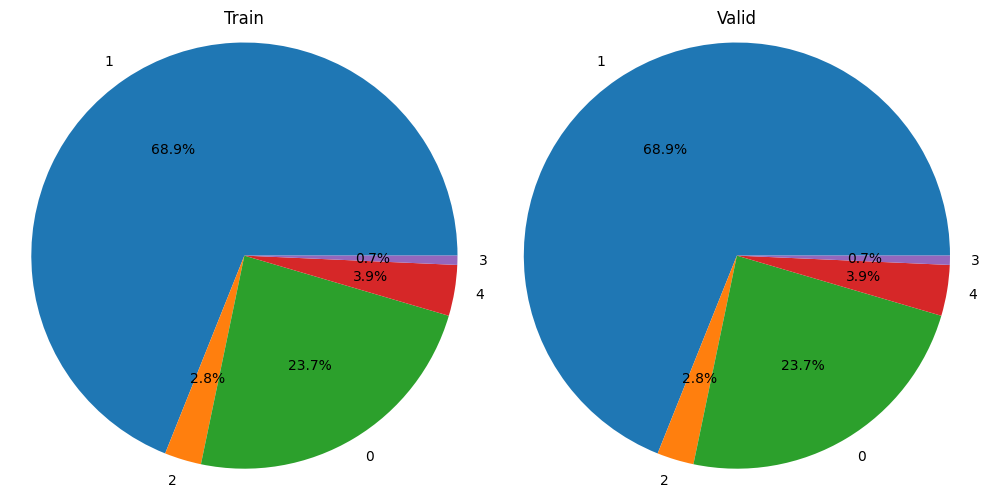

In [ ]:
train_counter = Counter(train_input[:,0,1])
valid_counter = Counter(val_input[:,0,1])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.pie(train_counter.values(), labels=[int(x) for x in train_counter.keys()], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Train')

plt.subplot(1,2,2)
plt.pie(valid_counter.values(), labels=[int(x) for x in valid_counter.keys()], autopct='%1.1f%%')
plt.axis('equal')
plt.title('Valid')

plt.tight_layout()
plt.show()

In [ ]:
print(train_input.shape, train_target.shape, val_input.shape, val_target.shape)

(190680, 336, 7) (190680, 21) (47670, 336, 7) (47670, 21)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

### Modeling

#### Model Classes

In [ ]:
class moving_avg(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            noisy_x = x + noise
            return noisy_x
        return x

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.pe[:x.size(0), :]
        return self.dropout(x)


class TSTEmbedding(nn.Module):
    def __init__(self, num_categories, hidden_size, num_time_steps, kernel_size):
        super(TSTEmbedding, self).__init__()

        self.noise_layer = GaussianNoiseLayer(stddev=0.1)

        self.decompsition = series_decomp(kernel_size)
        self.linear_trend = nn.Linear(2, hidden_size)
        self.linear_seasonal = nn.Linear(2, hidden_size)

        self.embedding = nn.Embedding(num_categories, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        category_input, time_series_input = x[:, :, :5], x[:, :, 5:]

        time_series_input = self.noise_layer(time_series_input)
        trend_init, seasonal_init = self.decompsition(time_series_input)

        trend_embedded = self.linear_trend(trend_init)
        seasonal_embedded = self.linear_seasonal(seasonal_init)

        time_series_embedded = trend_embedded + seasonal_embedded
        position_encoded = self.positional_encoding(time_series_embedded)

        category_embedded = self.embedding(category_input.long()).sum(dim=2)
        x = category_embedded + time_series_embedded + position_encoded

        return self.dropout(x)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_categories, num_time_steps, num_features, num_heads, hidden_size, num_layers, num_output_days, dropout_rate=0.3,kernel_size=25):
        super(TimeSeriesTransformer, self).__init__()

        self.decompsition = series_decomp(kernel_size)

        self.embedding = nn.Embedding(num_categories, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size * 5, num_time_steps)  # 수정

        encoder_layer = nn.TransformerEncoderLayer(hidden_size * 5 + 4, num_heads, dim_feedforward=hidden_size, dropout=dropout_rate)  # dropout 추가
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc = nn.Linear((hidden_size * 5 + 4) * num_time_steps, num_output_days)

    def forward(self, x):
        category_input, time_series_input = x[:, :, :5], x[:, :, 5:]

        # time_series_input[:,:,0] *= 0.9
        # time_series_input[:,:,1] *= 0.1

        trend_init, seasonal_init = self.decompsition(time_series_input)

        time_series_decompose_input = torch.cat([trend_init, seasonal_init], dim=-1)

        category_embedded = self.embedding(category_input.long()).view(x.size(0),x.size(1),-1)

        position_encoded = self.positional_encoding(category_embedded)

        x = category_embedded + position_encoded

        x = torch.cat([x, time_series_decompose_input], dim=-1)

        x = self.transformer_encoder(x).view(x.size(0),-1)

        x = self.fc(x)

        return x

In [ ]:
class TimeSeriesTransformerV2(nn.Module):
    def __init__(self, num_categories, num_time_steps, num_features, num_heads, hidden_size, num_layers, num_output_days, dropout_rate=0.3, kernel_size=25):
        super(TimeSeriesTransformerV2, self).__init__()

        self.data_embedding = TSTEmbedding(num_categories, hidden_size, num_time_steps, kernel_size)

        encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout_rate, activation='relu')
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * num_time_steps, hidden_size),
            nn.Linear(hidden_size, num_output_days)
        )

    def forward(self, x):
        x = self.data_embedding(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

    def add_min_by_row(self, x):
        # x shape is [batch_size, num_output_days]
        min_x = torch.min(x, axis=1).values
        # min_x = torch.where(min_x > 0, 0, min_x) # 0 이상의 값들은 min addition을 안한다.
        min_x = torch.abs(min_x).unsqueeze(1)
        return x + min_x

#### Model Initialize

In [ ]:
num_categories = train_data["브랜드"].max()+1
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_features = 5
num_heads = 12
hidden_size = 256
num_layers = 4
num_output_days = CFG.PREDICT_SIZE
dropout_rate = 0.5
kernel_size = 25

In [ ]:
model = TimeSeriesTransformer(
    num_categories,
    num_time_steps,
    num_features,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days,
    dropout_rate,
    kernel_size
)

model = model.to(device)

In [ ]:
num_categories = train_data["브랜드"].max()+1
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_features = 5
num_heads = 4
hidden_size = 256
num_layers = 2
num_output_days = CFG.PREDICT_SIZE
dropout_rate = 0.3
kernel_size = 25

In [ ]:
model = TimeSeriesTransformerV2(
    num_categories,
    num_time_steps,
    num_features,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days,
    dropout_rate,
    kernel_size
)

model = model.to(device)

In [ ]:
path = f'./model/dk_kim_model_params{num_categories, num_time_steps, num_features, num_heads, hidden_size, num_layers, num_output_days, dropout_rate, kernel_size}_V2_only_gaussian'

if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
num_epochs = CFG.EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)

total_steps = len(train_loader) * num_epochs

criterion = nn.MSELoss()
huberloss = nn.HuberLoss()

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#### Training Functions

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    lr_adjust = {epoch: CFG.LEARNING_RATE * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [ ]:
def PSFALoss(pred, target):
    PSFA = torch.zeros(1, requires_grad=True).to(device)
    for day in range(CFG.PREDICT_SIZE):
        total_sell = torch.sum(target[:, day])
        pred_values = pred[:, day]
        target_values = target[:, day]

        denominator = torch.maximum(target_values, pred_values)
        diffs = torch.where(denominator!=0, torch.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell
        else:
            sell_weights = torch.ones_like(target_values) / len(target_values)

        if not torch.isnan(diffs).any():
            PSFA += torch.sum(diffs * sell_weights) / 21

    return PSFA

In [ ]:
def PSFA_valid(pred, target):
    PSFA = 1
    for day in range(CFG.PREDICT_SIZE):
        total_sell = np.sum(target[:, day]) # day별 총 판매량
        pred_values = pred[:, day] # day별 예측 판매량
        target_values = target[:, day] # day별 실제 판매량

        # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
        denominator = np.maximum(target_values, pred_values)
        diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
        else:
            sell_weights = np.ones_like(target_values) / len(target_values)  # 1 / len(ids)로 대체

        if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
            PSFA -= np.sum(diffs * sell_weights) / 21

    return PSFA

In [ ]:
indexs_bigcat={}
for bigcat in train_data['대분류'].unique():
    indexs_bigcat[bigcat] = list(train_data.loc[train_data['대분류']==bigcat].index)

def PSFA(pred, target):
    PSFA = 1
    for cat in range(5):
        ids = indexs_bigcat[cat]
        for day in range(CFG.PREDICT_SIZE):
            total_sell = np.sum(target[ids, day]) # day별 총 판매량
            pred_values = pred[ids, day] # day별 예측 판매량
            target_values = target[ids, day] # day별 실제 판매량

            # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
            denominator = np.maximum(target_values, pred_values)
            diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

            if total_sell != 0:
                sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
            else:
                sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

            if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
                PSFA -= np.sum(diffs * sell_weights) / (21 * 5)

    return PSFA

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            model=model.to(device)
            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
def train_model(model, train_loader, optimizer=optimizer, scheduler=None, device=device, iteration_print=200, huber_back=False):
    train_loss = 0.0
    huber_loss = 0.0
    psfa_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    for i, (batch_input, batch_target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        loss = criterion(outputs, batch_target)
        huber = huberloss(outputs, batch_target)
        psfa = PSFALoss(outputs, batch_target)

        if huber_back:
            huber.backward()
        else:
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()
        huber_loss += huber.item()
        psfa_loss += psfa.item()

        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f} ; Huber Loss : {huber.item():.4f} ; PSFA Loss : {psfa.item():.4f}')

    avg_train_loss = train_loss/len(train_loader)
    avg_huber_loss = huber_loss/len(train_loader)
    avg_psfa_loss = psfa_loss/len(train_loader)
    print(f'Train MSE Loss: {avg_train_loss:.4f} ; Huber Loss: {avg_huber_loss:.4f} ; PSFA Loss: {avg_psfa_loss:.4f}')

    if huber_back:
        return avg_huber_loss

    return avg_train_loss

def validate_model(model, val_loader, device=device):
    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    preds = []
    targets = []

    with torch.no_grad():
        for batch_input, batch_target in tqdm(val_loader):
            targets.extend(batch_target.numpy())

            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            outputs = model(batch_input)
            loss = criterion(outputs, batch_target)
            val_loss += loss.item()

            preds.extend(outputs.detach().cpu().numpy())

    preds, targets = np.array(preds), np.array(targets)
    preds_min = preds.copy()
    preds_mean = preds.copy()

    for i in range(preds.shape[0]):
        min_val = abs(preds[i].min())
        preds_min[i] += min_val
        mean_val = np.mean(preds_min[i]).astype(int)
        preds_mean[i] += min_val + mean_val

    val_psfa = PSFA_valid(preds, targets)
    val_min_psfa = PSFA_valid(preds_min, targets)
    val_mean_psfa = PSFA_valid(preds_mean, targets)

    avg_val_loss = val_loss/len(val_loader)
    print(f'Val PSFA: {val_psfa:.4f} ; Min PSFA: {val_min_psfa:.4f} ; Min Mean PSFA: {val_mean_psfa:.4f} ; Loss: {avg_val_loss:.4f}')

    val_psfa = max(val_psfa, val_min_psfa, val_mean_psfa)

    return val_psfa, avg_val_loss

In [ ]:
def test_model(model, test_loader, our_best, device, normalizer=False):
    print('Test Mode', end=" ")
    pred = inference(model, test_loader, device)

    if normalizer:
        pred *= norm_weight
    else:
        pred = sc_main.inverse_transform(pred.T).T
    pred = np.round(pred, 0).astype(int)

    pred_min = pred.copy()
    pred_min_mean = pred.copy()

    for i in range(pred.shape[0]):
        min_val = abs(pred[i].min())
        pred_min[i] += min_val
        mean_val = np.mean(pred_min[i]).astype(int)
        pred_min_mean[i] += min_val + mean_val

    test_psfa_basic = PSFA(pred, our_best)
    test_psfa_min = PSFA(pred_min, our_best)
    test_psfa_mean_min = PSFA(pred_min_mean, our_best)

    print(f'Test PSFA Acc Basic: {test_psfa_basic:.4f} ; Min: {test_psfa_min:.4f} ; Mean: {test_psfa_mean_min:.4f}')

    test_acc_basic = sum(sum(pred==our_best))/(our_best.shape[0] * our_best.shape[1])
    test_acc_min = sum(sum(pred_min==our_best))/(our_best.shape[0] * our_best.shape[1])
    test_acc_mean_min = sum(sum(pred_min_mean==our_best))/(our_best.shape[0] * our_best.shape[1])

    print(f'Test Perfect Acc Basic: {test_acc_basic:.4f} ; Min: {test_acc_min:.4f} ; Mean: {test_acc_mean_min:.4f}')

    current_test_psfa = max(test_psfa_basic, test_psfa_min, test_psfa_mean_min)
    current_test_acc = max(test_acc_basic, test_acc_min, test_acc_mean_min)

    return current_test_psfa, current_test_acc

In [ ]:
def save_best_model(avg_val_acc, avg_val_loss, current_test_acc, current_test_psfa, best_acc, best_loss, best_test_acc, best_test_psfa, path=path):
    if best_acc <= avg_val_acc:
        print(f'Save Model: {best_acc:.4f} -> {avg_val_acc:.4f}')
        best_acc = avg_val_acc
        torch.save(model.state_dict(), os.path.join(path,'val_acc.pth'))

    if best_loss >= avg_val_loss:
        print(f'Save Model: {best_loss:.4f} -> {avg_val_loss:.4f}')
        best_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(path,'val_loss.pth'))

    if best_test_psfa <= current_test_psfa:
        print(f'Save Model: {best_test_psfa:.4f} -> {current_test_psfa:.4f}')
        best_test_psfa = current_test_psfa
        torch.save(model.state_dict(), os.path.join(path,'test_psfa.pth'))

    if best_test_acc <= current_test_acc:
        print(f'Save Model: {best_test_acc:.4f} -> {current_test_acc:.4f}')
        best_test_acc = current_test_acc
        torch.save(model.state_dict(), os.path.join(path,'test_acc.pth'))

    return best_acc, best_loss, best_test_acc, best_test_psfa

#### Train Model

In [ ]:
our_best = pd.read_csv('./open/p2_best.csv')
our_best = our_best.iloc[:,1:].values

In [ ]:
best_acc, best_loss = 0.0, np.inf
best_test_acc, best_test_psfa = 0.0, 0.0

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    avg_train_loss = train_model(model, train_loader, optimizer, None, device, 100, huber_back=False)
    avg_val_acc, avg_val_loss = validate_model(model, val_loader, device)

    adjust_learning_rate(optimizer, epoch + 1)

    current_test_psfa, current_test_acc = test_model(model, test_loader, our_best, device, normalizer=False)
    best_acc, best_loss, best_test_acc, best_test_psfa = save_best_model(avg_val_acc, avg_val_loss, current_test_acc, current_test_psfa, best_acc, best_loss, best_test_acc, best_test_psfa)

Epoch [1/10]
Train Mode 

  0%|          | 0/1490 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.3214 ; Huber Loss : 0.1571 ; PSFA Loss : 1.1712
Iteration 200 MSE Loss : 0.1927 ; Huber Loss : 0.0959 ; PSFA Loss : 1.4084
Iteration 300 MSE Loss : 0.1127 ; Huber Loss : 0.0563 ; PSFA Loss : 0.8563
Iteration 400 MSE Loss : 0.0745 ; Huber Loss : 0.0372 ; PSFA Loss : 0.7576
Iteration 500 MSE Loss : 0.0628 ; Huber Loss : 0.0314 ; PSFA Loss : 0.9800
Iteration 600 MSE Loss : 0.0364 ; Huber Loss : 0.0182 ; PSFA Loss : 0.7889
Iteration 700 MSE Loss : 0.0410 ; Huber Loss : 0.0205 ; PSFA Loss : 0.8763
Iteration 800 MSE Loss : 0.0355 ; Huber Loss : 0.0178 ; PSFA Loss : 0.8395
Iteration 900 MSE Loss : 0.0295 ; Huber Loss : 0.0147 ; PSFA Loss : 0.7810
Iteration 1000 MSE Loss : 0.0337 ; Huber Loss : 0.0168 ; PSFA Loss : 0.5352
Iteration 1100 MSE Loss : 0.0314 ; Huber Loss : 0.0157 ; PSFA Loss : 0.6890
Iteration 1200 MSE Loss : 0.0319 ; Huber Loss : 0.0159 ; PSFA Loss : 0.7228
Iteration 1300 MSE Loss : 0.0302 ; Huber Loss : 0.0151 ; PSFA Loss : 0.6104
Iteration 1400 MSE Lo

  0%|          | 0/373 [00:00<?, ?it/s]

Val PSFA: 0.3886 ; Min PSFA: 0.5141 ; Min Mean PSFA: 0.5141 ; Loss: 0.0274
Updating learning rate to 0.0001
Test Mode 

  0%|          | 0/125 [00:00<?, ?it/s]

Test PSFA Acc Basic: 0.1508 ; Min: 0.4570 ; Mean: 0.4958
Test Perfect Acc Basic: 0.2920 ; Min: 0.2207 ; Mean: 0.1864
Save Model: 0.0000 -> 0.5141
Save Model: inf -> 0.0274
Save Model: 0.0000 -> 0.4958
Save Model: 0.0000 -> 0.2920
Epoch [2/10]
Train Mode 

  0%|          | 0/1490 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0215 ; Huber Loss : 0.0108 ; PSFA Loss : 0.5985
Iteration 200 MSE Loss : 0.0185 ; Huber Loss : 0.0092 ; PSFA Loss : 0.5893
Iteration 300 MSE Loss : 0.0191 ; Huber Loss : 0.0095 ; PSFA Loss : 0.6388
Iteration 400 MSE Loss : 0.0166 ; Huber Loss : 0.0083 ; PSFA Loss : 0.5549
Iteration 500 MSE Loss : 0.0260 ; Huber Loss : 0.0130 ; PSFA Loss : 0.5439
Iteration 600 MSE Loss : 0.0243 ; Huber Loss : 0.0121 ; PSFA Loss : 0.6076
Iteration 700 MSE Loss : 0.0192 ; Huber Loss : 0.0096 ; PSFA Loss : 0.5159
Iteration 800 MSE Loss : 0.0212 ; Huber Loss : 0.0106 ; PSFA Loss : 0.6809
Iteration 900 MSE Loss : 0.0224 ; Huber Loss : 0.0112 ; PSFA Loss : 0.5965
Iteration 1000 MSE Loss : 0.0172 ; Huber Loss : 0.0086 ; PSFA Loss : 0.5391
Iteration 1100 MSE Loss : 0.0227 ; Huber Loss : 0.0113 ; PSFA Loss : 0.5151
Iteration 1200 MSE Loss : 0.0185 ; Huber Loss : 0.0092 ; PSFA Loss : 0.5958
Iteration 1300 MSE Loss : 0.0213 ; Huber Loss : 0.0106 ; PSFA Loss : 0.5587
Iteration 1400 MSE Lo

  0%|          | 0/373 [00:00<?, ?it/s]

Val PSFA: 0.4398 ; Min PSFA: 0.5215 ; Min Mean PSFA: 0.5214 ; Loss: 0.0223
Updating learning rate to 5e-05
Test Mode 

  0%|          | 0/125 [00:00<?, ?it/s]

Test PSFA Acc Basic: 0.2205 ; Min: 0.4152 ; Mean: 0.5060
Test Perfect Acc Basic: 0.4141 ; Min: 0.3941 ; Mean: 0.3602
Save Model: 0.5141 -> 0.5215
Save Model: 0.0274 -> 0.0223
Save Model: 0.4958 -> 0.5060
Save Model: 0.2920 -> 0.4141
Epoch [3/10]
Train Mode 

  0%|          | 0/1490 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0152 ; Huber Loss : 0.0076 ; PSFA Loss : 0.4685
Iteration 200 MSE Loss : 0.0156 ; Huber Loss : 0.0078 ; PSFA Loss : 0.5072
Iteration 300 MSE Loss : 0.0219 ; Huber Loss : 0.0110 ; PSFA Loss : 0.5298
Iteration 400 MSE Loss : 0.0193 ; Huber Loss : 0.0097 ; PSFA Loss : 0.5504
Iteration 500 MSE Loss : 0.0246 ; Huber Loss : 0.0123 ; PSFA Loss : 0.5066
Iteration 600 MSE Loss : 0.0182 ; Huber Loss : 0.0091 ; PSFA Loss : 0.5002
Iteration 700 MSE Loss : 0.0157 ; Huber Loss : 0.0078 ; PSFA Loss : 0.5346
Iteration 800 MSE Loss : 0.0194 ; Huber Loss : 0.0097 ; PSFA Loss : 0.5627
Iteration 900 MSE Loss : 0.0164 ; Huber Loss : 0.0082 ; PSFA Loss : 0.5012
Iteration 1000 MSE Loss : 0.0145 ; Huber Loss : 0.0072 ; PSFA Loss : 0.5112
Iteration 1100 MSE Loss : 0.0134 ; Huber Loss : 0.0067 ; PSFA Loss : 0.4379
Iteration 1200 MSE Loss : 0.0186 ; Huber Loss : 0.0093 ; PSFA Loss : 0.5849
Iteration 1300 MSE Loss : 0.0160 ; Huber Loss : 0.0080 ; PSFA Loss : 0.5311
Iteration 1400 MSE Lo

  0%|          | 0/373 [00:00<?, ?it/s]

Val PSFA: 0.4777 ; Min PSFA: 0.5414 ; Min Mean PSFA: 0.5413 ; Loss: 0.0223
Updating learning rate to 2.5e-05
Test Mode 

  0%|          | 0/125 [00:00<?, ?it/s]

Test PSFA Acc Basic: 0.2928 ; Min: 0.4513 ; Mean: 0.5304
Test Perfect Acc Basic: 0.4272 ; Min: 0.4227 ; Mean: 0.3930
Save Model: 0.5215 -> 0.5414
Save Model: 0.0223 -> 0.0223
Save Model: 0.5060 -> 0.5304
Save Model: 0.4141 -> 0.4272
Epoch [4/10]
Train Mode 

  0%|          | 0/1490 [00:00<?, ?it/s]

Iteration 100 MSE Loss : 0.0210 ; Huber Loss : 0.0105 ; PSFA Loss : 0.4819
Iteration 200 MSE Loss : 0.0168 ; Huber Loss : 0.0084 ; PSFA Loss : 0.5532
Iteration 300 MSE Loss : 0.0199 ; Huber Loss : 0.0100 ; PSFA Loss : 0.5219
Iteration 400 MSE Loss : 0.0150 ; Huber Loss : 0.0075 ; PSFA Loss : 0.5370
Iteration 500 MSE Loss : 0.0155 ; Huber Loss : 0.0078 ; PSFA Loss : 0.5519
Iteration 600 MSE Loss : 0.0132 ; Huber Loss : 0.0066 ; PSFA Loss : 0.4869
Iteration 700 MSE Loss : 0.0188 ; Huber Loss : 0.0094 ; PSFA Loss : 0.5022
Iteration 800 MSE Loss : 0.0144 ; Huber Loss : 0.0072 ; PSFA Loss : 0.4871
Iteration 900 MSE Loss : 0.0177 ; Huber Loss : 0.0088 ; PSFA Loss : 0.4952
Iteration 1000 MSE Loss : 0.0123 ; Huber Loss : 0.0061 ; PSFA Loss : 0.5067
Iteration 1100 MSE Loss : 0.0208 ; Huber Loss : 0.0104 ; PSFA Loss : 0.5409


KeyboardInterrupt: ignored

#### Prediction

In [ ]:
model.load_state_dict(torch.load(os.path.join(path,'val_loss.pth')))

<All keys matched successfully>

In [ ]:
pred = inference(model, test_loader, device)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
pred = sc_main.inverse_transform(pred.T).T
# pred *= norm_weight
pred = np.round(pred, 0).astype(int)

In [ ]:
pred_min = pred.copy()
pred_min_mean = pred.copy()

for i in range(pred.shape[0]):
    min_val = abs(pred[i].min())
    pred_min[i] += min_val
    mean_val = np.mean(pred_min[i]).astype(int)
    pred_min_mean[i] += min_val + mean_val

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')
submit.iloc[:,1:] = pred_min
submit

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
3,3,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,4,5,5,5,5,5,6,4,5,5,...,5,5,4,5,5,4,4,4,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,21,20,20,20,21,23,18,22,21,...,22,20,17,20,21,18,18,16,23,20
15886,15886,4,4,4,4,5,5,4,5,4,...,5,4,4,4,4,4,4,4,5,4
15887,15887,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,2,4,3
15888,15888,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [ ]:
submit.to_csv(os.path.join(path, 'val_loss_min_addition.csv'), index=False)

## 변형

### Tools

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0:
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    >
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]):
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

### Data

In [ ]:
train_data = pd.read_csv('./data/new_train_round.csv')#.drop(columns=['ID','제품'])

In [ ]:
train_data

,ID,가격,제품,대분류,중분류,소분류,브랜드,2022-01-01,2022-01-02,2022-01-03,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,0,5500,B002-00001-00001,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,24300,B002-00002-00001,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,...,0,0,0,1,3,2,0,0,2,0
2,2,11800,B002-00002-00002,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,4000,B002-00002-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,5100,B002-00003-00001,B002-C001-0001,B002-C002-0001,B002-C003-0003,B002-00003,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,1900,B002-03799-00002,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15886,15886,21800,B002-03799-00003,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,...,0,0,0,3,0,2,4,1,1,3
15887,15887,11700,B002-03799-00004,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,12500,B002-03799-00005,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [ ]:
train_data_2022 = train_data.loc[:,:'2022-12-31']
train_data_2023 = pd.concat([train_data.iloc[:,:5], train_data.loc[:,'2023-01-01':]], axis=1)

In [ ]:
train_data_keyword_cnt = pd.read_csv('./data/brand_keyword_cnt.csv').fillna(0)

In [ ]:
sc_main_2022 = MinMaxScaler()
sc_main_2023 = MinMaxScaler()

train_data_2022.iloc[:, 5:] = sc_main_2022.fit_transform(train_data_2022.iloc[:,5:].values.T).T
train_data_2023.iloc[:, 5:] = sc_main_2023.fit_transform(train_data_2023.iloc[:,5:].values.T).T

sc_brand = MinMaxScaler()

train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values.T).T

In [ ]:
label_encoder = LabelEncoder()
categorical_columns = ['가격', '대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])
    train_data_2022[col] = label_encoder.transform(train_data_2022[col])
    train_data_2023[col] = label_encoder.transform(train_data_2023[col])

In [ ]:
all_dates = pd.DataFrame(
        columns=['date'],
        data=train_data.columns[5:]
  )

date_stamps = time_features(all_dates, timeenc=1, freq='d')

In [ ]:
# 띄엄띄엄 넣기
def make_train_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE, STEP_SIZE=7):
    brand_labels = label_encoder.classes_

    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :5]) + 2))
    input_mark = np.empty((num_rows * adjusted_size, train_size, 3))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])

        # brand_name = make_brand_name(data.iloc[i,4]+1)
        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            window_dates = date_stamps[j:j+train_size]
            keyword_window=keyword_data[j : j + window_size]

            keyword_temp = keyword_window[:train_size]

            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data = np.column_stack((temp_data, keyword_temp))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            input_mark[(j // STEP_SIZE) * num_rows + i] = window_dates
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]

    return input_data, input_mark, target_data

In [ ]:
def make_predict_data(data, train_size=CFG.TRAIN_WINDOW_SIZE):
    num_rows = len(data)
    brand_labels = label_encoder.classes_

    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :5]) + 2))
    input_mark = np.empty((num_rows, train_size, 3))

    for i in tqdm(range(num_rows)):
        sales_data = np.array(data.iloc[i, 5:])
        encode_info = np.array(data.iloc[i, :5])

        # brand_name = make_brand_name(data.iloc[i,4]+1)
        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        window = sales_data[-train_size : ]
        window_dates = date_stamps[-train_size:]
        keyword_window=keyword_data[-train_size : ]

        keyword_temp = keyword_window[:train_size]

        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        temp_data=np.column_stack((temp_data,keyword_temp))
        input_data[i] = temp_data
        input_mark[i] = window_dates

    return input_data, input_mark

In [ ]:
train_input_2022, train_mark_2022, train_target_2022 = make_train_data(train_data_2022)
train_input_2023, train_mark_2023, train_target_2023 = make_train_data(train_data_2023, STEP_SIZE=1)

  0%|          | 0/15890 [00:00<?, ?it/s]

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
test_input, test_mark = make_predict_data(train_data)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input_2022.shape, train_mark_2022.shape, train_target_2022.shape, train_input_2023.shape, train_mark_2023.shape, train_target_2023.shape)

(651490, 63, 7) (651490, 63, 3) (651490, 21) (254240, 63, 7) (254240, 63, 3) (254240, 21)


In [ ]:
# Stratified Train Val Split (By 대분류)
skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(train_input_2022, y=train_input_2022[:,0,1])):
    if i == fold:
        val_input_2022 = train_input_2022[val_idxs]
        val_mark_2022 = train_mark_2022[val_idxs]
        val_target_2022 = train_target_2022[val_idxs]

        train_input_2022 = train_input_2022[train_idxs]
        train_mark_2022 = train_mark_2022[train_idxs]
        train_target_2022 = train_target_2022[train_idxs]
        break

In [ ]:
# Stratified Train Val Split (By 대분류)
skf = StratifiedKFold(n_splits=5)
fold = np.random.choice(5)

for i, (train_idxs, val_idxs) in enumerate(skf.split(train_input_2023, y=train_input_2023[:,0,1])):
    if i == fold:
        val_input_2023 = train_input_2023[val_idxs]
        val_mark_2023 = train_mark_2023[val_idxs]
        val_target_2023 = train_target_2023[val_idxs]

        train_input_2023 = train_input_2023[train_idxs]
        train_mark_2023 = train_mark_2023[train_idxs]
        train_target_2023 = train_target_2023[train_idxs]
        break

In [ ]:
print(train_input.shape, train_mark.shape, train_target.shape, val_input.shape, val_mark.shape, val_target.shape)

(572040, 126, 7) (572040, 126, 3) (572040, 21) (143010, 126, 7) (143010, 126, 3) (143010, 21)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, X_mark, Y):
        self.X = X
        self.X_mark = X_mark
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_mark, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_mark, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
train_dataset = CustomDataset(train_input_2022, train_mark_2022, train_target_2022)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input_2022, val_mark_2022, val_target_2022)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
train_dataset = CustomDataset(train_input_2023, train_mark_2023, train_target_2023)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input_2023, val_mark_2023, val_target_2023)
val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
test_dataset = CustomDataset(test_input, test_mark, None)
test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

### Model

#### Model Class

In [ ]:
time_size=2

In [ ]:
class MovingAverageLayer(torch.nn.Module):
    def __init__(self, kernel_size, stride):
        super(MovingAverageLayer, self).__init__()
        self.kernel_size = kernel_size
        print(kernel_size)
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class SeriesDecomp(torch.nn.Module):
    def __init__(self, kernel_size):
        super(SeriesDecomp, self).__init__()
        self.moving_avg = MovingAverageLayer(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

In [ ]:
import copy

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))


class TransformerEncoderBN(nn.Module):
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoderBN, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerEncoderLayerBN(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayerBN, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.BatchNorm1d(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayerBN, self).__setstate__(state)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src.permute(0,2,1)).transpose(1,2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            noisy_x = x + noise
            return noisy_x
        return x

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x


class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

In [ ]:
class TSTEmbedding(nn.Module):
    def __init__(self, num_categories, hidden_size, num_time_steps, kernel_size):
        super(TSTEmbedding, self).__init__()

        self.noise_layer = GaussianNoiseLayer(stddev=0.1)

        self.decompsition = SeriesDecomp(kernel_size)
        self.time_embedding = TokenEmbedding(2, hidden_size)

        self.embedding = nn.Embedding(num_categories, hidden_size)
        self.date_embedding = TimeFeatureEmbedding(hidden_size, embed_type='timeF', freq='d')

        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

    def forward(self, x, x_mark=None):
        category_input, time_series_input = x[:, :, :5], x[:, :, -2:]

        # time_series_input = self.noise_layer(time_series_input)
        mvavg, rsd = self.decompsition(time_series_input)
        time_series_embedded = self.time_embedding(rsd)

        category_embedded = self.embedding(category_input.long()).sum(dim=2)
        x = category_embedded + time_series_embedded

        if torch.is_tensor(x_mark):
            date_embedded = self.date_embedding(x_mark)
            x += date_embedded

        x = self.positional_encoding(x)

        return x

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_time_steps, num_heads, hidden_size, num_layers, num_output_days, kernel_size=25, size=(7839, 5, 11, 53, 3799), batch_size=CFG.BATCH_SIZE):
        super(TimeSeriesTransformer, self).__init__()

        # Embeddings
        num_categories = max(size)
        self.embedding = TSTEmbedding(num_categories, hidden_size, num_time_steps, kernel_size)

        # BN
        encoder_layer = TransformerEncoderLayerBN(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=0.1, activation='gelu')
        self.transformer_encoder = TransformerEncoderBN(encoder_layer, num_layers)

        self.fc1 = nn.Linear(hidden_size, 1)
        self.fc2 = nn.Linear(num_time_steps, num_output_days)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x, x_mark=None, epoch=3):
        x = self.embedding(x, x_mark)

        x = self.transformer_encoder(x)

        x = self.dropout(self.fc1(x)).squeeze(-1)
        x = self.fc2(x)
        # if epoch > 2:
        #     x = self.relu(x)
        return x


#### Model Initialize

In [ ]:
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_heads = 4
hidden_size = 512
num_layers = 4
num_output_days = CFG.PREDICT_SIZE
mvg_kernel_size=25
cat_size = (
    train_data_2022['가격'].max()+1,
    train_data_2022['대분류'].max()+1,
    train_data_2022['중분류'].max()+1,
    train_data_2022['소분류'].max()+1,
    train_data_2022['브랜드'].max()+1
)

In [ ]:
path = f'./model/2023-09-06-1835'

if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
model = TimeSeriesTransformer(
    num_time_steps,
    num_heads,
    hidden_size,
    num_layers,
    num_output_days,
    mvg_kernel_size,
    cat_size
)

model = model.to(device)

25


In [ ]:
num_epochs = CFG.EPOCHS

optimizer = optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)
criterion = nn.MSELoss()
huberloss = nn.HuberLoss()

#### Model Functions

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    lr_adjust = {epoch: CFG.LEARNING_RATE * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [ ]:
def PSFALoss(pred, target):

    PSFA = torch.zeros(1).float().to(device)

    for day in range(CFG.PREDICT_SIZE):
        total_sell = torch.sum(target[:, day])
        pred_values = pred[:, day]
        target_values = target[:, day]

        denominator = torch.maximum(target_values, pred_values)
        diffs = torch.where(denominator!=0, torch.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell
        else:
            sell_weights = torch.ones_like(target_values) / len(target_values)

        if not torch.isnan(diffs).any():
            PSFA += torch.sum(diffs * sell_weights) / CFG.PREDICT_SIZE

    return PSFA

In [ ]:
def PSFA_valid(pred, target):
    PSFA = 1
    for day in range(CFG.PREDICT_SIZE):
        total_sell = np.sum(target[:, day]) # day별 총 판매량
        pred_values = pred[:, day] # day별 예측 판매량
        target_values = target[:, day] # day별 실제 판매량

        # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
        denominator = np.maximum(target_values, pred_values)
        diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
        else:
            sell_weights = np.ones_like(target_values) / len(ids)  # 1 / len(ids)로 대체

        if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
            PSFA -= np.sum(diffs * sell_weights) / 21

    return PSFA

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X, X_mark in tqdm(iter(test_loader)):
            X = X.to(device)
            X_mark = X_mark.to(device)

            model=model.to(device)
            output = model(X, X_mark)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
def train_model(model, train_loader, optimizer=optimizer, scheduler=None, device=device, iteration_print=200):
    train_loss = 0.0
    huber_loss = 0.0
    psfa_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()
    nb_step = 0

    for i, (batch_input, batch_input_mark, batch_target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        if batch_input.size(0) != CFG.BATCH_SIZE:
            pass

        batch_input = batch_input.to(device)
        batch_input_mark = batch_input_mark.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input, batch_input_mark)
        loss = criterion(outputs, batch_target)
        huber = huberloss(outputs, batch_target)
        psfa = PSFALoss(outputs, batch_target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()
        huber_loss += huber.item()
        psfa_loss += psfa.item()

        nb_step += 1

        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f} ; Huber Loss : {huber.item():.4f} ; PSFA Loss : {psfa.item():.4f}')

    avg_train_loss = train_loss/nb_step
    avg_huber_loss = huber_loss/nb_step
    avg_psfa_loss = psfa_loss/nb_step
    print(f'Train MSE Loss: {avg_train_loss:.4f} ; Huber Loss: {avg_huber_loss:.4f} ; PSFA Loss: {avg_psfa_loss:.4f}')

    return avg_train_loss

def validate_model(model, val_loader, device=device):
    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    preds = []
    targets = []
    nb_step = 0

    with torch.no_grad():
        for batch_input, batch_input_mark, batch_target in tqdm(val_loader):
            targets.extend(batch_target.numpy())
            if batch_input.size(0) != CFG.BATCH_SIZE:
                pass

            batch_input = batch_input.to(device)
            batch_input_mark = batch_input_mark.to(device)
            batch_target = batch_target.to(device)

            outputs = model(batch_input, batch_input_mark)
            loss = criterion(outputs, batch_target)
            val_loss += loss.item()

            preds.extend(outputs.detach().cpu().numpy())

            nb_step += 1

    preds, targets = np.array(preds), np.array(targets)
    preds_min = preds.copy()

    for i in range(preds.shape[0]):
        min_val = abs(preds[i].min())
        preds_min[i] += min_val

    val_psfa = PSFA_valid(preds, targets)
    val_min_psfa = PSFA_valid(preds_min, targets)

    avg_val_loss = val_loss/nb_step
    # print(f'Val MSE Loss: {avg_val_loss:.4f}')
    print(f'Val PSFA: {val_psfa:.4f} ; Min PSFA: {val_min_psfa:.4f} ; Loss: {avg_val_loss:.4f}')

    val_psfa = max(val_psfa, val_min_psfa)

    return val_psfa, avg_val_loss

In [ ]:
def save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, path=path):
    if best_acc <= avg_val_acc:
        print(f'Save Model: {best_acc:.4f} -> {avg_val_acc:.4f}')
        best_acc = avg_val_acc
        torch.save(model.state_dict(), os.path.join(path,'val_acc.pth'))

    if best_loss >= avg_val_loss:
        print(f'Save Model: {best_loss:.4f} -> {avg_val_loss:.4f}')
        best_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(path,'val_loss.pth'))

    return best_acc, best_loss

#### Train

In [ ]:
best_acc, best_loss = 0.0, np.inf

for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    avg_train_loss = train_model(model, train_loader, optimizer, None, device, 10)
    avg_psfa_acc, avg_val_loss = validate_model(model, val_loader, device)
    adjust_learning_rate(optimizer, epoch + 1)
    best_acc, best_loss = save_best_model(avg_psfa_acc, avg_val_loss, best_acc, best_loss)

Epoch [1/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0188 ; Huber Loss : 0.0094 ; PSFA Loss : 0.5309
Iteration 20 MSE Loss : 0.0184 ; Huber Loss : 0.0092 ; PSFA Loss : 0.4114
Iteration 30 MSE Loss : 0.0222 ; Huber Loss : 0.0111 ; PSFA Loss : 0.5553
Iteration 40 MSE Loss : 0.0183 ; Huber Loss : 0.0091 ; PSFA Loss : 0.4192
Iteration 50 MSE Loss : 0.0145 ; Huber Loss : 0.0073 ; PSFA Loss : 0.4677
Iteration 60 MSE Loss : 0.0127 ; Huber Loss : 0.0063 ; PSFA Loss : 0.5626
Iteration 70 MSE Loss : 0.0151 ; Huber Loss : 0.0075 ; PSFA Loss : 0.4933
Iteration 80 MSE Loss : 0.0147 ; Huber Loss : 0.0073 ; PSFA Loss : 0.6218
Iteration 90 MSE Loss : 0.0141 ; Huber Loss : 0.0071 ; PSFA Loss : 0.5484
Iteration 100 MSE Loss : 0.0108 ; Huber Loss : 0.0054 ; PSFA Loss : 0.5240
Iteration 110 MSE Loss : 0.0117 ; Huber Loss : 0.0058 ; PSFA Loss : 0.6095
Iteration 120 MSE Loss : 0.0117 ; Huber Loss : 0.0058 ; PSFA Loss : 0.5328
Iteration 130 MSE Loss : 0.0107 ; Huber Loss : 0.0054 ; PSFA Loss : 0.6084
Iteration 140 MSE Loss : 0.0116 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.1405 ; Min PSFA: 0.2268 ; Loss: 0.0092
Updating learning rate to 0.0001
Save Model: 0.0000 -> 0.2268
Save Model: inf -> 0.0092
Epoch [2/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0041 ; Huber Loss : 0.0021 ; PSFA Loss : 0.8834
Iteration 20 MSE Loss : 0.0061 ; Huber Loss : 0.0030 ; PSFA Loss : 0.8240
Iteration 30 MSE Loss : 0.0052 ; Huber Loss : 0.0026 ; PSFA Loss : 0.7804
Iteration 40 MSE Loss : 0.0051 ; Huber Loss : 0.0025 ; PSFA Loss : 0.8961
Iteration 50 MSE Loss : 0.0076 ; Huber Loss : 0.0038 ; PSFA Loss : 0.7697
Iteration 60 MSE Loss : 0.0093 ; Huber Loss : 0.0046 ; PSFA Loss : 0.7782
Iteration 70 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.9114
Iteration 80 MSE Loss : 0.0048 ; Huber Loss : 0.0024 ; PSFA Loss : 0.7511
Iteration 90 MSE Loss : 0.0090 ; Huber Loss : 0.0045 ; PSFA Loss : 0.7483
Iteration 100 MSE Loss : 0.0065 ; Huber Loss : 0.0033 ; PSFA Loss : 0.7402
Iteration 110 MSE Loss : 0.0031 ; Huber Loss : 0.0016 ; PSFA Loss : 0.6214
Iteration 120 MSE Loss : 0.0048 ; Huber Loss : 0.0024 ; PSFA Loss : 0.8048
Iteration 130 MSE Loss : 0.0039 ; Huber Loss : 0.0020 ; PSFA Loss : 0.6991
Iteration 140 MSE Loss : 0.0061 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.3199 ; Min PSFA: 0.3559 ; Loss: 0.0079
Updating learning rate to 5e-05
Save Model: 0.2268 -> 0.3559
Save Model: 0.0092 -> 0.0079
Epoch [3/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0043 ; Huber Loss : 0.0022 ; PSFA Loss : 0.6535
Iteration 20 MSE Loss : 0.0033 ; Huber Loss : 0.0016 ; PSFA Loss : 0.4203
Iteration 30 MSE Loss : 0.0035 ; Huber Loss : 0.0017 ; PSFA Loss : 0.7629
Iteration 40 MSE Loss : 0.0037 ; Huber Loss : 0.0018 ; PSFA Loss : 0.6515
Iteration 50 MSE Loss : 0.0046 ; Huber Loss : 0.0023 ; PSFA Loss : 0.5308
Iteration 60 MSE Loss : 0.0041 ; Huber Loss : 0.0020 ; PSFA Loss : 0.7757
Iteration 70 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.6919
Iteration 80 MSE Loss : 0.0050 ; Huber Loss : 0.0025 ; PSFA Loss : 0.6566
Iteration 90 MSE Loss : 0.0029 ; Huber Loss : 0.0014 ; PSFA Loss : 0.5065
Iteration 100 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.5368
Iteration 110 MSE Loss : 0.0041 ; Huber Loss : 0.0021 ; PSFA Loss : 0.7251
Iteration 120 MSE Loss : 0.0066 ; Huber Loss : 0.0033 ; PSFA Loss : 0.6089
Iteration 130 MSE Loss : 0.0033 ; Huber Loss : 0.0016 ; PSFA Loss : 0.5469
Iteration 140 MSE Loss : 0.0049 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.3829 ; Min PSFA: 0.4289 ; Loss: 0.0070
Updating learning rate to 2.5e-05
Save Model: 0.3559 -> 0.4289
Save Model: 0.0079 -> 0.0070
Epoch [4/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0042 ; Huber Loss : 0.0021 ; PSFA Loss : 0.5507
Iteration 20 MSE Loss : 0.0042 ; Huber Loss : 0.0021 ; PSFA Loss : 0.5871
Iteration 30 MSE Loss : 0.0046 ; Huber Loss : 0.0023 ; PSFA Loss : 0.5837
Iteration 40 MSE Loss : 0.0033 ; Huber Loss : 0.0016 ; PSFA Loss : 0.5680
Iteration 50 MSE Loss : 0.0027 ; Huber Loss : 0.0013 ; PSFA Loss : 0.4210
Iteration 60 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.5115
Iteration 70 MSE Loss : 0.0025 ; Huber Loss : 0.0013 ; PSFA Loss : 0.5823
Iteration 80 MSE Loss : 0.0041 ; Huber Loss : 0.0020 ; PSFA Loss : 0.5942
Iteration 90 MSE Loss : 0.0064 ; Huber Loss : 0.0032 ; PSFA Loss : 0.4754
Iteration 100 MSE Loss : 0.0034 ; Huber Loss : 0.0017 ; PSFA Loss : 0.6781
Iteration 110 MSE Loss : 0.0045 ; Huber Loss : 0.0022 ; PSFA Loss : 0.7493
Iteration 120 MSE Loss : 0.0034 ; Huber Loss : 0.0017 ; PSFA Loss : 0.6409
Iteration 130 MSE Loss : 0.0035 ; Huber Loss : 0.0017 ; PSFA Loss : 0.4752
Iteration 140 MSE Loss : 0.0030 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4094 ; Min PSFA: 0.4478 ; Loss: 0.0067
Updating learning rate to 1.25e-05
Save Model: 0.4289 -> 0.4478
Save Model: 0.0070 -> 0.0067
Epoch [5/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0034 ; Huber Loss : 0.0017 ; PSFA Loss : 0.5690
Iteration 20 MSE Loss : 0.0046 ; Huber Loss : 0.0023 ; PSFA Loss : 0.5885
Iteration 30 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.4178
Iteration 40 MSE Loss : 0.0026 ; Huber Loss : 0.0013 ; PSFA Loss : 0.4212
Iteration 50 MSE Loss : 0.0044 ; Huber Loss : 0.0022 ; PSFA Loss : 0.5357
Iteration 60 MSE Loss : 0.0025 ; Huber Loss : 0.0013 ; PSFA Loss : 0.4432
Iteration 70 MSE Loss : 0.0029 ; Huber Loss : 0.0014 ; PSFA Loss : 0.5896
Iteration 80 MSE Loss : 0.0045 ; Huber Loss : 0.0022 ; PSFA Loss : 0.5272
Iteration 90 MSE Loss : 0.0035 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4624
Iteration 100 MSE Loss : 0.0037 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4574
Iteration 110 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.5062
Iteration 120 MSE Loss : 0.0050 ; Huber Loss : 0.0025 ; PSFA Loss : 0.5248
Iteration 130 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.4180
Iteration 140 MSE Loss : 0.0033 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4218 ; Min PSFA: 0.4531 ; Loss: 0.0066
Updating learning rate to 6.25e-06
Save Model: 0.4478 -> 0.4531
Save Model: 0.0067 -> 0.0066
Epoch [6/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.5784
Iteration 20 MSE Loss : 0.0033 ; Huber Loss : 0.0016 ; PSFA Loss : 0.4509
Iteration 30 MSE Loss : 0.0046 ; Huber Loss : 0.0023 ; PSFA Loss : 0.4811
Iteration 40 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.4926
Iteration 50 MSE Loss : 0.0039 ; Huber Loss : 0.0019 ; PSFA Loss : 0.3675
Iteration 60 MSE Loss : 0.0029 ; Huber Loss : 0.0014 ; PSFA Loss : 0.3898
Iteration 70 MSE Loss : 0.0043 ; Huber Loss : 0.0021 ; PSFA Loss : 0.4503
Iteration 80 MSE Loss : 0.0041 ; Huber Loss : 0.0020 ; PSFA Loss : 0.6265
Iteration 90 MSE Loss : 0.0037 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4785
Iteration 100 MSE Loss : 0.0045 ; Huber Loss : 0.0022 ; PSFA Loss : 0.5000
Iteration 110 MSE Loss : 0.0058 ; Huber Loss : 0.0029 ; PSFA Loss : 0.5109
Iteration 120 MSE Loss : 0.0046 ; Huber Loss : 0.0023 ; PSFA Loss : 0.4178
Iteration 130 MSE Loss : 0.0038 ; Huber Loss : 0.0019 ; PSFA Loss : 0.5765
Iteration 140 MSE Loss : 0.0020 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4320 ; Min PSFA: 0.4565 ; Loss: 0.0065
Updating learning rate to 3.125e-06
Save Model: 0.4531 -> 0.4565
Save Model: 0.0066 -> 0.0065
Epoch [7/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0038 ; Huber Loss : 0.0019 ; PSFA Loss : 0.4838
Iteration 20 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.4229
Iteration 30 MSE Loss : 0.0031 ; Huber Loss : 0.0015 ; PSFA Loss : 0.6795
Iteration 40 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4647
Iteration 50 MSE Loss : 0.0035 ; Huber Loss : 0.0017 ; PSFA Loss : 0.5010
Iteration 60 MSE Loss : 0.0026 ; Huber Loss : 0.0013 ; PSFA Loss : 0.5711
Iteration 70 MSE Loss : 0.0021 ; Huber Loss : 0.0010 ; PSFA Loss : 0.5463
Iteration 80 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4964
Iteration 90 MSE Loss : 0.0029 ; Huber Loss : 0.0015 ; PSFA Loss : 0.4808
Iteration 100 MSE Loss : 0.0018 ; Huber Loss : 0.0009 ; PSFA Loss : 0.5729
Iteration 110 MSE Loss : 0.0025 ; Huber Loss : 0.0013 ; PSFA Loss : 0.5002
Iteration 120 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.5304
Iteration 130 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.4669
Iteration 140 MSE Loss : 0.0035 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4415 ; Min PSFA: 0.4626 ; Loss: 0.0064
Updating learning rate to 1.5625e-06
Save Model: 0.4565 -> 0.4626
Save Model: 0.0065 -> 0.0064
Epoch [8/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.6926
Iteration 20 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4289
Iteration 30 MSE Loss : 0.0027 ; Huber Loss : 0.0013 ; PSFA Loss : 0.4788
Iteration 40 MSE Loss : 0.0040 ; Huber Loss : 0.0020 ; PSFA Loss : 0.4286
Iteration 50 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.5654
Iteration 60 MSE Loss : 0.0028 ; Huber Loss : 0.0014 ; PSFA Loss : 0.5779
Iteration 70 MSE Loss : 0.0043 ; Huber Loss : 0.0021 ; PSFA Loss : 0.5422
Iteration 80 MSE Loss : 0.0044 ; Huber Loss : 0.0022 ; PSFA Loss : 0.5690
Iteration 90 MSE Loss : 0.0048 ; Huber Loss : 0.0024 ; PSFA Loss : 0.6053
Iteration 100 MSE Loss : 0.0048 ; Huber Loss : 0.0024 ; PSFA Loss : 0.4168
Iteration 110 MSE Loss : 0.0038 ; Huber Loss : 0.0019 ; PSFA Loss : 0.4231
Iteration 120 MSE Loss : 0.0035 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4988
Iteration 130 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.4704
Iteration 140 MSE Loss : 0.0051 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4345 ; Min PSFA: 0.4609 ; Loss: 0.0065
Updating learning rate to 7.8125e-07
Epoch [9/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0035 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4718
Iteration 20 MSE Loss : 0.0035 ; Huber Loss : 0.0018 ; PSFA Loss : 0.5191
Iteration 30 MSE Loss : 0.0052 ; Huber Loss : 0.0026 ; PSFA Loss : 0.4893
Iteration 40 MSE Loss : 0.0043 ; Huber Loss : 0.0022 ; PSFA Loss : 0.6543
Iteration 50 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.4220
Iteration 60 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4000
Iteration 70 MSE Loss : 0.0034 ; Huber Loss : 0.0017 ; PSFA Loss : 0.4650
Iteration 80 MSE Loss : 0.0026 ; Huber Loss : 0.0013 ; PSFA Loss : 0.6135
Iteration 90 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.4940
Iteration 100 MSE Loss : 0.0043 ; Huber Loss : 0.0022 ; PSFA Loss : 0.4752
Iteration 110 MSE Loss : 0.0024 ; Huber Loss : 0.0012 ; PSFA Loss : 0.5888
Iteration 120 MSE Loss : 0.0023 ; Huber Loss : 0.0012 ; PSFA Loss : 0.5597
Iteration 130 MSE Loss : 0.0037 ; Huber Loss : 0.0018 ; PSFA Loss : 0.4652
Iteration 140 MSE Loss : 0.0038 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4428 ; Min PSFA: 0.4638 ; Loss: 0.0064
Updating learning rate to 3.90625e-07
Save Model: 0.4626 -> 0.4638
Save Model: 0.0064 -> 0.0064
Epoch [10/10]
Train Mode 

  0%|          | 0/795 [00:00<?, ?it/s]

Iteration 10 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.5295
Iteration 20 MSE Loss : 0.0032 ; Huber Loss : 0.0016 ; PSFA Loss : 0.5715
Iteration 30 MSE Loss : 0.0030 ; Huber Loss : 0.0015 ; PSFA Loss : 0.3403
Iteration 40 MSE Loss : 0.0031 ; Huber Loss : 0.0015 ; PSFA Loss : 0.4756
Iteration 50 MSE Loss : 0.0022 ; Huber Loss : 0.0011 ; PSFA Loss : 0.5023
Iteration 60 MSE Loss : 0.0026 ; Huber Loss : 0.0013 ; PSFA Loss : 0.4509
Iteration 70 MSE Loss : 0.0029 ; Huber Loss : 0.0014 ; PSFA Loss : 0.5118
Iteration 80 MSE Loss : 0.0043 ; Huber Loss : 0.0022 ; PSFA Loss : 0.5199
Iteration 90 MSE Loss : 0.0036 ; Huber Loss : 0.0018 ; PSFA Loss : 0.5138
Iteration 100 MSE Loss : 0.0038 ; Huber Loss : 0.0019 ; PSFA Loss : 0.4223
Iteration 110 MSE Loss : 0.0031 ; Huber Loss : 0.0015 ; PSFA Loss : 0.3177
Iteration 120 MSE Loss : 0.0029 ; Huber Loss : 0.0015 ; PSFA Loss : 0.5458
Iteration 130 MSE Loss : 0.0028 ; Huber Loss : 0.0014 ; PSFA Loss : 0.3922
Iteration 140 MSE Loss : 0.0049 ; 

  0%|          | 0/199 [00:00<?, ?it/s]

Val PSFA: 0.4448 ; Min PSFA: 0.4657 ; Loss: 0.0064
Updating learning rate to 1.953125e-07
Save Model: 0.4638 -> 0.4657
Save Model: 0.0064 -> 0.0064


#### Create Submission File

In [ ]:
validate_model(model, train_loader, device)

Val Mode 

  0%|          | 0/2235 [00:00<?, ?it/s]

Val PSFA: 0.5779 ; Min PSFA: 0.5628 ; Loss: 0.7285


(0.5779143358979907, 0.7284821258695333)

In [ ]:
validate_model(model, val_loader, device)

Val Mode 

  0%|          | 0/559 [00:00<?, ?it/s]

Val PSFA: 0.4418 ; Min PSFA: 0.6140 ; Loss: 0.0249


(0.6139971699033465, 0.024903880520548826)

In [ ]:
model.load_state_dict(torch.load(os.path.join(path, 'val_loss.pth')))

<All keys matched successfully>

In [ ]:
pred = inference(model, test_loader, device)

  0%|          | 0/63 [00:00<?, ?it/s]

In [ ]:
pred_min = pred.copy()
pred_nonzero = np.where(pred<0, 0, pred)

for i in range(pred.shape[0]):
    min_val = abs(pred[i].min())
    pred_min[i] += min_val

In [ ]:
pred = sc_main_2022.inverse_transform(pred.T).T
pred = np.round(pred, 0).astype(int)

pred_min = sc_main_2022.inverse_transform(pred_min.T).T
pred_min = np.round(pred_min, 0).astype(int)

pred_nonzero = sc_main_2022.inverse_transform(pred_nonzero.T).T
pred_nonzero = np.round(pred_nonzero, 0).astype(int)

In [ ]:
submit = pd.read_csv('./data/sample_submission.csv')

In [ ]:
submit.iloc[:,1:] = pred_min
submit

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
4,4,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15885,15885,4,3,3,3,3,3,3,3,3,...,3,3,3,2,2,1,0,0,0,1
15886,15886,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15887,15887,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15888,15888,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,1,1,1


In [ ]:
submit.to_csv(os.path.join(path, 'val_loss_nonzero.csv'), index=False)

## 대분류별 모델 (5개)

### DataSet, DataLoader

In [ ]:
train_data_keyword_cnt = pd.read_csv('./brand_keyword_cnt_preprocess_encoded.csv')

In [ ]:
sc_brand = MinMaxScaler()
train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values.T).T

In [ ]:
df_path = ['./df0.csv', './df1.csv', './df2.csv', './df3.csv', './df4.csv']

In [ ]:
cat_size = 4
time_size = 2

In [ ]:
def load_csv(path):
    df = pd.read_csv(path)
    df.index = df.iloc[:,0].values
    df = df.iloc[:,1:]
    return df

def get_big_df(df_path):
    dfs = []
    for path in df_path:
        dfs.append(load_csv(path))
    return dfs

In [ ]:
dfs = get_big_df(df_path)

In [ ]:
['중분류','소분류','브랜드']

0, 1, 2, 4 > 비슷한 plot

3 > 다른 plot (별도의 모델링)



In [ ]:
dfs[0].loc[:,'2023-02-01':].describe()

,2023-02-01,2023-02-02,2023-02-03,2023-02-04,2023-02-05,2023-02-06,2023-02-07,2023-02-08,2023-02-09,2023-02-10,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
count,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,...,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000,3768.000000
mean,18.830679,20.936837,22.946921,22.551221,19.197452,16.910032,17.240711,23.645435,25.196125,25.627919,...,0.658439,0.684713,0.694002,11.991507,10.026805,9.928079,9.862261,8.441348,11.115711,14.790870
std,127.286145,131.843287,146.567919,144.121385,123.540904,111.141153,113.286602,234.553403,249.843476,251.389233,...,8.819811,10.714895,10.535543,114.738111,86.950545,80.756694,106.102501,59.929795,91.272981,170.346946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.000000,8.000000,8.000000,8.000000,7.000000,6.000000,6.000000,7.000000,8.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4839.000000,4405.000000,4949.000000,4947.000000,4339.000000,3989.000000,3655.000000,11723.000000,12386.000000,12203.000000,...,339.000000,528.000000,492.000000,4272.000000,3245.000000,2484.000000,4224.000000,1737.000000,3045.000000,6048.000000


<Axes: >

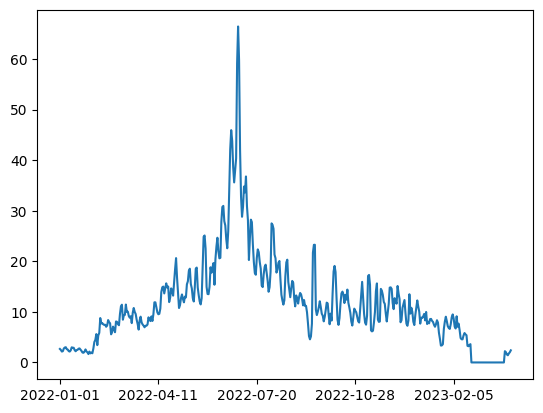

In [ ]:
dfs[1][dfs[1]['중분류'] == 0].iloc[:,4:].mean().plot()

In [ ]:
def label_encoding(dfs):
    label_encoder = LabelEncoder()
    categorical_columns = ['가격', '중분류', '소분류', '브랜드']
    for df in dfs:
        label_encoder = LabelEncoder()
        for col in categorical_columns:
            label_encoder.fit(df[col])
            df[col] = label_encoder.transform(df[col])

label_encoding(dfs)

In [ ]:
def scale_min_max(dfs):
    scalers = []
    for i, df in enumerate(dfs):
        sc = MinMaxScaler()
        sc = sc.fit(df.iloc[:,cat_size:].values.T)
        # if i == 3:
        #     np_sales = df.iloc[:,cat_size:].values
        #     max_threshold = np.percentile(np_sales, q=[85], axis=1).T.astype(int)
        #     df.iloc[:,cat_size:] = np.where(np_sales > max_threshold, max_threshold, np_sales)

        df.iloc[:, cat_size:] = sc.transform(df.iloc[:,cat_size:].values.T).T
        scalers.append(sc)
    return scalers

In [ ]:
scalers = scale_min_max(dfs)

In [ ]:
def make_train_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE, STEP_SIZE=7):
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, cat_size + time_size))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        brand_name = data.iloc[i,3]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            keyword_window=keyword_data[j : j + window_size]

            keyword_temp = keyword_window[:train_size]

            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            temp_data = np.column_stack((temp_data, keyword_temp))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]
            # input_data[i * adjusted_size + (j // STEP_SIZE)] = temp_data
            # target_data[i * adjusted_size + (j // STEP_SIZE)] = window[train_size:]

    return input_data, target_data

def make_predict_data(data, train_size=CFG.TRAIN_WINDOW_SIZE):
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, cat_size + time_size))

    for i in tqdm(range(num_rows)):

        sales_data = np.array(data.iloc[i, cat_size:])
        encode_info = np.array(data.iloc[i, :cat_size])

        brand_name =data.iloc[i,3]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)  # 차원을 (459)로 변경

        window = sales_data[-train_size : ]
        keyword_window=keyword_data[-train_size : ]

        keyword_temp = keyword_window[:train_size]

        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        temp_data=np.column_stack((temp_data,keyword_temp))
        input_data[i] = temp_data

    return input_data

In [ ]:
# Without Brand
def make_train_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE, STEP_SIZE=7):
    num_rows = len(data)
    window_size = train_size + predict_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, cat_size + time_size))
    target_data = np.empty((num_rows * adjusted_size, predict_size))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :cat_size])
        sales_data = np.array(data.iloc[i, cat_size:])

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            target_data[(j // STEP_SIZE) * num_rows + i] = window[train_size:]
            # input_data[i * adjusted_size + (j // STEP_SIZE)] = temp_data
            # target_data[i * adjusted_size + (j // STEP_SIZE)] = window[train_size:]

    return input_data, target_data

def make_predict_data(data, train_size=CFG.TRAIN_WINDOW_SIZE):
    num_rows = len(data)

    input_data = np.empty((num_rows, train_size, cat_size + time_size))

    for i in tqdm(range(num_rows)):
        sales_data = np.array(data.iloc[i, cat_size:])
        encode_info = np.array(data.iloc[i, :cat_size])
        window = sales_data[-train_size : ]

        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data

    return input_data

In [ ]:
def make_data(dfs):
    datas = []
    for i, df in enumerate(dfs):
        stride = 7
        if i > 1:
            stride = 2
        train_input, train_target = make_train_data(df, STEP_SIZE=stride)
        test_input = make_predict_data(df)
        datas.append((train_input, train_target, test_input))

    return datas

In [ ]:
datas = make_data(dfs)

  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 0/3768 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/10954 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/444 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

  0%|          | 0/613 [00:00<?, ?it/s]

In [ ]:
for i in range(len(datas)):
    print(datas[i][0].shape, datas[i][1].shape, datas[i][2].shape)

(169560, 126, 5) (169560, 21) (3768, 126, 5)
(492930, 126, 5) (492930, 21) (10954, 126, 5)
(70152, 126, 5) (70152, 21) (444, 126, 5)
(17538, 126, 5) (17538, 21) (111, 126, 5)
(96854, 126, 5) (96854, 21) (613, 126, 5)


In [ ]:
def train_val_split(datas):
    splited_datas = []
    for X_train, y_train, X_test in datas:
        skf = StratifiedKFold(n_splits=5)
        fold = np.random.choice(5)

        for i, (train_idxs, val_idxs) in enumerate(skf.split(X_train, y=X_train[:,0,2])):
            if i == fold:
                X_val = X_train[val_idxs]
                y_val = y_train[val_idxs]

                X_train = X_train[train_idxs]
                y_train = y_train[train_idxs]
                break
        splited_datas.append((X_train, y_train, X_val, y_val, X_test))

    return splited_datas

In [ ]:
datas = train_val_split(datas)

In [ ]:
for i in range(len(datas)):
    print(datas[i][0].shape, datas[i][1].shape, datas[i][2].shape, datas[i][3].shape, datas[i][4].shape)

(135648, 126, 5) (135648, 21) (33912, 126, 5) (33912, 21) (3768, 126, 5)
(394344, 126, 5) (394344, 21) (98586, 126, 5) (98586, 21) (10954, 126, 5)
(56122, 126, 5) (56122, 21) (14030, 126, 5) (14030, 21) (444, 126, 5)
(14030, 126, 5) (14030, 21) (3508, 126, 5) (3508, 21) (111, 126, 5)
(77484, 126, 5) (77484, 21) (19370, 126, 5) (19370, 21) (613, 126, 5)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])

    def __len__(self):
        return len(self.X)

In [ ]:
def make_dataloader(datas):
    datasets = []
    dataloaders = []
    for X_train, y_train, X_val, y_val, X_test in datas:
        train_dataset = CustomDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

        val_dataset = CustomDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

        test_dataset = CustomDataset(X_test, None)
        test_loader = DataLoader(test_dataset, batch_size = CFG.BATCH_SIZE, shuffle=False, num_workers=0)

        datasets.append((train_dataset, val_dataset, test_dataset))
        dataloaders.append((train_loader, val_loader, test_loader))

    return datasets, dataloaders

In [ ]:
datasets, dataloaders = make_dataloader(datas)

### Modeling

#### Model Classes

In [ ]:
import copy

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))


class TransformerEncoderBN(nn.Module):
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoderBN, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerEncoderLayerBN(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayerBN, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.BatchNorm1d(d_model) # Only BN After Self Attention
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayerBN, self).__setstate__(state)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src.permute(0,2,1)).transpose(1,2)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [ ]:
class moving_avg(nn.Module):
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(nn.Module):
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            noisy_x = x + noise
            return noisy_x
        return x

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.pe[:x.size(0), :]
        return self.dropout(x)


class TSTEmbedding(nn.Module):
    def __init__(self, num_categories, hidden_size, num_time_steps, kernel_size):
        super(TSTEmbedding, self).__init__()

        self.noise_layer = GaussianNoiseLayer(stddev=0.1)

        self.decompsition = series_decomp(kernel_size)
        self.linear_trend = nn.Linear(time_size, hidden_size)
        self.linear_seasonal = nn.Linear(time_size, hidden_size)

        self.embedding = nn.Embedding(num_categories, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        category_input, time_series_input = x[:, :, :cat_size], x[:, :, cat_size:]

        time_series_input = self.noise_layer(time_series_input)
        trend_init, seasonal_init = self.decompsition(time_series_input)

        trend_embedded = self.linear_trend(trend_init)
        seasonal_embedded = self.linear_seasonal(seasonal_init)
        time_series_embedded = trend_embedded + seasonal_embedded

        position_encoded = self.positional_encoding(time_series_embedded)

        category_embedded = self.embedding(category_input.long()).sum(dim=2)
        x = category_embedded + time_series_embedded + position_encoded

        return self.dropout(x)

In [ ]:
class TimeSeriesTransformerV2(nn.Module):
    def __init__(self, num_categories, num_time_steps, num_heads, hidden_size, num_layers, num_output_days, dropout_rate=0.3, kernel_size=25):
        super(TimeSeriesTransformerV2, self).__init__()

        self.data_embedding = TSTEmbedding(num_categories, hidden_size, num_time_steps, kernel_size)

        # encoder_layer = nn.TransformerEncoderLayer(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout_rate, activation='relu')
        # self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)

        encoder_layer = TransformerEncoderLayerBN(hidden_size, num_heads, dim_feedforward=hidden_size, dropout=dropout_rate, activation='relu')
        self.transformer_encoder = TransformerEncoderBN(encoder_layer, num_layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size * num_time_steps, hidden_size),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_output_days),
            # nn.ReLU()
        )

    def forward(self, x):
        x = self.data_embedding(x)
        x = self.transformer_encoder(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x

#### Model Initialize

In [ ]:
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_heads = 4
hidden_size = 256
num_layers = 3
num_output_days = CFG.PREDICT_SIZE
dropout_rate = 0.3
kernel_size = 25

In [ ]:
models = []

for i in range(len(datasets)):
    num_categories = dfs[i][['가격', '중분류', '소분류', '브랜드']].max().max()+1

    model = TimeSeriesTransformerV2(
        num_categories,
        num_time_steps,
        num_heads,
        hidden_size,
        num_layers,
        num_output_days,
        dropout_rate,
        kernel_size
    )

    models.append(model)

In [ ]:
path = f'./model/multi_models_{num_time_steps, num_heads, hidden_size, num_layers, num_output_days, dropout_rate, kernel_size}_1557_nobrand'

if not os.path.exists(path):
    os.makedirs(path)

#### Training Functions

In [ ]:
def add_min_by_row(x):
    min_x = torch.min(x, axis=1).values
    min_x = torch.abs(min_x).unsqueeze(1)
    return x + min_x

In [ ]:
def add_only_neg_min_by_row(x):
    min_x = torch.min(x, axis=1).values
    min_x = torch.where(min_x > 0, 0, min_x)
    min_x = torch.abs(min_x).unsqueeze(1)
    return x + min_x

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    lr_adjust = {epoch: CFG.LEARNING_RATE * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [ ]:
def PSFALoss(pred, target):

    PSFA = torch.zeros(1).to(device)

    for day in range(CFG.PREDICT_SIZE):
        total_sell = torch.sum(target[:, day])
        pred_values = pred[:, day]
        target_values = target[:, day]

        denominator = torch.maximum(target_values, pred_values)
        diffs = torch.where(denominator!=0, torch.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell
        else:
            sell_weights = torch.ones_like(target_values) / len(target_values)

        if not torch.isnan(diffs).any():
            PSFA += torch.sum(diffs * sell_weights) / CFG.PREDICT_SIZE

    return PSFA

In [ ]:
def PSFA_valid(pred, target):
    PSFA = 1
    for day in range(CFG.PREDICT_SIZE):
        total_sell = np.sum(target[:, day]) # day별 총 판매량
        pred_values = pred[:, day] # day별 예측 판매량
        target_values = target[:, day] # day별 실제 판매량

        # 실제 판매와 예측 판매가 같은 경우 오차가 없는 것으로 간주
        denominator = np.maximum(target_values, pred_values)
        diffs = np.where(denominator!=0, np.abs(target_values - pred_values) / denominator, 0)

        if total_sell != 0:
            sell_weights = target_values / total_sell  # Item별 day 총 판매량 내 비중
        else:
            sell_weights = np.ones_like(target_values) / len(target_values)  # 1 / len(ids)로 대체

        if not np.isnan(diffs).any():  # diffs에 NaN이 없는 경우에만 PSFA 값 업데이트
            PSFA -= np.sum(diffs * sell_weights) / CFG.PREDICT_SIZE

    return PSFA

In [ ]:
def inference(model, test_loader, device):
    predictions = []

    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            model=model.to(device)
            output = model(X)

            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()

            predictions.extend(output)

    return np.array(predictions)

In [ ]:
def train_model(model, train_loader, optimizer, scheduler=None, device=device, iteration_print=200, back=None):
    train_loss = 0.0
    huber_loss = 0.0
    psfa_loss = 0.0
    psfa_min_loss = 0.0
    psfa_min_loss2 = 0.0
    model.train()
    print('Train Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    for i, (batch_input, batch_target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        batch_input = batch_input.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input)
        outputs_min = add_min_by_row(outputs)
        outputs_min2 = add_only_neg_min_by_row(outputs)

        loss = criterion(outputs, batch_target)
        huber = huberloss(outputs, batch_target)
        psfa = PSFALoss(outputs, batch_target)
        psfa_min = PSFALoss(outputs_min, batch_target)
        psfa_min2 = PSFALoss(outputs_min2, batch_target)

        if back == 'huber':
            huber.backward()
        elif back == 'psfa':
            psfa.backward()
        elif back == 'psfa_min':
            psfa_min.backward()
        else:
            loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()
        huber_loss += huber.item()
        psfa_loss += psfa.item()
        psfa_min_loss += psfa_min.item()
        psfa_min_loss2 += psfa_min2.item()

        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f} ; Huber Loss : {huber.item():.4f} ; PSFA Loss : {psfa.item():.4f} ; PSFA Min Loss : {psfa_min.item():.4f} ; PSFA Min2 Loss : {psfa_min2.item():.4f}')

    avg_train_loss = train_loss/len(train_loader)
    avg_huber_loss = huber_loss/len(train_loader)
    avg_psfa_loss = psfa_loss/len(train_loader)
    avg_psfa_min_loss = psfa_min_loss/len(train_loader)
    avg_psfa_min_loss2 = psfa_min_loss2/len(train_loader)
    print(f'Train MSE Loss: {avg_train_loss:.4f} ; Huber Loss: {avg_huber_loss:.4f} ; PSFA Loss: {avg_psfa_loss:.4f}; PSFA Min Loss: {avg_psfa_min_loss:.4f} ; PSFA Min2 Loss: {avg_psfa_min_loss2:.4f}')

    if back == 'huber':
        return avg_huber_loss
    elif back == 'psfa':
        return avg_psfa_loss
    elif back == 'psfa_min':
        return avg_psfa_min_loss

    return avg_train_loss

def validate_model(model, val_loader, device=device):
    val_loss = 0.0
    model.eval()
    print('Val Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    preds = []
    targets = []

    with torch.no_grad():
        for batch_input, batch_target in tqdm(val_loader):
            targets.extend(batch_target.numpy())

            batch_input = batch_input.to(device)
            batch_target = batch_target.to(device)

            outputs = model(batch_input)
            loss = criterion(outputs, batch_target)
            val_loss += loss.item()

            preds.extend(outputs.detach().cpu().numpy())

    preds, targets = np.array(preds), np.array(targets)
    preds_min = preds.copy()
    preds_min2 = preds.copy()

    for i in range(preds.shape[0]):
        min_val = preds[i].min()
        preds_min[i] += abs(min_val)
        min_val = np.where(min_val > 0, 0, min_val)
        preds_min2[i] += abs(min_val)

    val_psfa = PSFA_valid(preds, targets)
    val_min_psfa = PSFA_valid(preds_min, targets)
    val_min2_psfa = PSFA_valid(preds_min2, targets)

    avg_val_loss = val_loss/len(val_loader)
    print(f'Val PSFA: {val_psfa:.4f} ; Min PSFA: {val_min_psfa:.4f} ; Min2 PSFA: {val_min2_psfa:.4f} ; Loss: {avg_val_loss:.4f}')

    val_psfa = max(val_psfa, val_min_psfa, val_min2_psfa)

    return val_psfa, avg_val_loss

In [ ]:
def save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, patience, model_index, path=path):
    flag_acc, flag_loss = True, True
    if best_acc <= avg_val_acc:
        flag_acc = False
        print(f'Save Model: {best_acc:.4f} -> {avg_val_acc:.4f}')
        best_acc = avg_val_acc
        torch.save(model.state_dict(), os.path.join(path,f'{model_index}_val_acc.pth'))

    if best_loss >= avg_val_loss:
        flag_loss = False
        print(f'Save Model: {best_loss:.4f} -> {avg_val_loss:.4f}')
        best_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(path,f'{model_index}_val_loss.pth'))

    if flag_acc and flag_loss:
        print('Patience Increased', patience, end=' ')
        patience += 1
        print('->',patience)
    else:
        patience = 0

    return best_acc, best_loss, patience

#### Train Model

In [ ]:
for model_index, model in enumerate(models):
    model = model.to(device)
    print(f'<<<<<<<<<<< Model {model_index} Started... >>>>>>>>>>>')

    epoch_scale_up = 1
    if model_index > 1:
        epoch_scale_up = 3

    best_acc, best_loss = 0.0, np.inf
    patience = 3
    patience_stack = 0

    train_loader, val_loader, _ = dataloaders[model_index]

    num_epochs = CFG.EPOCHS * epoch_scale_up
    optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
    total_steps = len(train_loader) * num_epochs
    criterion = nn.MSELoss()
    huberloss = nn.HuberLoss()

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch+1}/{num_epochs}]')

        avg_train_loss = train_model(model, train_loader, optimizer, None, device, 100, back=None)
        avg_val_acc, avg_val_loss = validate_model(model, val_loader, device)
        adjust_learning_rate(optimizer, epoch + 1)
        best_acc, best_loss, patience_stack = save_best_model(avg_val_acc, avg_val_loss, best_acc, best_loss, patience_stack, model_index)

        torch.save(model.state_dict(), os.path.join(path,f'model[{model_index}]_checkpoint_{epoch+1}.pth'))

        if patience_stack > patience - 1:
            print(f'Early Stopping at Epoch {epoch+1}')
            break

#### Prediction

<Axes: >

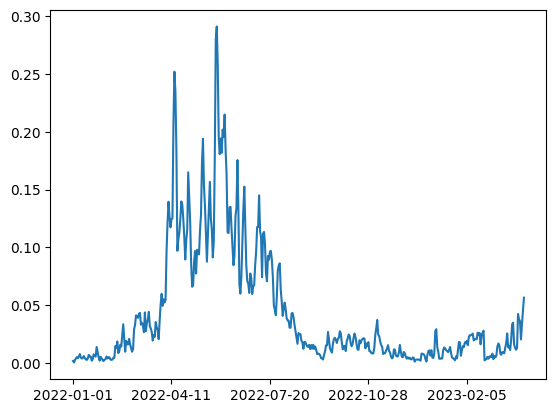

In [ ]:
dfs[3].iloc[:,4:].mean().plot()

In [ ]:
# 1457 / 126 / BN
checkpoints = [7, 2, 8, 3, 4]

min1 = [0, 1, 2, 4]
min2 = [3]

score = [.5959, .5543 , .6490, .4370, .5575]
loss = [.0203, .0185, .0266, .0066, .0306]

In [ ]:
weight = [len(x)/15890 for x in dfs]

avg = 0
for i in range(5):
    avg += score[i] * weight[i]

In [ ]:
avg

0.5661147828823159

In [ ]:
# 1323 / 126
checkpoints = [3, 2, 10, 6, 7]

min1 = [0, 1, 2, 3, 4]
min2 = []

score = [.5981, .5536, .6403, .4292, .5575]
loss = [.0203, .0185, .0266, .0066, .0306]

In [ ]:
# No ActvF 0742 / 189
checkpoints = [5, 3, 8, 7, 11]

min1 = [0, 1, 2, 4]
min2 = [3]

model_acc = [0, 1, 2, 3, 4]
model_loss = []

score = [.5952, .5448 , .5687, .4454, .5739]
loss = [.0219, .0184, .0381, .0077, .0208]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# No ActvF 0622
min1 = [0, 1, 4]
min2 = [2, 3]

model_acc = [0, 1, 2, 3, 4]
model_loss = []

score = [.6214, .5704, .6057, .4529, .5351]
loss = [.0228, .0184, .0227, .0133, .0233]

In [ ]:
for i, model in enumerate(models):
    if i in model_acc:
        model.load_state_dict(torch.load(os.path.join(path,f'{i}_val_acc.pth')))
    if i in model_loss:
        model.load_state_dict(torch.load(os.path.join(path,f'{i}_val_loss.pth')))

In [ ]:
# call by checkpoing
checkpoints = [7, 2, 8, 3, 4]

for i, model in enumerate(models):
    model.load_state_dict(torch.load(os.path.join(path,f'model[{i}]_checkpoint_{checkpoints[i]}.pth')))

In [ ]:
def make_min_mean_copy(pred):
    pred_min = pred.copy()
    pred_min2 = pred.copy()

    for i in range(pred.shape[0]):
        min_val = pred[i].min()
        pred_min[i] += abs(min_val)
        min_val = np.where(min_val > 0, 0, min_val)
        pred_min2[i] += abs(min_val)

    return pred_min, pred_min2

In [ ]:
preds = []

for i, model in enumerate(models):
    test_loader = dataloaders[i][-1]
    pred = inference(model, test_loader, device)

    pred = scalers[i].inverse_transform(pred.T).T
    pred = np.round(pred, 0).astype(int)

    pred_min, pred_min2 = make_min_mean_copy(pred)

    if i in min1:
        preds.append(pred_min)
    elif i in min2:
        preds.append(pred_min2)
    else:
        preds.append(pred)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')

for i in range(len(dfs)):
    submit.iloc[dfs[i].index,1:] = preds[i]

In [ ]:
submit.to_csv(os.path.join(path, 'best.csv'), index=False)

In [ ]:
sfile = pd.read_csv('./model/multi_models_(126, 4, 256, 3, 21, 0.3, 25)_1323/best.csv')

In [ ]:
sfile.iloc[1046:1056]

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
1046,1046,1818,1350,1214,1240,1303,1344,1403,1219,1134,...,1038,1182,1265,1301,1432,1321,1220,1252,1401,1434
1047,1047,6,5,4,5,5,5,5,4,4,...,4,5,4,5,5,5,4,5,5,5
1048,1048,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1049,1049,12,0,19,15,26,20,25,23,21,...,26,15,32,18,20,13,21,19,31,22
1050,1050,10,2,12,10,17,14,17,15,14,...,17,11,21,13,14,8,12,13,20,16
1051,1051,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1052,1052,6,5,4,4,5,5,5,4,4,...,4,4,4,4,5,5,4,5,5,5
1053,1053,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1054,1054,1,1,0,1,1,1,1,0,0,...,0,0,0,1,1,1,1,1,1,1
1055,1055,6,4,3,4,4,4,3,3,2,...,2,2,2,3,4,4,3,3,4,4


In [ ]:
sfile.iloc[1046:1056]

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
1046,1046,1232,1205,1036,999,1091,1049,1106,1150,1014,...,1012,939,1095,1036,976,1017,925,908,1042,965
1047,1047,5,5,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1048,1048,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,0,0,1,0
1049,1049,17,22,15,16,0,18,24,20,12,...,10,19,16,22,15,22,22,20,13,21
1050,1050,7,11,8,9,0,9,13,11,7,...,5,10,9,13,9,13,12,12,7,12
1051,1051,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1052,1052,3,3,2,3,3,3,3,3,2,...,3,2,3,2,2,2,2,2,3,2
1053,1053,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1054,1054,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1055,1055,2,3,2,2,2,1,1,2,2,...,2,1,1,1,1,2,1,1,1,0


# Masked Pretraining

### Tools

In [ ]:
from typing import List

import numpy as np
import pandas as pd
from pandas.tseries import offsets
from pandas.tseries.frequencies import to_offset

class TimeFeature:
    def __init__(self):
        pass

    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        pass

    def __repr__(self):
        return self.__class__.__name__ + "()"

class SecondOfMinute(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.second / 59.0 - 0.5

class MinuteOfHour(TimeFeature):
    """Minute of hour encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.minute / 59.0 - 0.5

class HourOfDay(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.hour / 23.0 - 0.5

class DayOfWeek(TimeFeature):
    """Hour of day encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return index.dayofweek / 6.0 - 0.5

class DayOfMonth(TimeFeature):
    """Day of month encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.day - 1) / 30.0 - 0.5

class DayOfYear(TimeFeature):
    """Day of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.dayofyear - 1) / 365.0 - 0.5

class MonthOfYear(TimeFeature):
    """Month of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.month - 1) / 11.0 - 0.5

class WeekOfYear(TimeFeature):
    """Week of year encoded as value between [-0.5, 0.5]"""
    def __call__(self, index: pd.DatetimeIndex) -> np.ndarray:
        return (index.week - 1) / 52.0 - 0.5

def time_features_from_frequency_str(freq_str: str) -> List[TimeFeature]:
    """
    Returns a list of time features that will be appropriate for the given frequency string.
    Parameters
    ----------
    freq_str
        Frequency string of the form [multiple][granularity] such as "12H", "5min", "1D" etc.
    """

    features_by_offsets = {
        offsets.YearEnd: [],
        offsets.QuarterEnd: [MonthOfYear],
        offsets.MonthEnd: [MonthOfYear],
        offsets.Week: [DayOfMonth, WeekOfYear],
        offsets.Day: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.BusinessDay: [DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Hour: [HourOfDay, DayOfWeek, DayOfMonth, DayOfYear],
        offsets.Minute: [
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
        offsets.Second: [
            SecondOfMinute,
            MinuteOfHour,
            HourOfDay,
            DayOfWeek,
            DayOfMonth,
            DayOfYear,
        ],
    }

    offset = to_offset(freq_str)

    for offset_type, feature_classes in features_by_offsets.items():
        if isinstance(offset, offset_type):
            return [cls() for cls in feature_classes]

    supported_freq_msg = f"""
    Unsupported frequency {freq_str}
    The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
    """
    raise RuntimeError(supported_freq_msg)

def time_features(dates, timeenc=1, freq='h'):
    """
    > `time_features` takes in a `dates` dataframe with a 'dates' column and extracts the date down to `freq` where freq can be any of the following if `timeenc` is 0:
    > * m - [month]
    > * w - [month]
    > * d - [month, day, weekday]
    > * b - [month, day, weekday]
    > * h - [month, day, weekday, hour]
    > * t - [month, day, weekday, hour, *minute]
    >
    > If `timeenc` is 1, a similar, but different list of `freq` values are supported (all encoded between [-0.5 and 0.5]):
    > * Q - [month]
    > * M - [month]
    > * W - [Day of month, week of year]
    > * D - [Day of week, day of month, day of year]
    > * B - [Day of week, day of month, day of year]
    > * H - [Hour of day, day of week, day of month, day of year]
    > * T - [Minute of hour*, hour of day, day of week, day of month, day of year]
    > * S - [Second of minute, minute of hour, hour of day, day of week, day of month, day of year]

    *minute returns a number from 0-3 corresponding to the 15 minute period it falls into.
    """
    if timeenc==0:
        dates['month'] = dates.date.apply(lambda row:row.month,1)
        dates['day'] = dates.date.apply(lambda row:row.day,1)
        dates['weekday'] = dates.date.apply(lambda row:row.weekday(),1)
        dates['hour'] = dates.date.apply(lambda row:row.hour,1)
        dates['minute'] = dates.date.apply(lambda row:row.minute,1)
        dates['minute'] = dates.minute.map(lambda x:x//15)
        freq_map = {
            'y':[],'m':['month'],'w':['month'],'d':['month','day','weekday'],
            'b':['month','day','weekday'],'h':['month','day','weekday','hour'],
            't':['month','day','weekday','hour','minute'],
        }
        return dates[freq_map[freq.lower()]].values
    if timeenc==1:
        dates = pd.to_datetime(dates.date.values)
        return np.vstack([feat(dates) for feat in time_features_from_frequency_str(freq)]).transpose(1,0)

### Make Pretrain Data

In [ ]:
train_data = pd.read_csv('./data/new_train_round.csv').drop(columns=['ID','제품'])

In [ ]:
train_data_keyword_cnt = pd.read_csv('./data/brand_keyword_cnt.csv').fillna(0)

In [ ]:
sc_main = MinMaxScaler()

train_data.iloc[:, 5:] = sc_main.fit_transform(train_data.iloc[:,5:].values.T).T

sc_brand = MinMaxScaler()

train_data_keyword_cnt.iloc[:, 1:] = sc_brand.fit_transform(train_data_keyword_cnt.iloc[:,1:].values.T).T

In [ ]:
label_encoder = LabelEncoder()
categorical_columns = ['가격', '대분류', '중분류', '소분류', '브랜드']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [ ]:
all_dates = pd.DataFrame(
        columns=['date'],
        data=train_data.columns[5:]
  )

date_stamps = time_features(all_dates, timeenc=1, freq='d')

In [ ]:
# 사전학습용 데이터 만들기
def make_pretrain_data(data, train_size=CFG.TRAIN_WINDOW_SIZE, predict_size=CFG.PREDICT_SIZE, STEP_SIZE=7):
    brand_labels = label_encoder.classes_

    num_rows = len(data)
    window_size = train_size
    adjusted_size = (len(data.columns) - window_size + 1) // STEP_SIZE

    input_data = np.empty((num_rows * adjusted_size, train_size, len(data.iloc[0, :5]) + 2))
    input_mark = np.empty((num_rows * adjusted_size, train_size, 3))

    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])

        brand_name = brand_labels[data.iloc[i,4]]
        keyword_data=np.array(train_data_keyword_cnt.loc[train_data_keyword_cnt["브랜드"] == brand_name, train_data_keyword_cnt.columns[1:]])
        keyword_data = keyword_data.reshape(-1)

        for j in range(0, len(sales_data) - window_size + 1, STEP_SIZE):
            window = sales_data[j: j + window_size]
            window_dates = date_stamps[j:j+train_size]
            keyword_window = keyword_data[j : j + window_size]

            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window))
            temp_data = np.column_stack((temp_data, keyword_window))

            input_data[(j // STEP_SIZE) * num_rows + i] = temp_data
            input_mark[(j // STEP_SIZE) * num_rows + i] = window_dates

    return input_data, input_mark, input_data[:,:,-2:]

In [ ]:
train_input, train_mark, train_target = make_pretrain_data(train_data, STEP_SIZE=2)

  0%|          | 0/15890 [00:00<?, ?it/s]

In [ ]:
print(train_input.shape, train_mark.shape, train_target.shape)

(2685410, 126, 7) (2685410, 126, 3) (2685410, 126, 2)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, X_mark, Y):
        self.X = X
        self.X_mark = X_mark
        self.Y = Y

    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index]), torch.Tensor(self.X_mark[index])

    def __len__(self):
        return len(self.X)

In [ ]:
train_dataset = CustomDataset(train_input, train_mark, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG.BATCH_SIZE, shuffle=True, num_workers=0)

### Model

#### Model Class

In [ ]:
import copy

def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

def _get_activation_fn(activation):
    if activation == "relu":
        return F.relu
    elif activation == "gelu":
        return F.gelu

    raise RuntimeError("activation should be relu/gelu, not {}".format(activation))


class TransformerEncoderBN(nn.Module):
    __constants__ = ['norm']

    def __init__(self, encoder_layer, num_layers, norm=None):
        super(TransformerEncoderBN, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(self, src, mask=None, src_key_padding_mask=None):
        output = src

        for mod in self.layers:
            output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

        if self.norm is not None:
            output = self.norm(output)

        return output


class TransformerEncoderLayerBN(nn.Module):
    def __init__(self, d_model, nhead, num_time_steps, dim_feedforward=2048, dropout=0.1, activation="relu"):
        super(TransformerEncoderLayerBN, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.BatchNorm1d(num_time_steps) # Only BN After Self Attention
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = _get_activation_fn(activation)

    def __setstate__(self, state):
        if 'activation' not in state:
            state['activation'] = F.relu
        super(TransformerEncoderLayerBN, self).__setstate__(state)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

In [ ]:
class GaussianNoiseLayer(nn.Module):
    def __init__(self, stddev):
        super(GaussianNoiseLayer, self).__init__()
        self.stddev = stddev

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.stddev
            noisy_x = x + noise
            return noisy_x
        return x

class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = self.pe[:x.size(0), :]  # Adjust the positional encoding to match sequence length
        return self.dropout(x)

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                    kernel_size=3, padding=padding, padding_mode='circular')
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu')

    def forward(self, x):
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x

class TimeFeatureEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='timeF', freq='h'):
        super(TimeFeatureEmbedding, self).__init__()

        freq_map = {'h':4, 't':5, 's':6, 'm':1, 'a':1, 'w':2, 'd':3, 'b':3}
        d_inp = freq_map[freq]
        self.embed = nn.Linear(d_inp, d_model)

    def forward(self, x):
        return self.embed(x)

class TSTEmbedding(nn.Module):
    def __init__(self, num_categories, hidden_size, num_time_steps, pretrain=False):
        super(TSTEmbedding, self).__init__()

        self.noise_layer = GaussianNoiseLayer(stddev=0.1)
        self.cat_embedding = nn.Embedding(num_categories, hidden_size)
        self.date_embedding = TimeFeatureEmbedding(hidden_size, embed_type='timeF', freq='d')
        self.time_embedding = TokenEmbedding(2, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, num_time_steps)
        self.layernorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.pretrain = pretrain

    def forward(self, x, x_mark=None):
        category_input = x[:, :, :5]
        time_series_input = x[:, :, -2:]

        if not self.pretrain:
            time_series_input = self.noise_layer(time_series_input)

        category_embedded = self.cat_embedding(category_input.long())
        category_embedded = category_embedded.sum(dim=2)
        time_embedded = self.time_embedding(time_series_input)
        x = category_embedded + time_embedded

        if torch.is_tensor(x_mark):
            date_embedded = self.date_embedding(x_mark)
            x += date_embedded

        x = x + self.positional_encoding(x)
        return self.dropout(x)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, num_time_steps, num_heads, hidden_size, num_layers, size=(7839, 5, 11, 53, 3799), pretrain=False):
        super(TimeSeriesTransformer, self).__init__()

        self.pretrain = pretrain

        # Embeddings
        num_categories = max(size)
        self.embedding = TSTEmbedding(num_categories, hidden_size, num_time_steps, pretrain=pretrain)

        # BN
        encoder_layer = TransformerEncoderLayerBN(hidden_size, num_heads, num_time_steps, dim_feedforward=hidden_size, dropout=0.05, activation='gelu')
        self.transformer_encoder = TransformerEncoderBN(encoder_layer, num_layers)

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 2),
        )

    def forward(self, x, x_mark=None):
        batch_size = x.size(0)
        x = self.embedding(x, x_mark)

        src_mask = None
        if self.pretrain:
            src_mask = self._generate_mask_sequence(num_time_steps)

        x = self.transformer_encoder(x, src_mask)
        # x = x.view(batch_size, -1) # [B, T, H]

        x = self.fc(x) # [B, T, 2]

        return x

    def _generate_mask_sequence(self, t):
        mask = (torch.triu(torch.ones(t, t)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

#### Model Initialize

In [ ]:
num_time_steps = CFG.TRAIN_WINDOW_SIZE
num_heads = 4
hidden_size = 512
num_layers = 4
cat_size = (
    train_data['가격'].max()+1,
    train_data['대분류'].max()+1,
    train_data['중분류'].max()+1,
    train_data['소분류'].max()+1,
    train_data['브랜드'].max()+1
)

In [ ]:
path = f'./model/pretrain_1'

if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
model = TimeSeriesTransformer(
    num_time_steps,
    num_heads,
    hidden_size,
    num_layers,
    cat_size,
    pretrain=True
)

model = model.to(device)

In [ ]:
num_epochs = CFG.EPOCHS
optimizer = optim.AdamW(model.parameters(), lr=CFG.LEARNING_RATE)
criterion = nn.MSELoss()

#### Model Functions

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    # lr = args.learning_rate * (0.2 ** (epoch // 2))
    lr_adjust = {epoch: CFG.LEARNING_RATE * (0.5 ** ((epoch-1) // 1))}
    if epoch in lr_adjust.keys():
        lr = lr_adjust[epoch]
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        print('Updating learning rate to {}'.format(lr))

In [ ]:
def train_model(model, train_loader, optimizer=optimizer, scheduler=None, device=device, iteration_print=200):
    train_loss = 0.0
    model.train()
    print('Train Mode', end=" ")

    gc.collect()
    torch.cuda.empty_cache()

    for i, (batch_input, batch_input_mark, batch_target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        batch_input = batch_input.to(device)
        batch_input_mark = batch_input_mark.to(device)
        batch_target = batch_target.to(device)

        outputs = model(batch_input, batch_input_mark)
        loss = criterion(outputs, batch_target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()

        if (i+1)%iteration_print == 0:
            print(f'Iteration {i+1} MSE Loss : {loss.item():.4f}')

    avg_train_loss = train_loss/len(train_loader)
    print(f'Train MSE Loss: {avg_train_loss:.4f}')

    return model

#### Train

In [ ]:
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    model = train_model(model, train_loader, optimizer, None, device, 100)
    adjust_learning_rate(optimizer, epoch + 1)

#### Create Submission File

In [ ]:
model.load_state_dict(torch.load(os.path.join(path, 'val_loss.pth')))

In [ ]:
pred = inference(model, test_loader, device)

In [ ]:
pred = sc_main.inverse_transform(pred.T).T
# pred *= norm_weight
pred = np.round(pred, 0).astype(int)

In [ ]:
pred_min = pred.copy()
pred_min_mean = pred.copy()

for i in range(pred.shape[0]):
    min_val = abs(pred[i].min())
    pred_min[i] += min_val
    mean_val = np.mean(pred_min[i]).astype(int)
    pred_min_mean[i] += min_val + mean_val

In [ ]:
submit = pd.read_csv('./open/sample_submission.csv')

In [ ]:
submit.iloc[:,1:] = pred_min
submit

In [ ]:
submit.to_csv(os.path.join(path, 'val_acc_min_addition.csv'), index=False)

# 중분류별

In [ ]:
train_data = pd.read_csv('./data/train.csv').drop(columns=['ID', '제품'])

In [ ]:
le = LabelEncoder()

train_data['중분류'] = le.fit_transform(train_data['중분류'])

<Axes: >

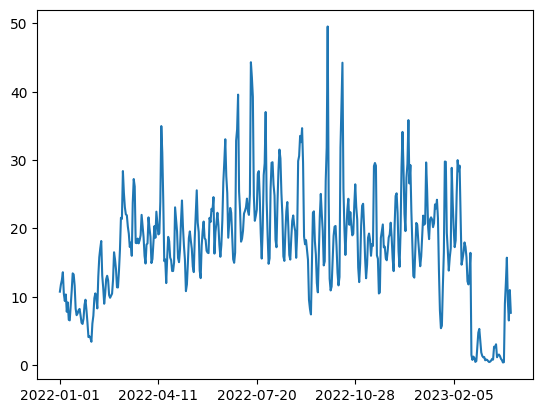

In [ ]:
train_data[train_data['중분류']==10].iloc[:,4:].mean().plot()

<Axes: >

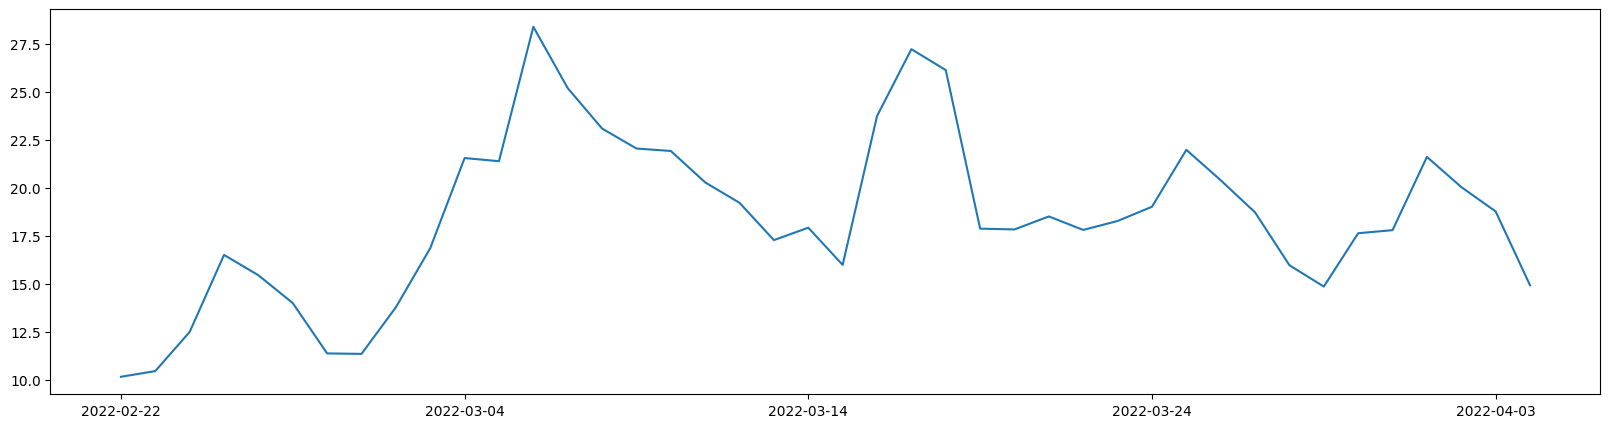

In [ ]:
plt.figure(figsize=(20,5))
train_data[train_data['중분류']==10].loc[:,'2022-02-22':'2022-04-04'].mean().plot()

<Axes: >

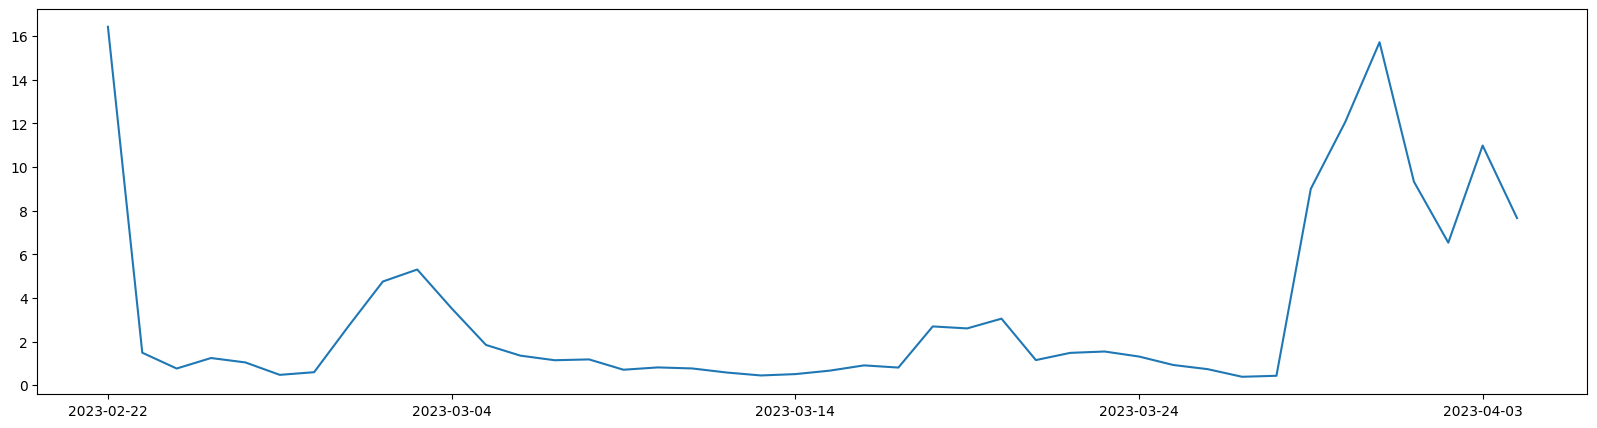

In [ ]:
plt.figure(figsize=(20,5))
train_data[train_data['중분류']==10].loc[:,'2023-02-22':'2023-04-04'].mean().plot()

<Axes: >

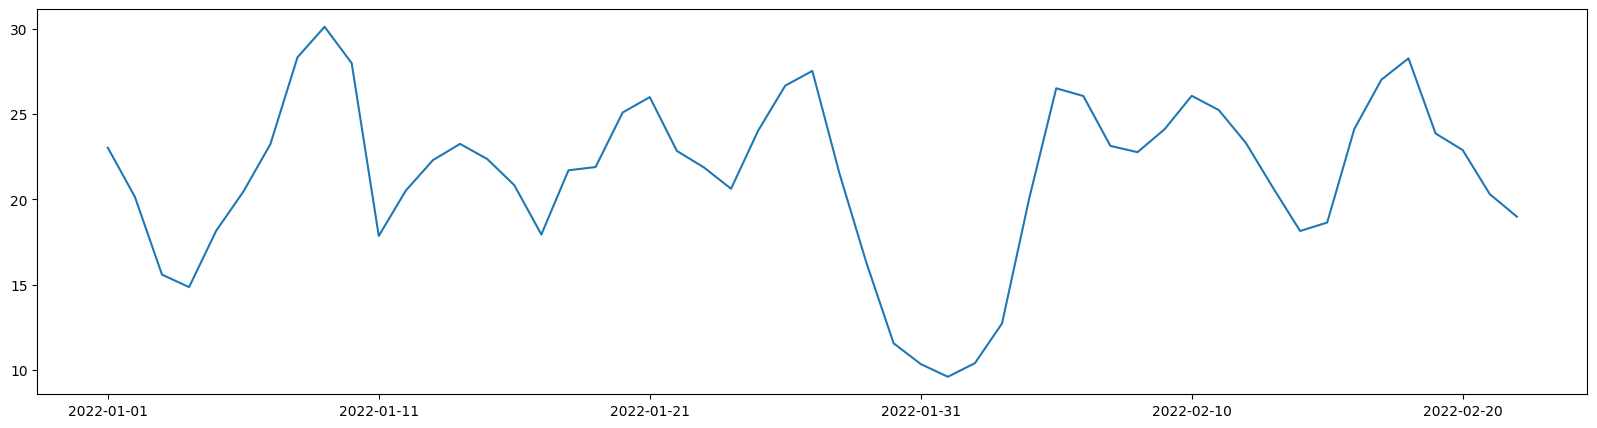

In [ ]:
plt.figure(figsize=(20,5))
train_data[train_data['중분류']==0].loc[:,'2022-01-01':'2022-02-22'].mean().plot()

<Axes: >

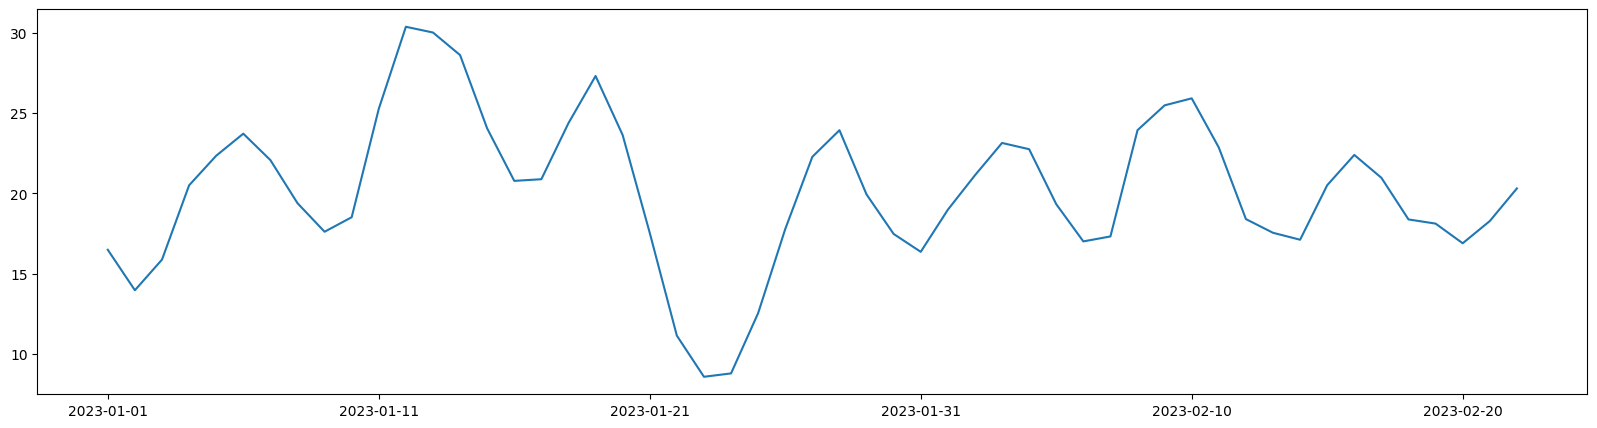

In [ ]:
plt.figure(figsize=(20,5))
train_data[train_data['중분류']==0].loc[:,'2023-01-01':'2023-02-22'].mean().plot()